https://github.com/ds-leehanjin/league-of-legends-outcome-classification/blob/master/notebook_final.pdf

## Goal: Try to predict Competitive Matches from the Early Game

### This includes which player got first blood, first blooded, first dragon, first herald, first tower, their gold and experience difference to their opposition at 10 minutes, and their kills, assists, and deaths at 10 minutes.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
esports2023 = pd.read_csv("2023_LoL_esports_match_data_from_OraclesElixir.csv")

### Preliminary EDA and Data Cleaning

In [3]:
np.array([esports2023.columns])

array([['gameid', 'datacompleteness', 'url', 'league', 'year', 'split',
        'playoffs', 'date', 'game', 'patch', 'participantid', 'side',
        'position', 'playername', 'playerid', 'teamname', 'teamid',
        'champion', 'ban1', 'ban2', 'ban3', 'ban4', 'ban5', 'gamelength',
        'result', 'kills', 'deaths', 'assists', 'teamkills',
        'teamdeaths', 'doublekills', 'triplekills', 'quadrakills',
        'pentakills', 'firstblood', 'firstbloodkill', 'firstbloodassist',
        'firstbloodvictim', 'team kpm', 'ckpm', 'firstdragon', 'dragons',
        'opp_dragons', 'elementaldrakes', 'opp_elementaldrakes',
        'infernals', 'mountains', 'clouds', 'oceans', 'chemtechs',
        'hextechs', 'dragons (type unknown)', 'elders', 'opp_elders',
        'firstherald', 'heralds', 'opp_heralds', 'firstbaron', 'barons',
        'opp_barons', 'firsttower', 'towers', 'opp_towers',
        'firstmidtower', 'firsttothreetowers', 'turretplates',
        'opp_turretplates', 'inhibitors', 

In [4]:
esports2023["position"].unique()

array(['top', 'jng', 'mid', 'bot', 'sup', 'team'], dtype=object)

Make sure we get data that is "complete" by OraclesElixir standards

In [5]:
esports2023.drop(esports2023[esports2023["datacompleteness"] != "complete"].index, inplace = True)

Filter only by major regions. Since LPL is all incomplete, we will just not have LPL statistics

In [6]:
esports2023 = esports2023[(esports2023["league"] == "LCS") | (esports2023["league"] == "LEC") | (esports2023["league"] == "LCK")]

In [7]:
esports2023.head()

gameid datacompleteness  url league  year   split  \
1164  ESPORTSTMNT04_2659018         complete  NaN    LCK  2023  Spring   
1165  ESPORTSTMNT04_2659018         complete  NaN    LCK  2023  Spring   
1166  ESPORTSTMNT04_2659018         complete  NaN    LCK  2023  Spring   
1167  ESPORTSTMNT04_2659018         complete  NaN    LCK  2023  Spring   
1168  ESPORTSTMNT04_2659018         complete  NaN    LCK  2023  Spring   

      playoffs                 date  game  patch  ...  opp_csat15  \
1164         0  2023-01-18 08:17:31     1  13.01  ...       111.0   
1165         0  2023-01-18 08:17:31     1  13.01  ...        99.0   
1166         0  2023-01-18 08:17:31     1  13.01  ...       132.0   
1167         0  2023-01-18 08:17:31     1  13.01  ...       119.0   
1168         0  2023-01-18 08:17:31     1  13.01  ...         5.0   

     golddiffat15 xpdiffat15 csdiffat15 killsat15 assistsat15 deathsat15  \
1164        724.0      771.0       -4.0       2.0         0.0        0.0   
1165        338.0       -3.0       -6.0       2.0         1.0        0.0   
1166        410.0      -32.0       10.0       0.0         1.0        1.0   
1167       1174.0     1234.0       13.0       1.0         2.0        0.0   
1168        530.0      -47.0       -3.0       0.0         3.0        0.0   

     opp_killsat15 opp_assistsat15 opp_deathsat15  
1164           0.0             0.0            2.0  
1165           1.0             0.0            0.0  
1166           0.0             1.0            0.0  
1167           0.0             0.0            2.0  
1168           0.0             0.0            1.0  

[5 rows x 123 columns]

Since we are only interested in predicting matches given early game statistics, let's only look at the columns that are helpful in that. Furthermore, let's take away the opponent stats so that it seems like every game in this data set is its own separate game (which we know is to be false).

In [8]:
np.array([esports2023.columns])

array([['gameid', 'datacompleteness', 'url', 'league', 'year', 'split',
        'playoffs', 'date', 'game', 'patch', 'participantid', 'side',
        'position', 'playername', 'playerid', 'teamname', 'teamid',
        'champion', 'ban1', 'ban2', 'ban3', 'ban4', 'ban5', 'gamelength',
        'result', 'kills', 'deaths', 'assists', 'teamkills',
        'teamdeaths', 'doublekills', 'triplekills', 'quadrakills',
        'pentakills', 'firstblood', 'firstbloodkill', 'firstbloodassist',
        'firstbloodvictim', 'team kpm', 'ckpm', 'firstdragon', 'dragons',
        'opp_dragons', 'elementaldrakes', 'opp_elementaldrakes',
        'infernals', 'mountains', 'clouds', 'oceans', 'chemtechs',
        'hextechs', 'dragons (type unknown)', 'elders', 'opp_elders',
        'firstherald', 'heralds', 'opp_heralds', 'firstbaron', 'barons',
        'opp_barons', 'firsttower', 'towers', 'opp_towers',
        'firstmidtower', 'firsttothreetowers', 'turretplates',
        'opp_turretplates', 'inhibitors', 

In [9]:
esports2023 = esports2023[["result",
                           "side",
                           "position",
                           "firstblood",
                           "firstbloodvictim",
                           "firstdragon",
                           "firstherald",
                           "firsttower",
                           "golddiffat10",
                           "xpdiffat10",
                           "csdiffat10",
                           "killsat10",
                           "assistsat10",
                           "deathsat10"]]

In [10]:
esports2023.head()

result  side position  firstblood  firstbloodvictim  firstdragon  \
1164       1  Blue      top         0.0               0.0          NaN   
1165       1  Blue      jng         0.0               0.0          NaN   
1166       1  Blue      mid         0.0               1.0          NaN   
1167       1  Blue      bot         0.0               0.0          NaN   
1168       1  Blue      sup         0.0               0.0          NaN   

      firstherald  firsttower  golddiffat10  xpdiffat10  csdiffat10  \
1164          NaN         NaN         414.0       341.0        -3.0   
1165          NaN         NaN        -104.0       194.0         9.0   
1166          NaN         NaN        -114.0      -406.0        -1.0   
1167          NaN         NaN         211.0       447.0         5.0   
1168          NaN         NaN         177.0      -125.0         0.0   

      killsat10  assistsat10  deathsat10  
1164        1.0          0.0         0.0  
1165        0.0          1.0         0.0  
1166        0.0          1.0         1.0  
1167        0.0          0.0         0.0  
1168        0.0          0.0         0.0

Notice how we have some NaNs. Let's try to see why.

In [11]:
indices = [ind for ind, ele in enumerate(esports2023.isna().sum()) if ele != 0]
esports2023.columns[indices]

Index(['firstbloodvictim', 'firstdragon', 'firstherald', 'firsttower'], dtype='object')

The most obvious explanation as to why the columns have NaNs is simply because the team did not get that particular objective. As such, we will replace those with 0s.

In [12]:
esports2023.fillna(0, inplace = True)

In [13]:
esports2023.head(5)

result  side position  firstblood  firstbloodvictim  firstdragon  \
1164       1  Blue      top         0.0               0.0          0.0   
1165       1  Blue      jng         0.0               0.0          0.0   
1166       1  Blue      mid         0.0               1.0          0.0   
1167       1  Blue      bot         0.0               0.0          0.0   
1168       1  Blue      sup         0.0               0.0          0.0   

      firstherald  firsttower  golddiffat10  xpdiffat10  csdiffat10  \
1164          0.0         0.0         414.0       341.0        -3.0   
1165          0.0         0.0        -104.0       194.0         9.0   
1166          0.0         0.0        -114.0      -406.0        -1.0   
1167          0.0         0.0         211.0       447.0         5.0   
1168          0.0         0.0         177.0      -125.0         0.0   

      killsat10  assistsat10  deathsat10  
1164        1.0          0.0         0.0  
1165        0.0          1.0         0.0  
1166        0.0          1.0         1.0  
1167        0.0          0.0         0.0  
1168        0.0          0.0         0.0

In [14]:
esports2023.describe()

result   firstblood  firstbloodvictim  firstdragon  firstherald  \
count  5052.000000  5052.000000       5052.000000  5052.000000  5052.000000   
mean      0.500000     0.280879          0.083333     0.083333     0.083333   
std       0.500049     0.449473          0.276413     0.276413     0.276413   
min       0.000000     0.000000          0.000000     0.000000     0.000000   
25%       0.000000     0.000000          0.000000     0.000000     0.000000   
50%       0.500000     0.000000          0.000000     0.000000     0.000000   
75%       1.000000     1.000000          0.000000     0.000000     0.000000   
max       1.000000     1.000000          1.000000     1.000000     1.000000   

        firsttower  golddiffat10   xpdiffat10   csdiffat10    killsat10  \
count  5052.000000    5052.00000  5052.000000  5052.000000  5052.000000   
mean      0.083333       0.00000     0.000000     0.000000     0.590657   
std       0.276413     746.03556   544.112527    13.858292     1.056087   
min       0.000000   -4964.00000 -3556.000000   -70.000000     0.000000   
25%       0.000000    -336.00000  -278.000000    -7.000000     0.000000   
50%       0.000000       0.00000     0.000000     0.000000     0.000000   
75%       0.000000     336.00000   278.000000     7.000000     1.000000   
max       1.000000    4964.00000  3556.000000    70.000000     9.000000   

       assistsat10   deathsat10  
count   5052.00000  5052.000000  
mean       0.87213     0.592637  
std        1.63433     1.030484  
min        0.00000     0.000000  
25%        0.00000     0.000000  
50%        0.00000     0.000000  
75%        1.00000     1.000000  
max       18.00000     9.000000

In [15]:
esports2023.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 5052 entries, 1164 to 44627
Data columns (total 14 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   result            5052 non-null   int64  
 1   side              5052 non-null   object 
 2   position          5052 non-null   object 
 3   firstblood        5052 non-null   float64
 4   firstbloodvictim  5052 non-null   float64
 5   firstdragon       5052 non-null   float64
 6   firstherald       5052 non-null   float64
 7   firsttower        5052 non-null   float64
 8   golddiffat10      5052 non-null   float64
 9   xpdiffat10        5052 non-null   float64
 10  csdiffat10        5052 non-null   float64
 11  killsat10         5052 non-null   float64
 12  assistsat10       5052 non-null   float64
 13  deathsat10        5052 non-null   float64
dtypes: float64(11), int64(1), object(2)
memory usage: 592.0+ KB


One thing to note: while a majority of these columns have "float" data types, many are categorical variables. For example, the firstblood column tells us whether or not the player got firstblood (which is categorical). A 0 represents a no while a 1 represents a yes.

Note the "side" variable.

In [16]:
esports2023.side.unique()

array(['Blue', 'Red'], dtype=object)

I want to change all "Blues" to 0 and all "Reds" to 1.

In [17]:
esports2023.replace("Blue", 0, inplace = True)
esports2023.replace("Red", 1, inplace = True)

In [18]:
esports2023.head()

result  side position  firstblood  firstbloodvictim  firstdragon  \
1164       1     0      top         0.0               0.0          0.0   
1165       1     0      jng         0.0               0.0          0.0   
1166       1     0      mid         0.0               1.0          0.0   
1167       1     0      bot         0.0               0.0          0.0   
1168       1     0      sup         0.0               0.0          0.0   

      firstherald  firsttower  golddiffat10  xpdiffat10  csdiffat10  \
1164          0.0         0.0         414.0       341.0        -3.0   
1165          0.0         0.0        -104.0       194.0         9.0   
1166          0.0         0.0        -114.0      -406.0        -1.0   
1167          0.0         0.0         211.0       447.0         5.0   
1168          0.0         0.0         177.0      -125.0         0.0   

      killsat10  assistsat10  deathsat10  
1164        1.0          0.0         0.0  
1165        0.0          1.0         0.0  
1166        0.0          1.0         1.0  
1167        0.0          0.0         0.0  
1168        0.0          0.0         0.0

Finally, notice how each game is not independent of each other, despite all the cleaning we have done. This is partly because we have information of each lane. The way I will fix this is by separating by lane.

In [19]:
top = esports2023[esports2023["position"] == "top"].reset_index(drop = True).drop("position", axis = 1)
jng = esports2023[esports2023["position"] == "jng"].reset_index(drop = True).drop("position", axis = 1)
mid = esports2023[esports2023["position"] == "mid"].reset_index(drop = True).drop("position", axis = 1)
bot = esports2023[esports2023["position"] == "bot"].reset_index(drop = True).drop("position", axis = 1)
sup = esports2023[esports2023["position"] == "sup"].reset_index(drop = True).drop("position", axis = 1)
team = esports2023[esports2023["position"] == "team"].reset_index(drop = True).drop("position", axis = 1)

In [20]:
team.head(10)

result  side  firstblood  firstbloodvictim  firstdragon  firstherald  \
0       1     0         0.0               0.0          1.0          1.0   
1       0     1         1.0               0.0          0.0          0.0   
2       1     0         1.0               0.0          0.0          0.0   
3       0     1         0.0               0.0          1.0          1.0   
4       1     0         0.0               0.0          0.0          0.0   
5       0     1         1.0               0.0          1.0          1.0   
6       1     0         1.0               0.0          1.0          0.0   
7       0     1         0.0               0.0          0.0          1.0   
8       0     0         1.0               0.0          1.0          1.0   
9       1     1         0.0               0.0          0.0          0.0   

   firsttower  golddiffat10  xpdiffat10  csdiffat10  killsat10  assistsat10  \
0         1.0         584.0       451.0        10.0        1.0          2.0   
1         0.0        -584.0      -451.0       -10.0        1.0          1.0   
2         0.0         771.0      -319.0       -21.0        2.0          2.0   
3         1.0        -771.0       319.0        21.0        0.0          0.0   
4         1.0        -910.0      -146.0         2.0        2.0          4.0   
5         0.0         910.0       146.0        -2.0        4.0          9.0   
6         1.0        -511.0      -252.0        -9.0        0.0          0.0   
7         0.0         511.0       252.0         9.0        0.0          0.0   
8         1.0        2346.0      1030.0        17.0        3.0          2.0   
9         0.0       -2346.0     -1030.0       -17.0        0.0          0.0   

   deathsat10  
0         1.0  
1         1.0  
2         0.0  
3         2.0  
4         4.0  
5         2.0  
6         0.0  
7         0.0  
8         0.0  
9         3.0

We will put it into a dictionary to make things easier to work with. Also, let's create a function that copies the work we do in the dictionary, just so we don't have to keep copying work over

In [21]:
lanes = {"top" : top,
         "jng" : jng,
         "mid" : mid,
         "bot" : bot,
         "sup" : sup,
         "team" : team}

In [22]:
def copy_over():
    return lanes["top"], lanes["jng"], lanes["mid"], lanes["bot"], lanes["sup"], lanes["team"] 

Notice how the top, jng, mid, bot, and sup data frames don't have unique values for firstdragon, firstherald, and firsttower. These values are in the "team" category. Also notice how the team data frame does not have unique values for the firstbloodvictim value.

In [23]:
for key in lanes:
    print("First Dragon " + str(key) + " unique values: " + str(lanes[key].firstdragon.unique()))
    print("First Herald " + str(key) + " unique values: " + str(lanes[key].firstherald.unique()))
    print("First Tower " + str(key) + " unique values: " + str(lanes[key].firsttower.unique()))
    print("First Blood Victim " + str(key) + " unique values: " + str(lanes[key].firstbloodvictim.unique()))
    print("\n")

First Dragon top unique values: [0.]
First Herald top unique values: [0.]
First Tower top unique values: [0.]
First Blood Victim top unique values: [0. 1.]


First Dragon jng unique values: [0.]
First Herald jng unique values: [0.]
First Tower jng unique values: [0.]
First Blood Victim jng unique values: [0. 1.]


First Dragon mid unique values: [0.]
First Herald mid unique values: [0.]
First Tower mid unique values: [0.]
First Blood Victim mid unique values: [1. 0.]


First Dragon bot unique values: [0.]
First Herald bot unique values: [0.]
First Tower bot unique values: [0.]
First Blood Victim bot unique values: [0. 1.]


First Dragon sup unique values: [0.]
First Herald sup unique values: [0.]
First Tower sup unique values: [0.]
First Blood Victim sup unique values: [0. 1.]


First Dragon team unique values: [1. 0.]
First Herald team unique values: [1. 0.]
First Tower team unique values: [1. 0.]
First Blood Victim team unique values: [0.]




Let's delete them

In [24]:
for key in [key for key in lanes.keys() if key not in ["team"]]:
    lanes[key].drop(["firstdragon", "firstherald", "firsttower"], axis = 1, inplace = True)

In [25]:
lanes["team"].drop("firstbloodvictim", axis = 1, inplace = True)

In [26]:
top, jng, mid, bot, sup, team = copy_over()

### Data Visualization

How many times does Blue side win vs Red Side?

In [27]:
winsbyside = team.groupby("side").sum().reset_index()[["side", "result"]]
winsbyside

side  result
0     0     226
1     1     195

In [28]:
226/(226+195)

0.5368171021377672

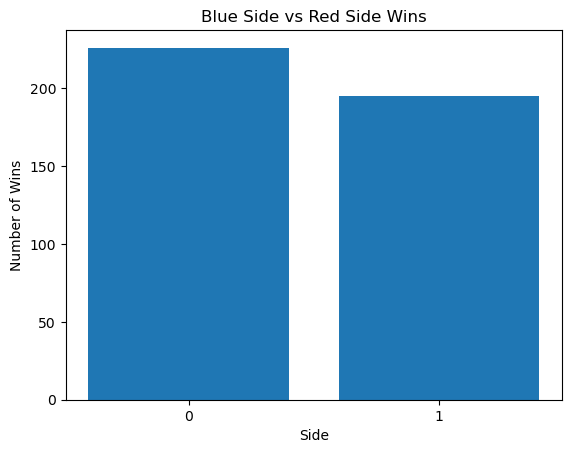

In [29]:
plt.bar(winsbyside["side"], winsbyside["result"])
plt.xticks(winsbyside["side"])
plt.xlabel("Side")
plt.ylabel("Number of Wins")
plt.title("Blue Side vs Red Side Wins")
plt.savefig("./side selection vs wins./side_vs_num_wins_graph.png", dpi = 150, bbox_inches="tight", facecolor='white', transparent=False)
plt.show()

What is the percentage of first blood succcess relative to winning or losing a match?

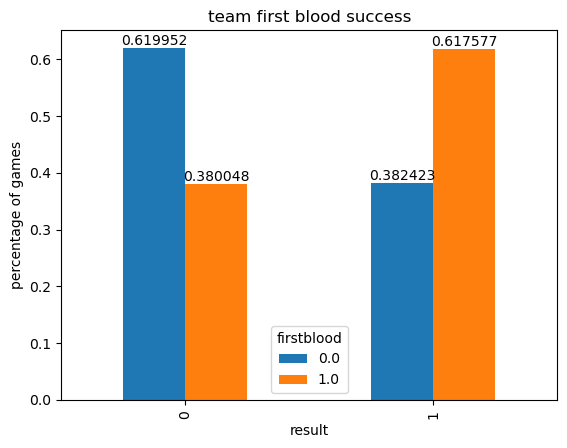

In [30]:
ax = pd.crosstab(team.result, team.firstblood, normalize='index').plot.bar()
ax.set_title("team first blood success")
ax.set_ylabel("percentage of games")
for c in ax.containers:
    ax.bar_label(c)
plt.savefig("./firstbloodrate vs wins./team first blood success.png", dpi = 150, bbox_inches="tight", facecolor='white', transparent=False)

As expected, when a team gets first blood, they are more likely to win.

What about per role? What is the percentage of first blood success relative to winning or losing a match for each role?

In [31]:
def fbinfo(df, dfname):
    ax = pd.crosstab(df.result, df.firstblood, normalize='index').plot.bar()
    ax.set_title(dfname)
    ax.set_ylabel("Percentage of Games")
    for c in ax.containers:
        ax.bar_label(c)
    plt.savefig("./firstbloodrate vs wins./" + dfname + ".png", dpi = 150, bbox_inches="tight", facecolor='white', transparent=False)

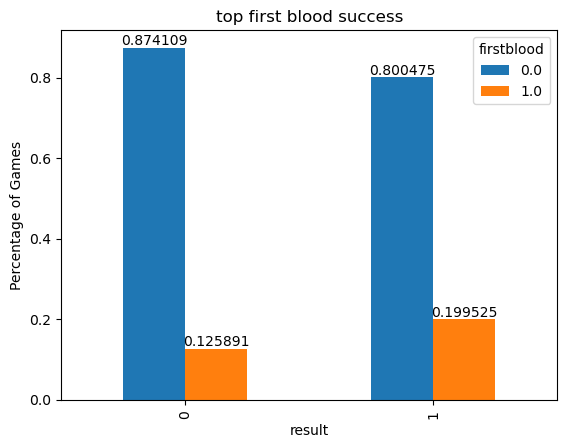

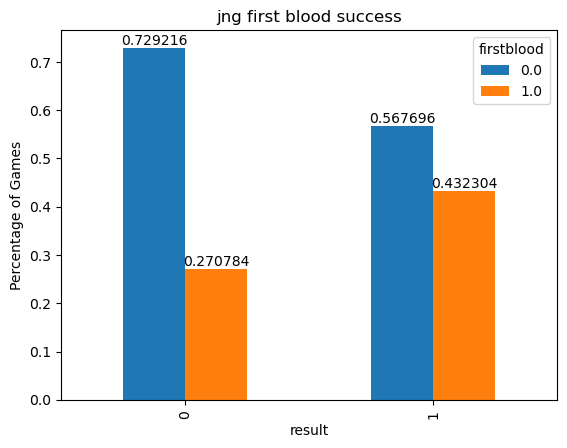

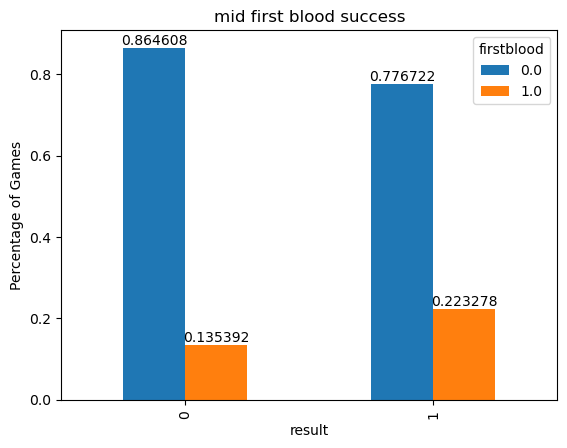

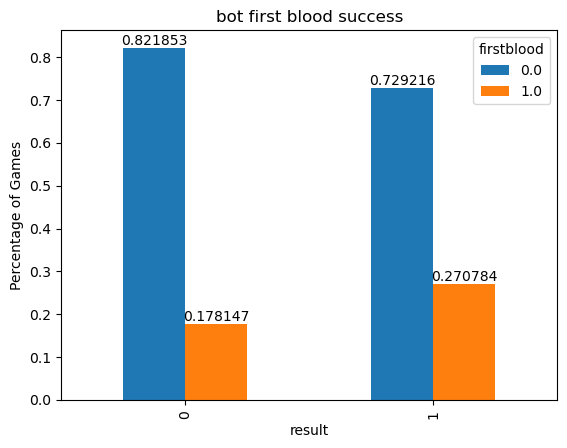

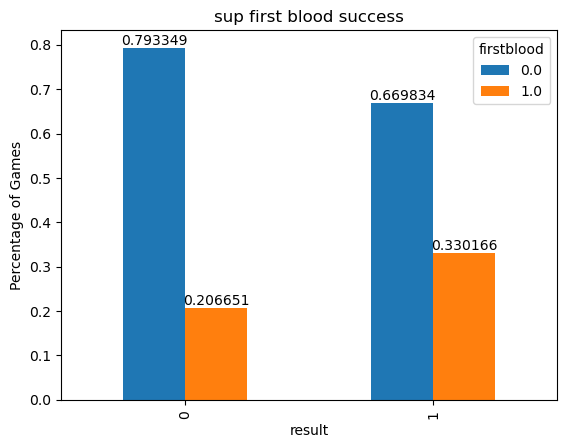

In [32]:
for key in [key for key in lanes.keys() if key not in ["team"]]:
    fbinfo(lanes[key], str(key) + " first blood success")

Above are bar graphs that show the percentages of wins and losses relative to the first blood rate in each role. So for example, of all losses in the dataset (represented by the 0), around 87.4109% did not have the top laner involved in the first blood while around 12.5891% did have the top laner involved in the first bloods. Of all wins in the dataset (represented by the 1), around 80.0475% did not have the top laner involved and around 19.9525% did have the top laner involved.

Looking at the trends of each graph, it is clear that the more first bloods a team has, the more likely they are to win. This can be for a variety of reasons. Better teams may just be more likely to score first bloods since they are better. Or it could be the fact that first bloods do, indeed, give a big enough advantage that allows teams to score the win.

However, I am skeptical of the latter. While it is true that when a player scores first blood, they trend towards winning more than their counterparts, more often than not, a player does not score first blood and still wins the game (as evident by the fact that the blue bar in the wins for all roles is higher than the orange bar). This is definitely due to the fact that League of Legends is not a zero-sum game. There are many factors, other than first blood, that determine a win. Thus I am inclined to believe that first blood, by itself, is not a good indicator of games that are won. This, however, is for the team category (which takes into a whole team's first blood rate). It is obvious that when a team scores first blood, they are more likely to win: 61.7577%. If the team does not score first blood, their chances of winning drop to 38.2423% (if we were to eliminate all of variables). This is the only category where scoring a first blood leads to a higher likelihood of winning a game than not winning a game.

Perhaps a more interesting thing to do is to compare between roles first blood rate between roles. Jungle is by far the role that is involved in the the most first bloods as evidenced by the tallter orange bar in wins in comparison to all the other roles. This makes sense, as junglers are the focal point of early games for competitive teams. If we were to try to predict whether or not a game is won or loss using only first bloods and roles, we should look at a jungler's capability to score that first kill for their team.

What is the percentage of getting the first dragon, first herald, or first tower relative to winning or losing a match?

In [33]:
np.where("firstdragon" in team.columns)

(array([0], dtype=int64),)

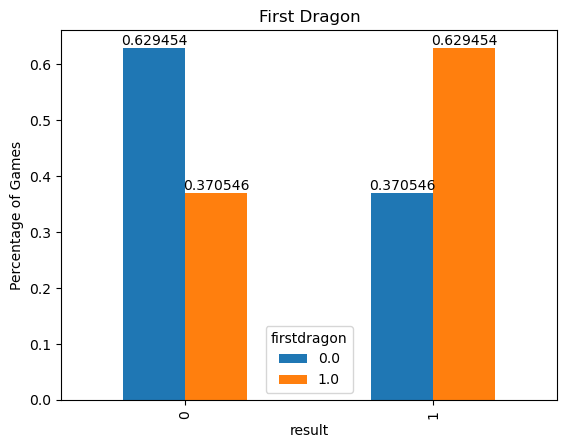

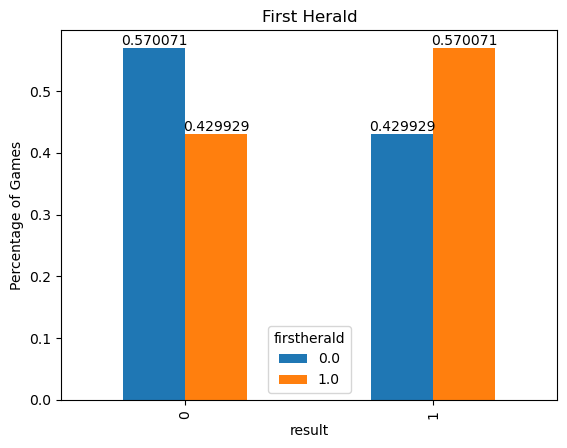

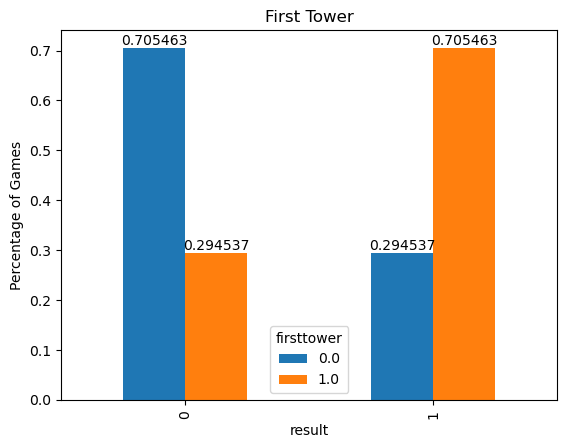

In [34]:
titles = ["First Dragon", "First Herald", "First Tower"]
index = 0
for column in team.columns[3:6]:
    ax = pd.crosstab(team["result"], team[column], normalize='index').plot.bar()
    ax.set_ylabel("Percentage of Games")
    ax.set_title(titles[index])
    for c in ax.containers:
        ax.bar_label(c)
    plt.savefig("./first objectives vs wins./" + titles[index] + ".png", dpi = 150, bbox_inches="tight", facecolor='white', transparent=False)
    index += 1

Of the games in the data set, 62.9454% of the wins had the winning team score first dragon, 57.0071% of the wins had the winning team score first herald, and 70.5463% of wins had the winning team score first tower. This means that if we are to use these three categories to predict whether or not a team will win, we should first look at first tower, then first drake, and finally first herald. Furthermore, this shows us that first tower is one of the most important factors in winning games this season. When you score a first tower, you are more likely to win a game. This could be for a variety of reasons; it could be the fact that first towers do, indeed, lead teams to win more. However, what is more likely is that teams already have large leads (and thus were already projected to win) which lead them to getting the first tower. 

One suprising aspect of these graphs is how first herald and first tower do not seem to be that closely related. One would think that teams usually use first herald to take first tower. Thus, I would expect these two categories to be relatively close in percentages. However, getting first herald is the worst of the three objectives, with first dragon beating it by 5.9383%.

Speaking of close relatedness, what is the correlation between each column in our data sets?

In [35]:
team.columns

Index(['result', 'side', 'firstblood', 'firstdragon', 'firstherald',
       'firsttower', 'golddiffat10', 'xpdiffat10', 'csdiffat10', 'killsat10',
       'assistsat10', 'deathsat10'],
      dtype='object')

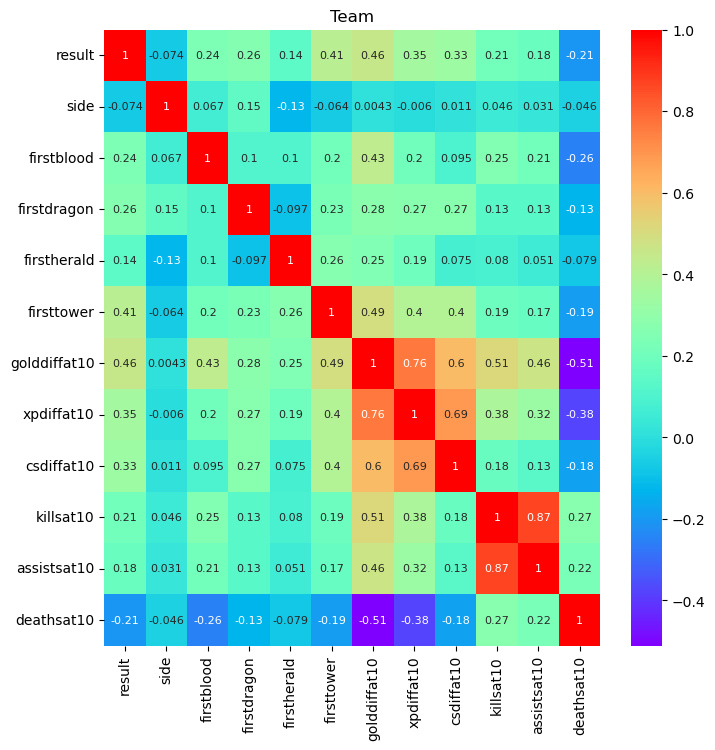

In [36]:
plt.figure(figsize = (8, 8))
plt.title("Team")
sns.heatmap(team.corr(), annot = True, cmap = "rainbow", annot_kws = {"size":8})
plt.savefig("./heatmaps./team heatmap.png", dpi = 150, bbox_inches="tight", facecolor='white', transparent=False)

Some interesting things to point out in this correlation plot: of the wins, the golddiffat10 is the highest category correlated to wins at 0.46. Getting first tower is a close second at 0.41.

In [37]:
def createheatmaps(df, dfname):
    plt.figure(figsize = (8, 8))
    plt.title(dfname)
    sns.heatmap(df.corr(), annot = True, cmap = "rainbow", annot_kws = {"size":8})
    plt.savefig("./heatmaps./" + dfname + ".png", dpi = 150, bbox_inches="tight", facecolor='white', transparent=False)

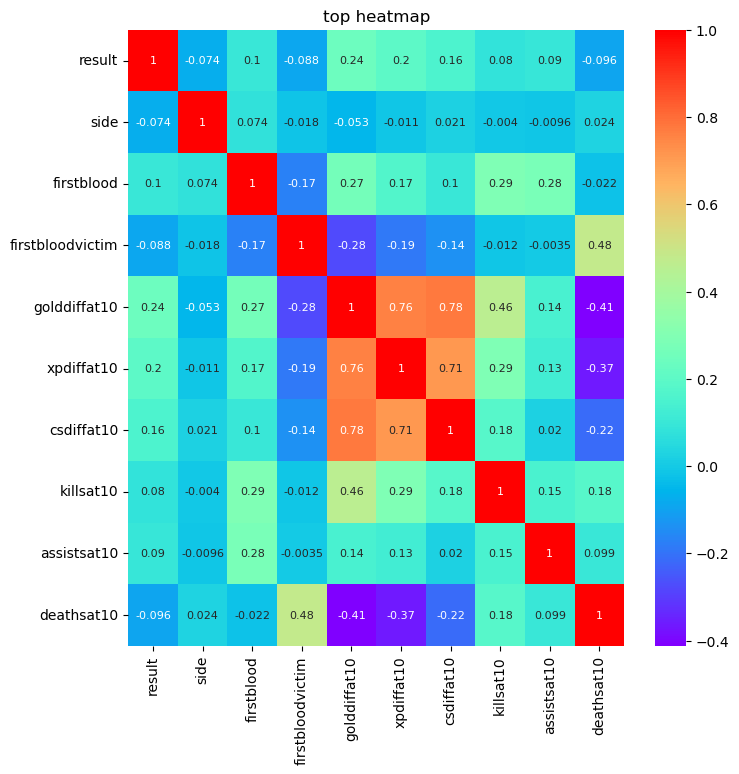

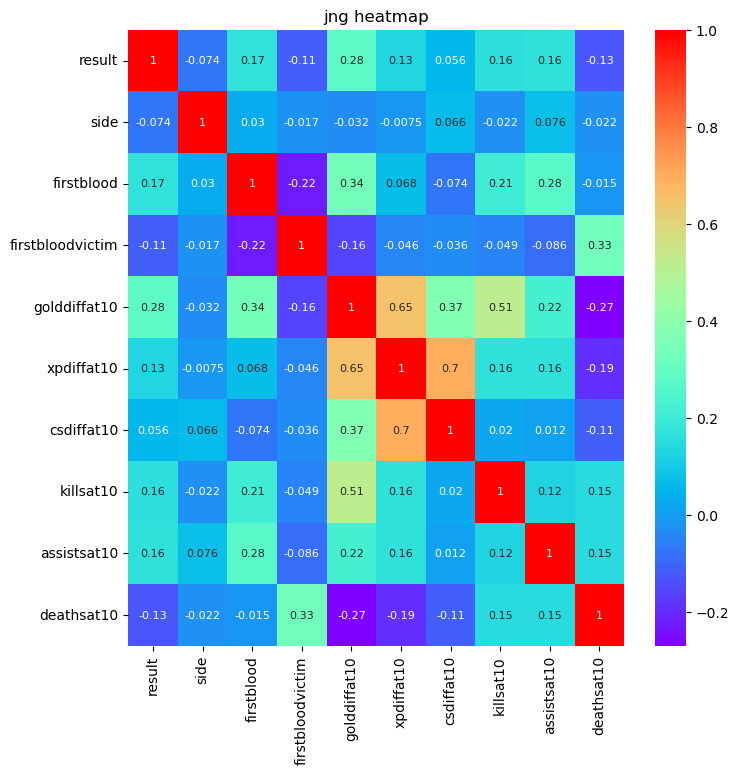

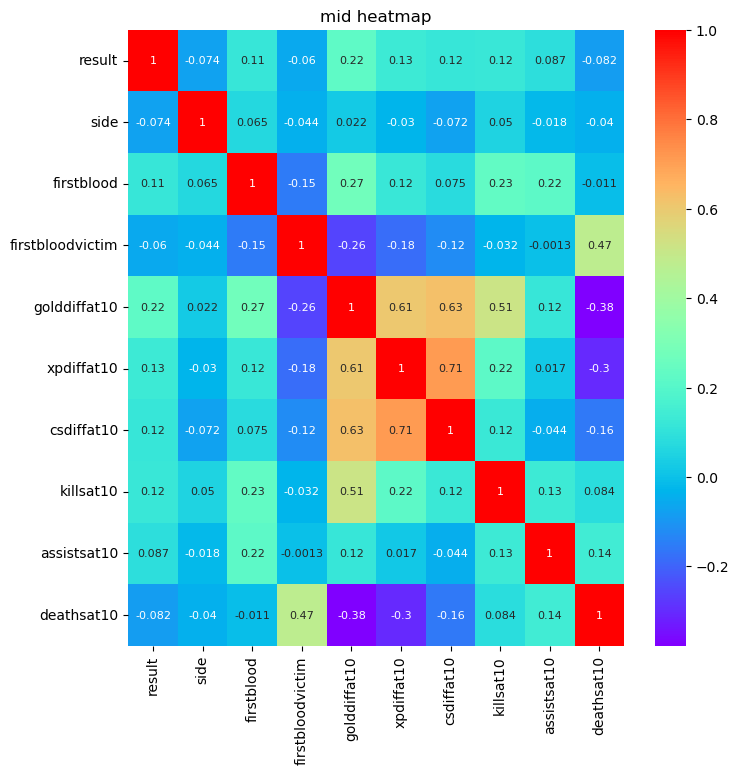

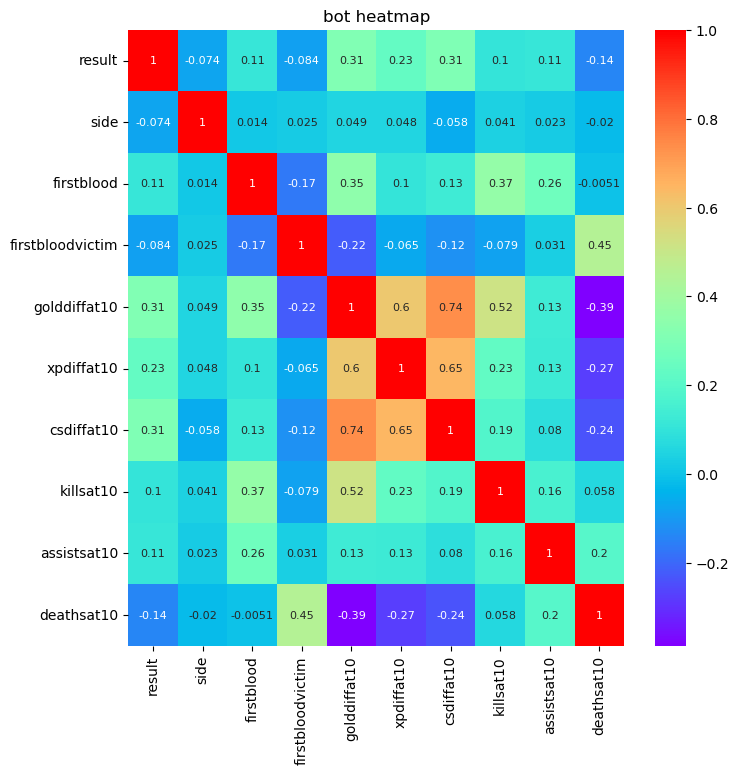

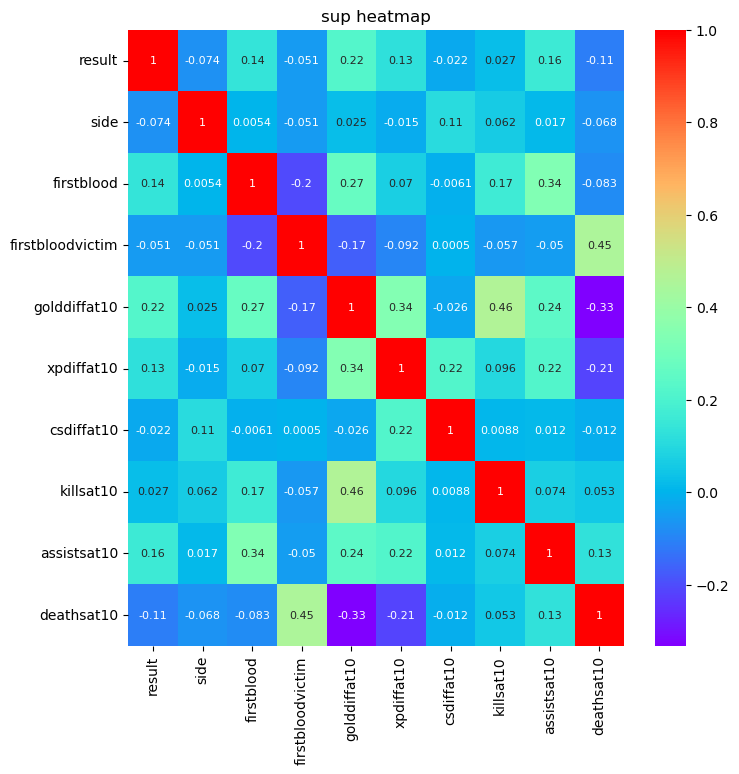

In [38]:
for key in [key for key in lanes.keys() if key not in ["team"]]:
    createheatmaps(lanes[key], str(key) + " heatmap")

What is the distribution of each numerical column?

In [39]:
# define a function that shows a distribution and box plot
def hist_and_box(df, col):
    
    # assign mean and median to go with histogram
    median = df[col][df["result"] == 1].median()
    mean = df[col][team["result"] == 1].mean()
    
    # initalize axes
    fig, ax = plt.subplots(1, 2, figsize = (13, 4))
    ax0 = ax[0]
    ax1 = ax[1]

    # make histogram
    sns.histplot(df[col][df["result"] == 1], alpha = 0.5, stat = "density", ax = ax0)
    sns.kdeplot(df[col][df["result"] == 1], color = "red", label = "KDE", ax = ax0)
    ax0.set_title(F"Distribution of {col} in Wins")
    ax0.axvline(median, label = f'median={median:,}',color='black')
    ax0.axvline(mean, label = f'mean={mean:,}',color='black', ls=':')
    ax0.legend()
    
    # make boxplot
    sns.boxplot(df[col][df["result"] == 1], orient = "h", ax = ax1, x = df[col][df["result"] == 1])
    ax1.set_title(F"Box Plot of {col} in Wins")

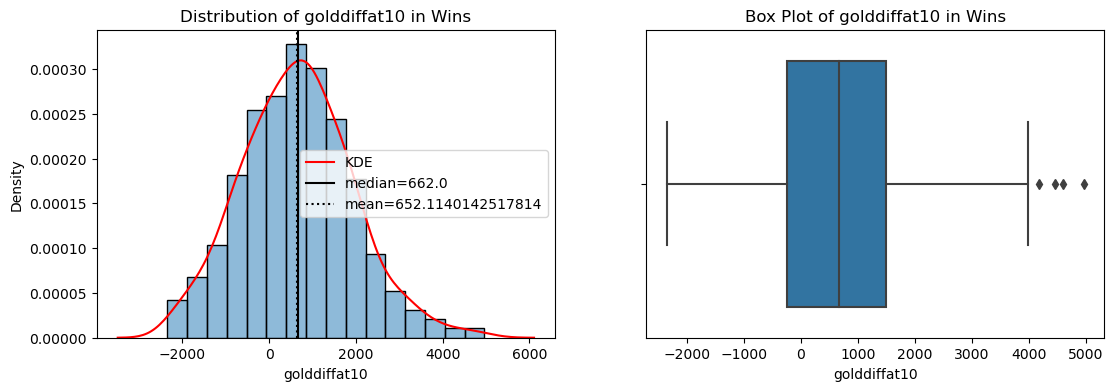

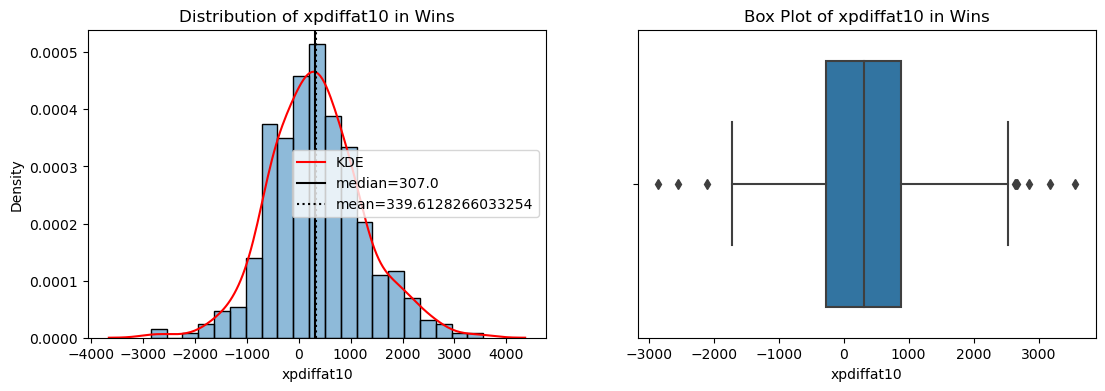

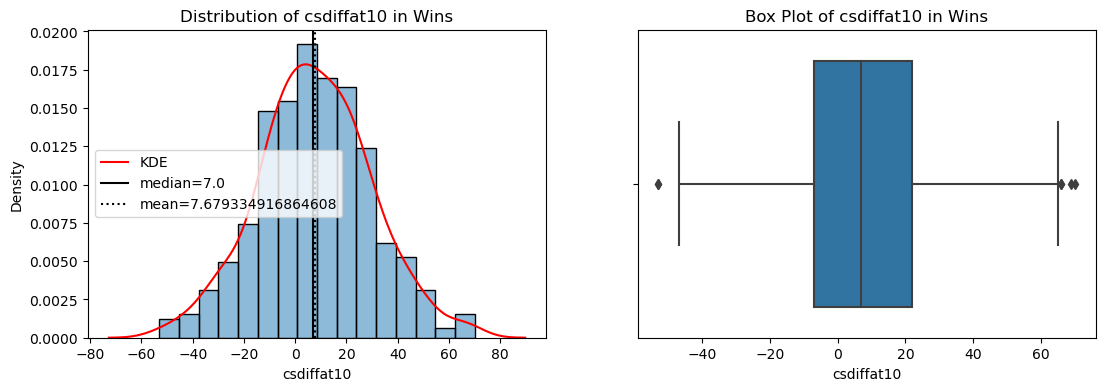

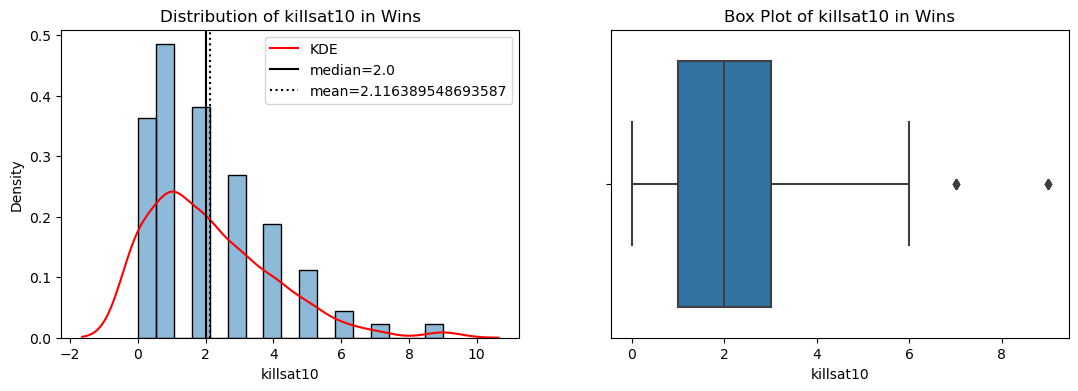

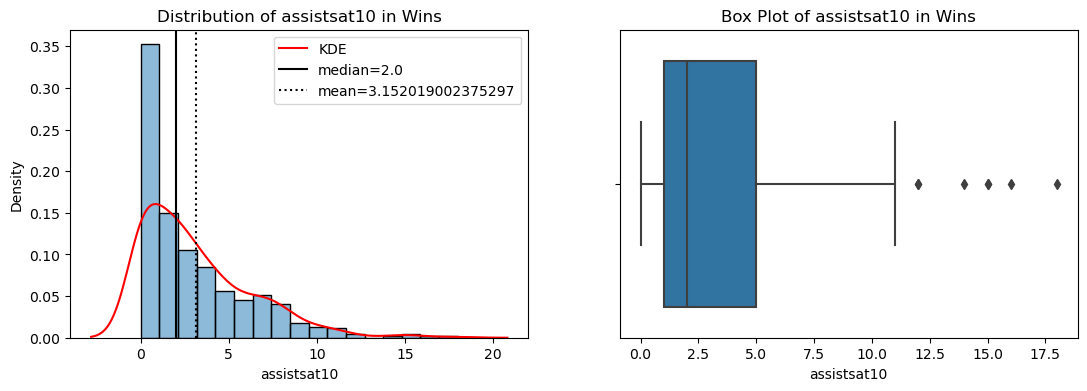

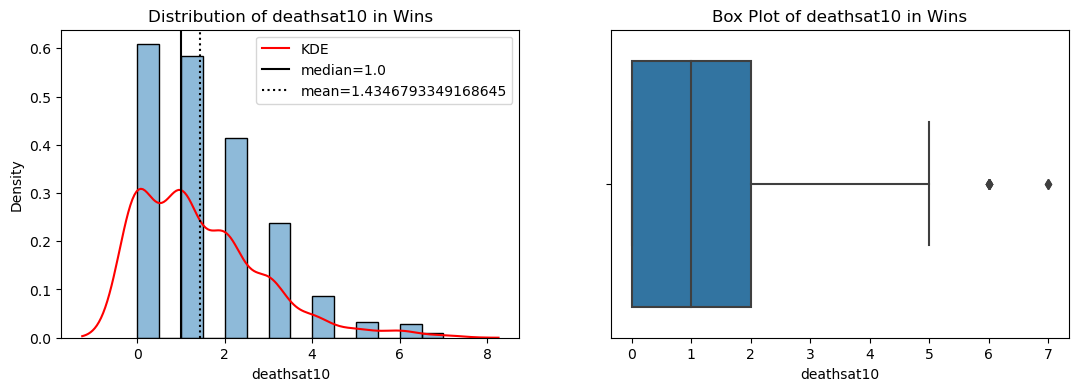

In [40]:
for column in team.columns[6:]:
    col = column
    hist_and_box(team, column)
    plt.savefig(F"./histograms and boxplots./team_{col}")

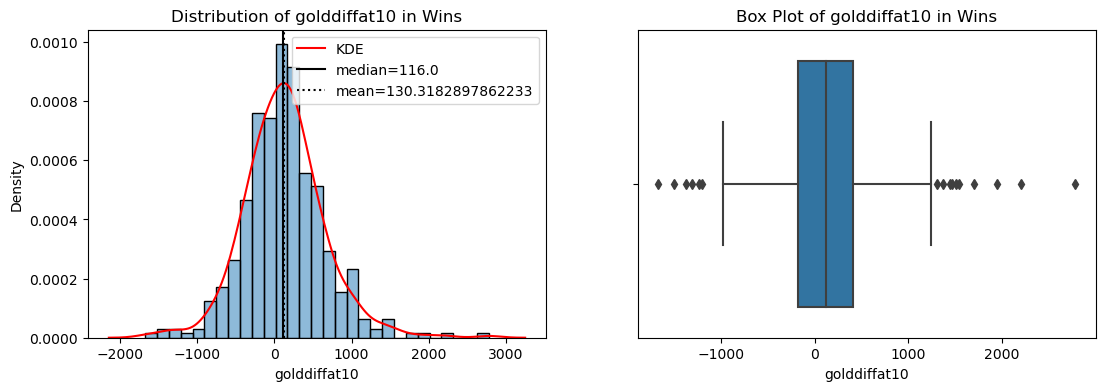

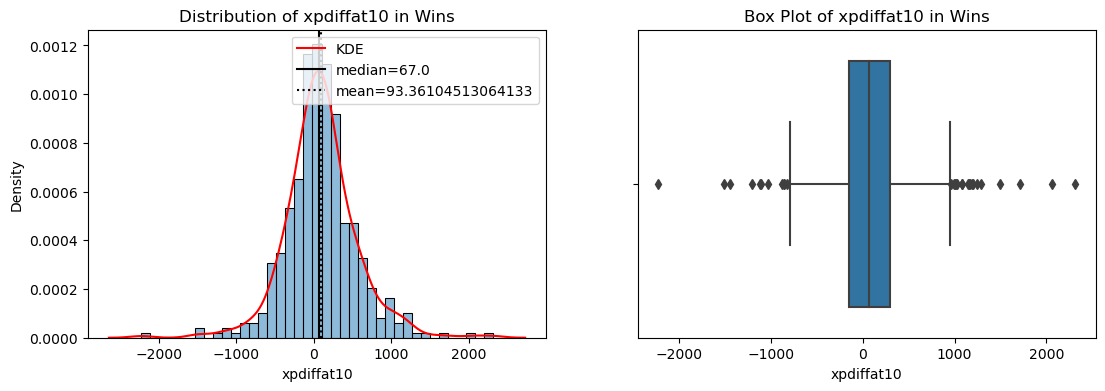

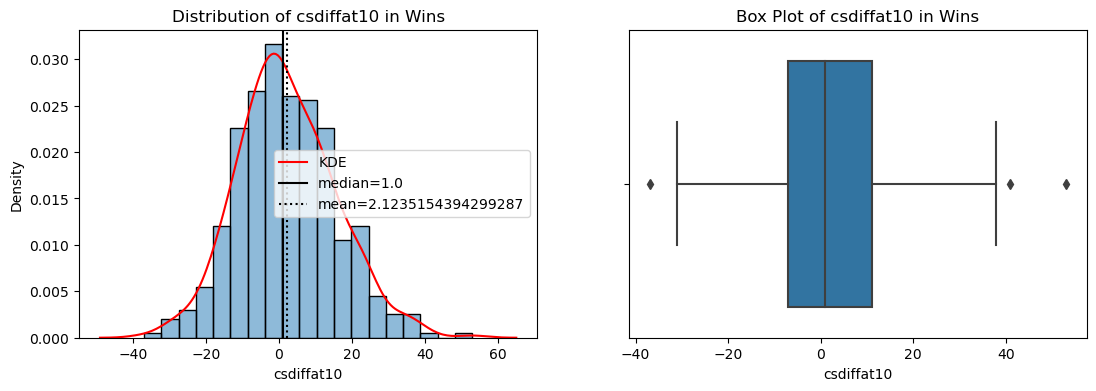

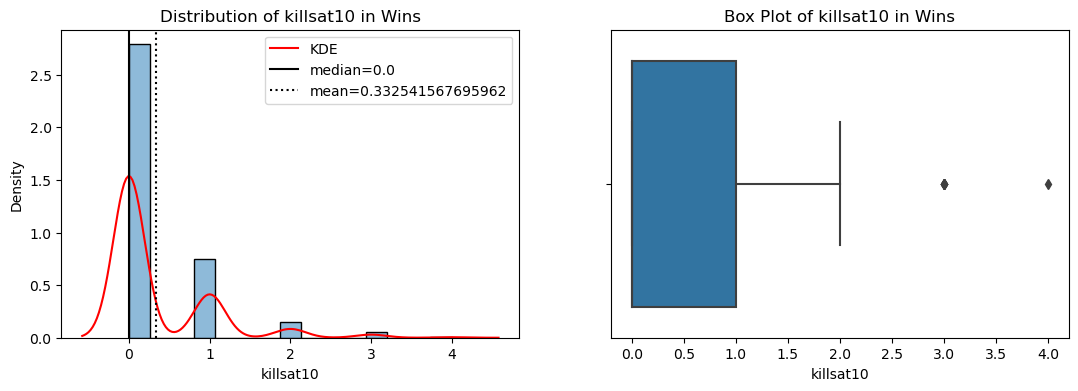

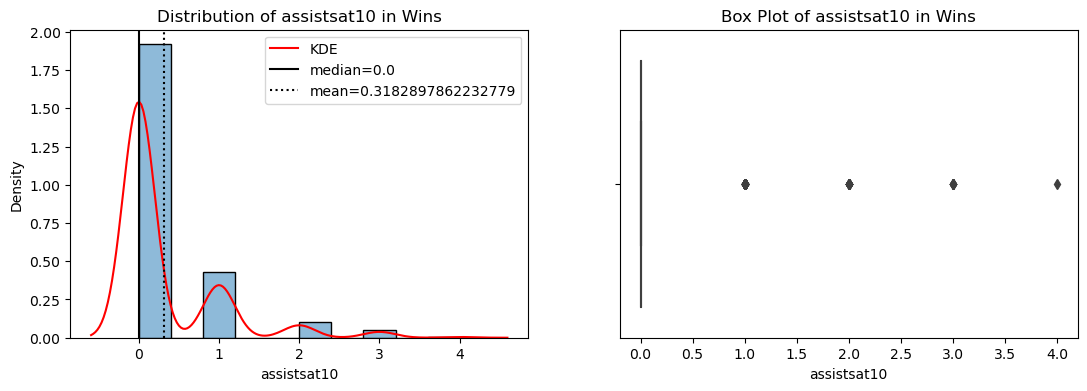

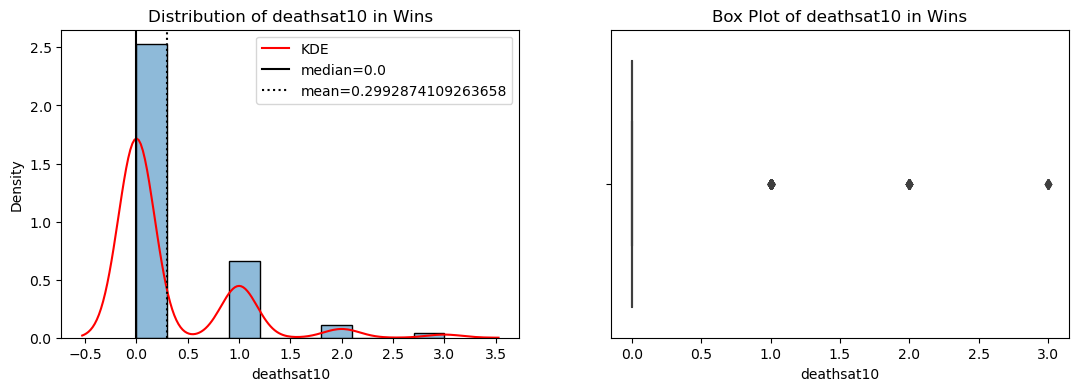

In [41]:
for column in top.columns[4:]:
    col = column
    hist_and_box(top, column)
    plt.savefig(F"./histograms and boxplots./top_{col}")

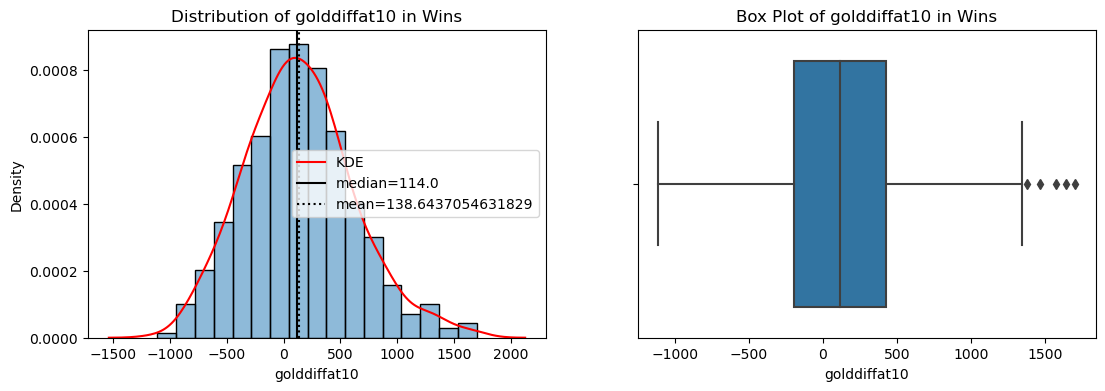

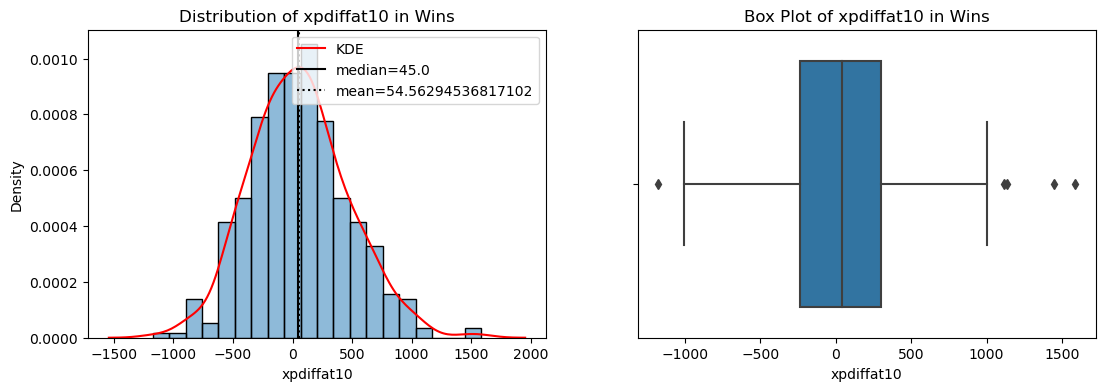

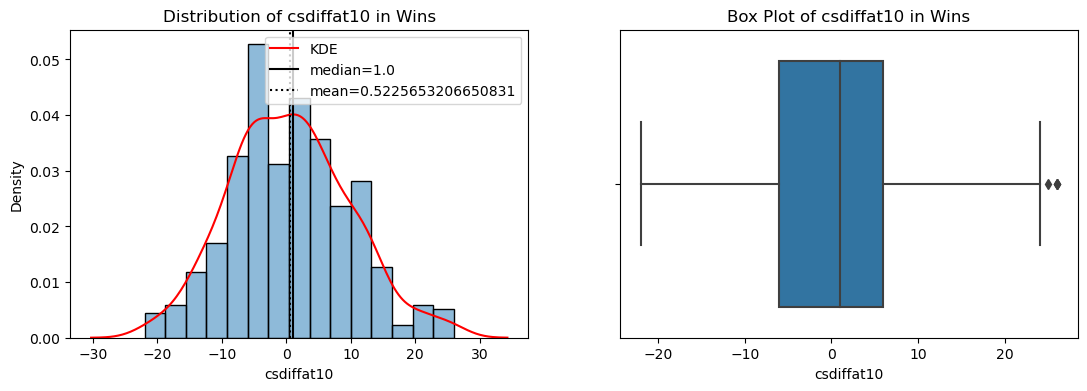

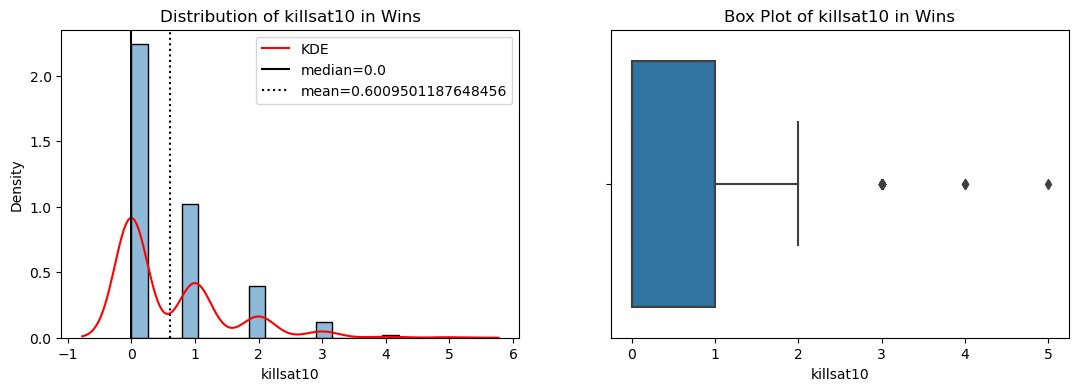

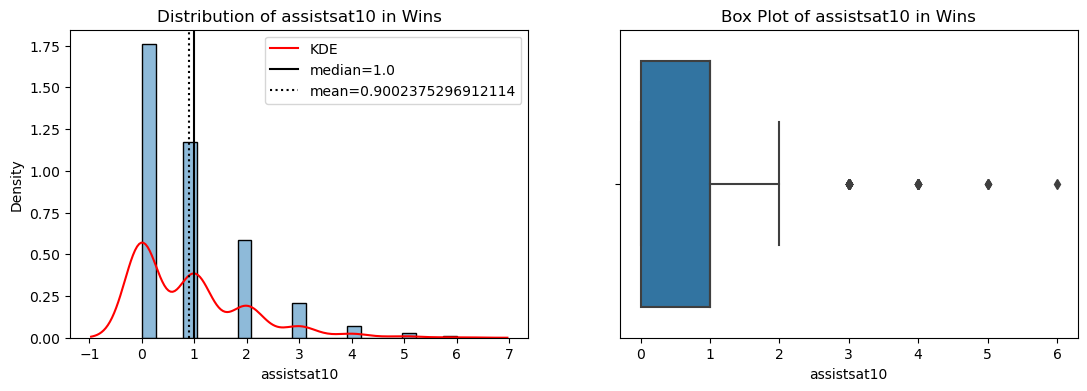

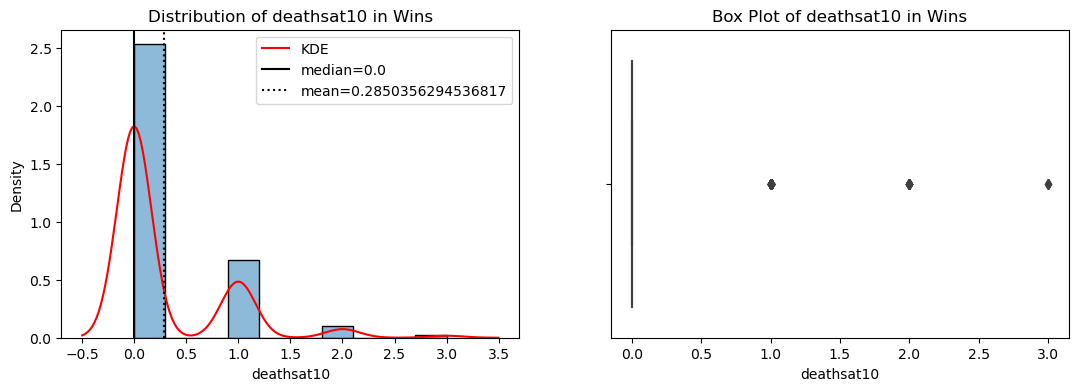

In [42]:
for column in jng.columns[4:]:
    col = column
    hist_and_box(jng, column)
    plt.savefig(F"./histograms and boxplots./jng_{col}")

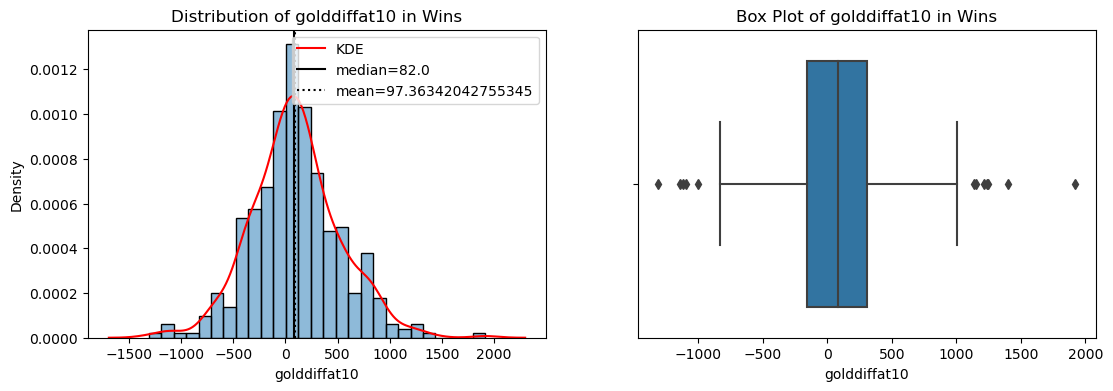

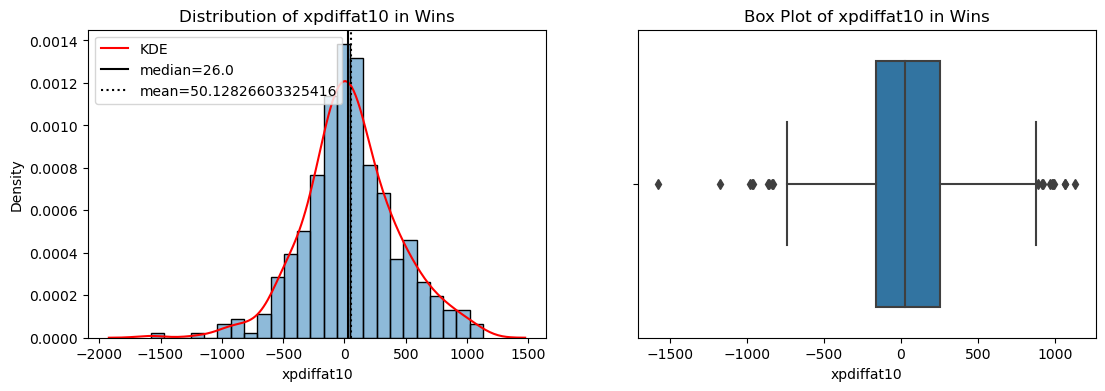

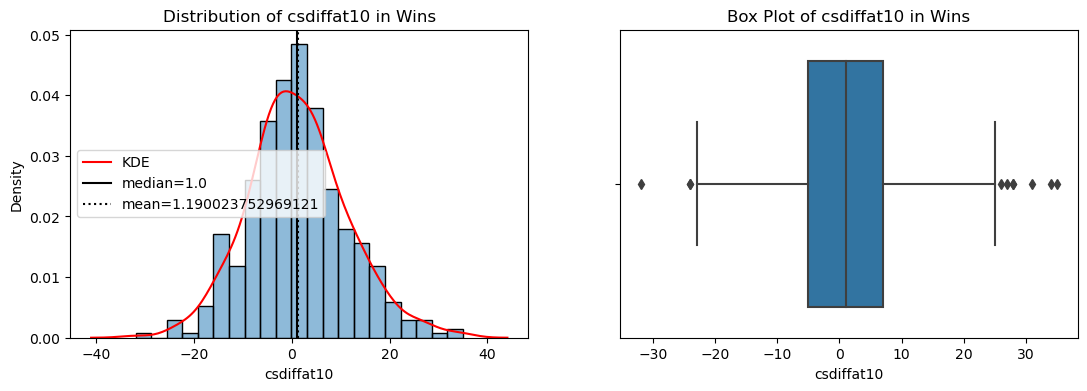

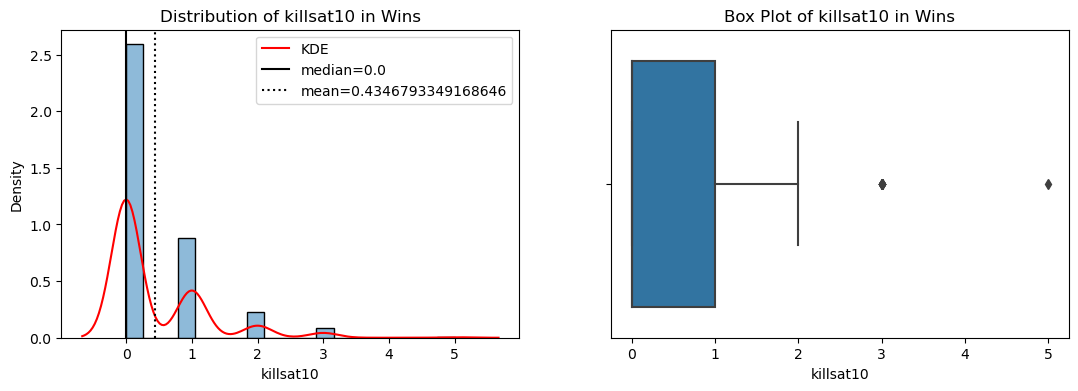

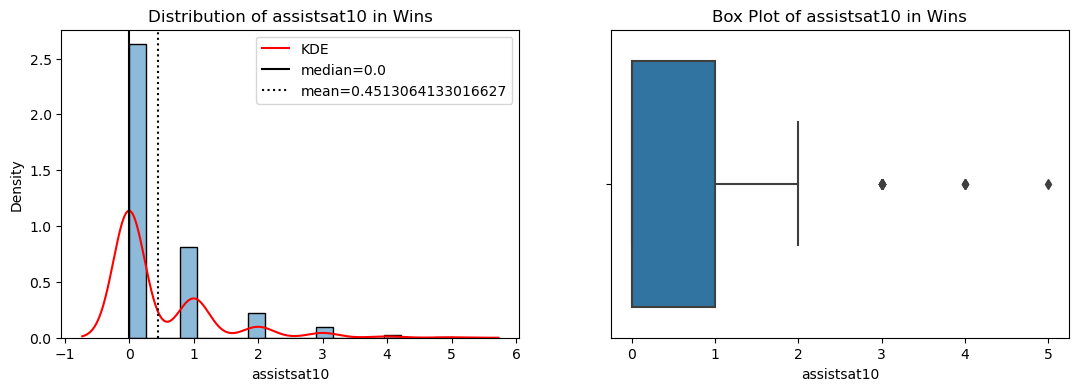

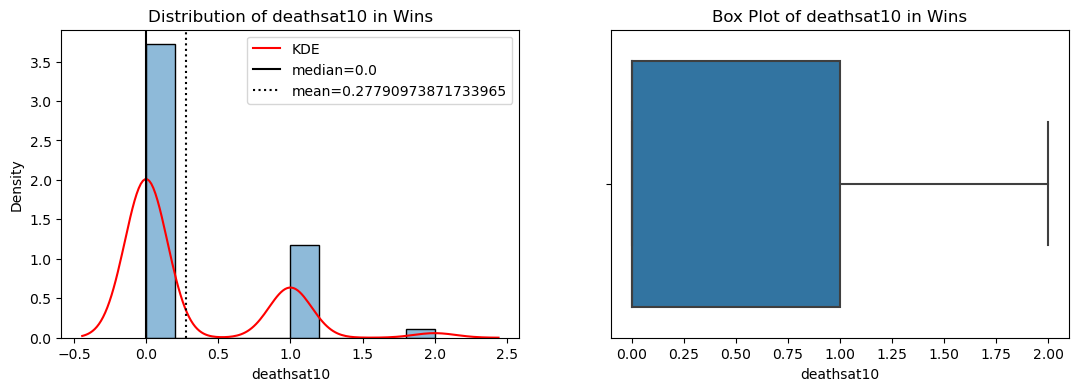

In [43]:
for column in mid.columns[4:]:
    col = column
    hist_and_box(mid, column)
    plt.savefig(F"./histograms and boxplots./mid_{col}")

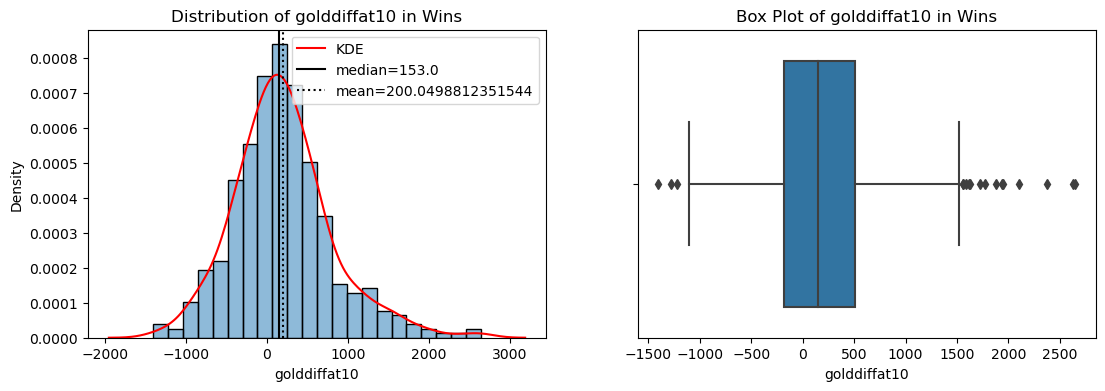

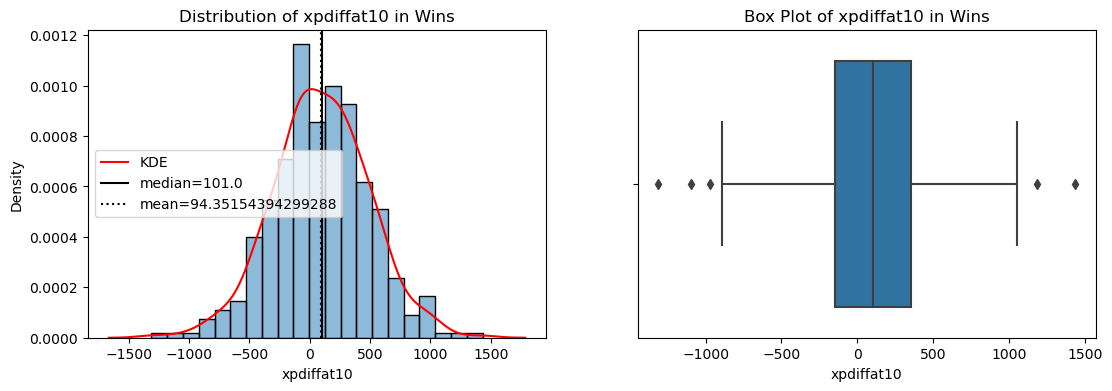

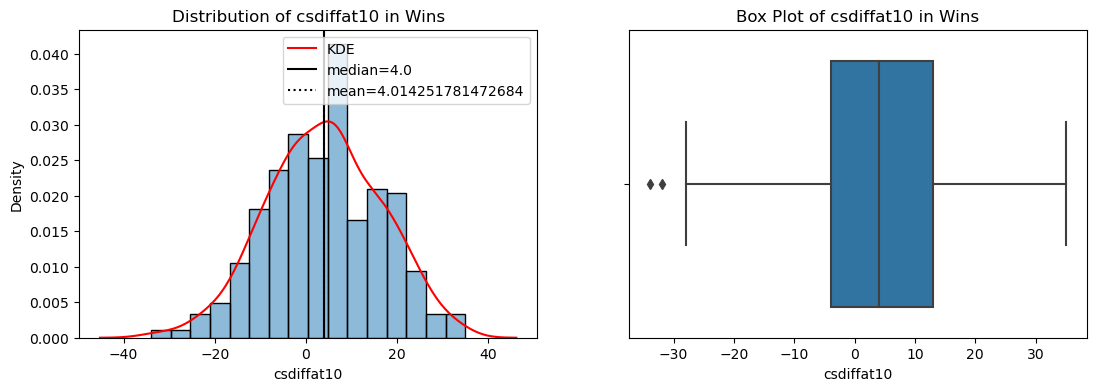

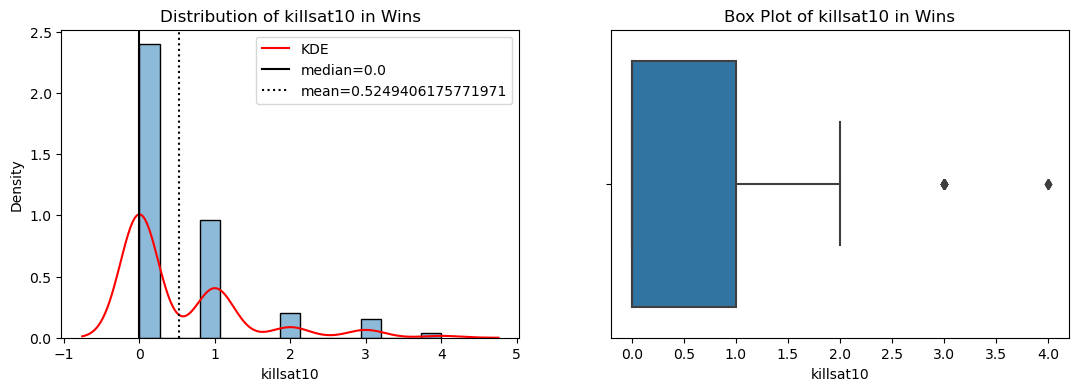

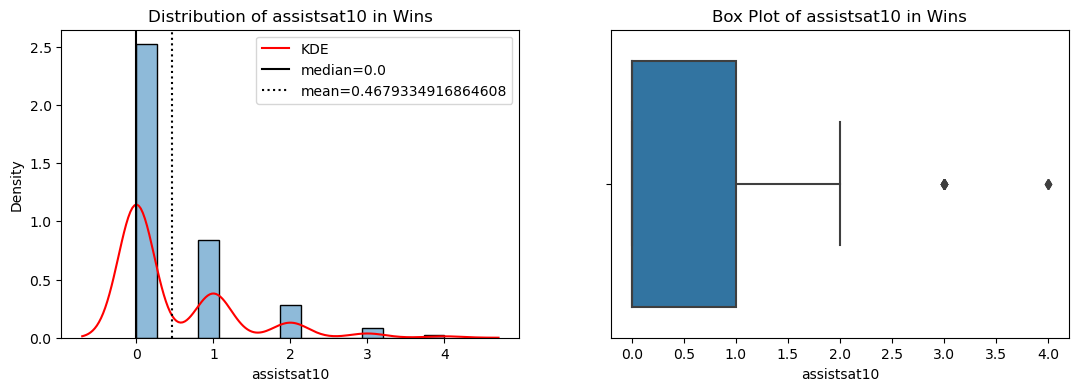

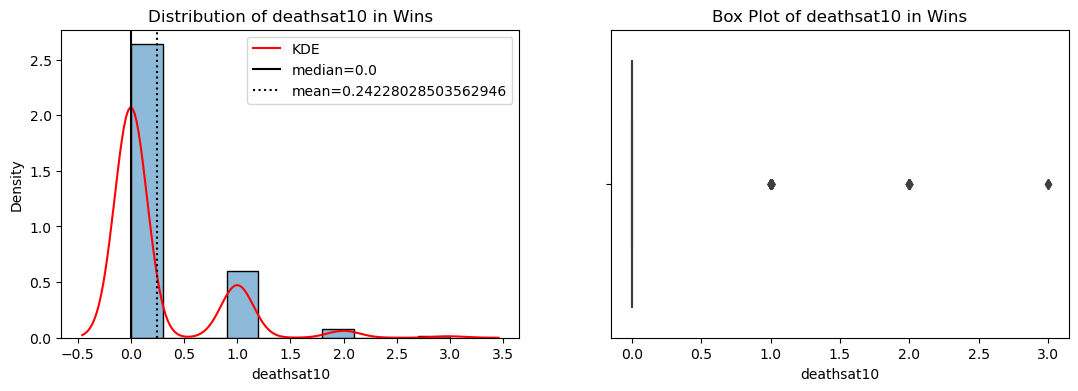

In [44]:
for column in bot.columns[4:]:
    col = column
    hist_and_box(bot, column)
    plt.savefig(F"./histograms and boxplots./bot_{col}")

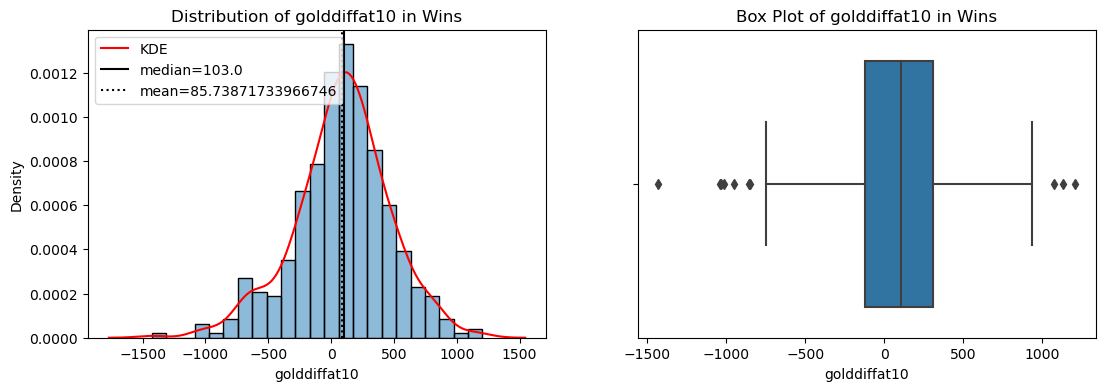

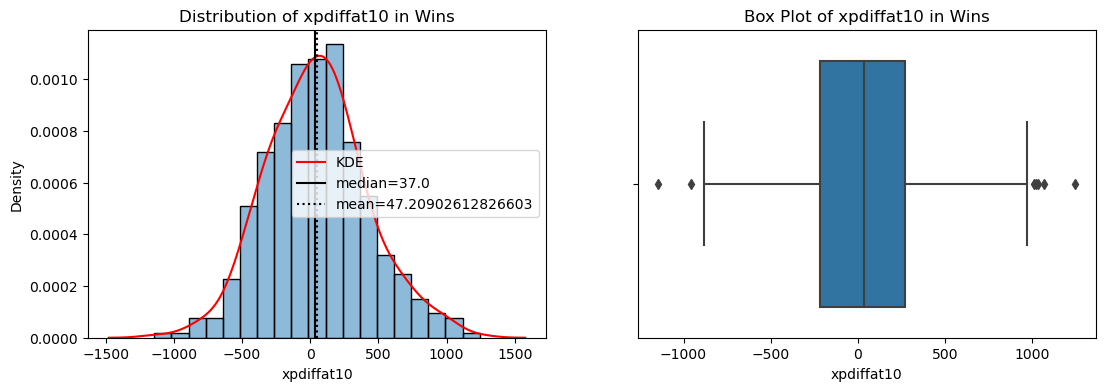

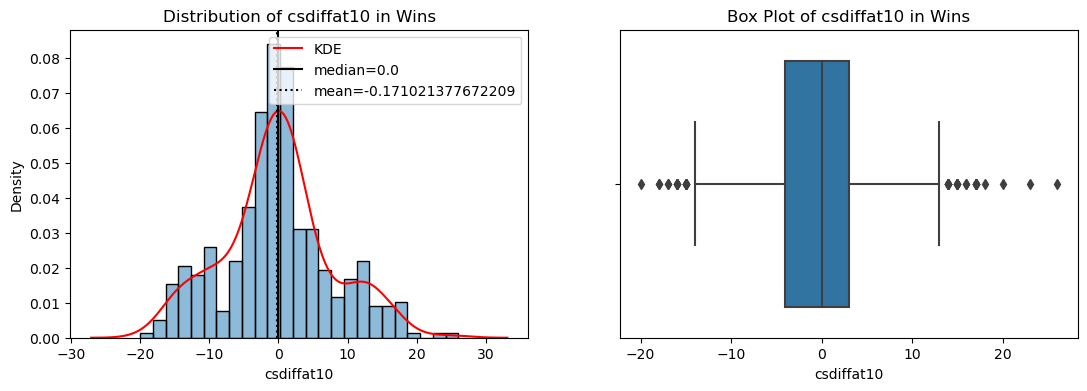

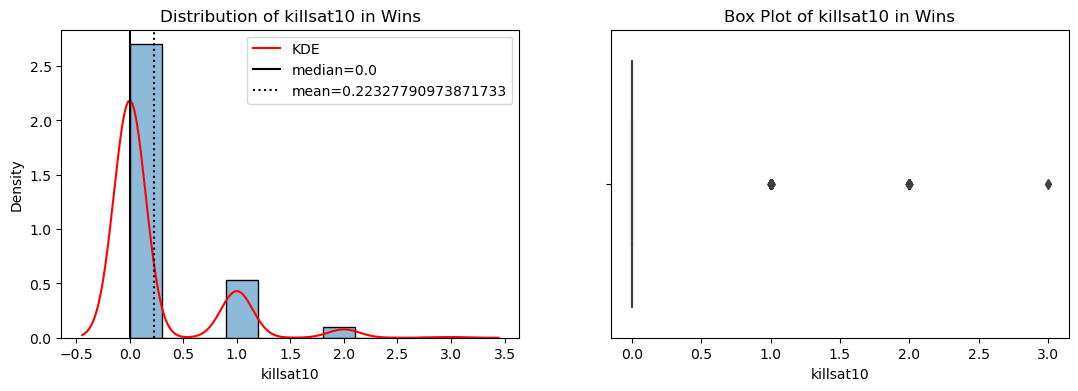

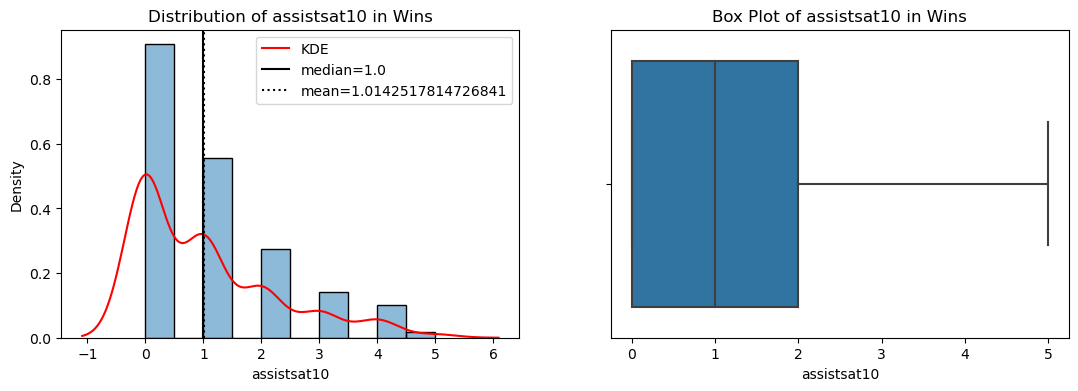

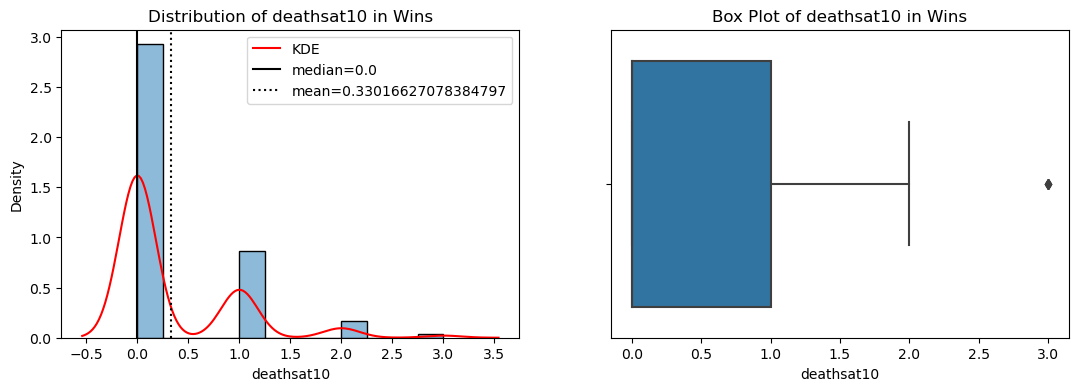

In [45]:
for column in sup.columns[4:]:
    col = column
    hist_and_box(sup, column)
    plt.savefig(F"./histograms and boxplots./sup_{col}")

Note: I will not be testing for specific outliers nor removing them. This could be a terrible idea, as removing outliers and high multicollinearity are key in creating accurate prediction models. However, there are multiple reasons as to why I decided against this.

1) We have 6 data frames we want to look at. Although we can, removing outliers and columns specific to each data frame is time-consuming. I want to get this project out in a reasonable amount of time.

2) We already have a small number of data and columns. Although there is an argument against keeping outliers in when we have few data points, I the outliers may be beneficial to the data. This leads to the third point:

3) League of Legends is a game with many, many factors. Outliers may be helpful, especially in this case with pro games, because these games have occurred naturally where each team is trying their hardest to win. Sometimes, games that are stomps happen. Putting them into the data and predicting with them may be helpful.

### Modeling

Note that I will not be tuning my models as well. Although I can, I want to get this project out in a reasonable amount of time. Thus, I will refrain from tuning my model (which can give wildly different results). If you are to do this project on your own, please tune the models!

In [46]:
from matplotlib.gridspec import GridSpec
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis, QuadraticDiscriminantAnalysis
from sklearn import metrics
from sklearn.inspection import permutation_importance
from xgboost import XGBRFClassifier

#### Standardize Data

In [47]:
def standardize_df(df, index):
    scaler = StandardScaler()
    return pd.concat([df.iloc[:, 0:index], pd.DataFrame(scaler.fit_transform(df.iloc[:,index:]), columns = df.iloc[:,index:].columns)], axis = 1)

In [48]:
# standardize numeric columns for top, jungle, mid, bot, support
for key in [key for key in lanes.keys() if key not in ["team"]]:
    lanes[key] = standardize_df(lanes[key], 4)

In [49]:
# standardize numeric columns for team
for key in [key for key in lanes.keys() if key in ["team"]]:
    lanes[key] = standardize_df(lanes[key], 6)

In [50]:
top, jng, mid, bot, sup, team = copy_over()

#### Separating the predictors and outcome variables

In [51]:
xtop, ytop = top.iloc[:, 1:], top["result"]

In [52]:
xjng, yjng = jng.iloc[:, 1:], jng["result"]

In [53]:
xmid, ymid = mid.iloc[:, 1:], mid["result"]

In [54]:
xbot, ybot = bot.iloc[:, 1:], bot["result"]

In [55]:
xsup, ysup = sup.iloc[:, 1:], sup["result"]

In [56]:
xteam, yteam = team.iloc[:, 1:], team["result"]

#### Splitting Data 80/20

In [57]:
xtop_train, xtop_test, ytop_train, ytop_test = train_test_split(xtop, ytop, test_size = 0.2, random_state = 213)

In [58]:
xjng_train, xjng_test, yjng_train, yjng_test = train_test_split(xjng, yjng, test_size = 0.2, random_state = 213)

In [59]:
xmid_train, xmid_test, ymid_train, ymid_test = train_test_split(xmid, ymid, test_size = 0.2, random_state = 213)

In [60]:
xbot_train, xbot_test, ybot_train, ybot_test = train_test_split(xbot, ybot, test_size = 0.2, random_state = 213)

In [61]:
xsup_train, xsup_test, ysup_train, ysup_test = train_test_split(xsup, ysup, test_size = 0.2, random_state = 213)

In [62]:
xteam_train, xteam_test, yteam_train, yteam_test = train_test_split(xteam, yteam, test_size = 0.2, random_state = 213)

#### Create Function to help with Modeling

In [63]:
# prints out a model's classification report, confusion matrix, and AUCROC curve
def evlaulate_model(model, xtrain, ytrain, xtest, ytest, digits = 4, title = "Data", folderpath = "./"):
    
    # get predictions
    yhattrain = model.predict(xtrain)
    yhattest = model.predict(xtest)

    # Classification Reports
    
    print("CLASSIFICATION REPORT FOR TRAINING DATA")
    print(metrics.classification_report(ytrain, yhattrain, digits = digits))
    
    print("CLASSIFICATION REPORT FOR TEST DATA")
    print(metrics.classification_report(ytest, yhattest, digits = digits))
    
    # make confusion matrix
    cmat = metrics.confusion_matrix(ytest, yhattest)
    
    fig = plt.figure(figsize=(13, 13))
    gs = GridSpec(nrows=2, ncols=2)

    ax0 = fig.add_subplot(gs[0, 0])
    ax1 = fig.add_subplot(gs[1, 0])
    ax2 = fig.add_subplot(gs[:, 1])
    
    # show confusion matrix
    sns.heatmap(cmat, ax = ax0, annot = True, cmap = "Blues")
    ax0.set_xlabel("Predicted Wins")
    ax0.set_ylabel("Actual Wins")
    ax0.set_title("Confusion Matrix For " + title)
    
    # show ROC curve
    yhat_prob = model.predict_proba(xtest)[::,1]
    fpr, tpr, _ = metrics.roc_curve(ytest,  yhat_prob)
    auc = metrics.roc_auc_score(ytest, yhat_prob)
    ax2.grid()
    ax2.plot(fpr, tpr, label = "Model Auc = " + str(auc))
    ax2.set_ylabel("True Positive Rate")
    ax2.set_xlabel("False Positive Rate")
    ax2.set_title("ROC AUC Curve For " + title)
    ax2.legend(loc = 4)
    
    # show importance plot
    permutation_results = permutation_importance(model, xtrain, ytrain)
    sorted_indices = permutation_results.importances_mean.argsort()
    ax1.barh(xtrain.columns[sorted_indices], permutation_results.importances[sorted_indices].mean(axis = 1).T)
    ax1.set_title("Permutation Importance For " + title)
    plt.savefig(folderpath + title + ".png")
    plt.show()

In [64]:
# fits model on training data and displays everything from evalulate_model function
def fit_eval(model, xtrain, ytrain, xtest, ytest, digits = 4, title = "Data", folderpath = "./"):
    model.fit(xtrain, ytrain)
    evlaulate_model(model, xtrain, ytrain, xtest, ytest, digits = 4, title = title, folderpath = folderpath)
    return model

In [65]:
# create dataframe to store scores
df_scores = pd.DataFrame(columns = ["Model", "Lane", "Accuracy", "AUCROC"])

#### Logistic Regression

CLASSIFICATION REPORT FOR TRAINING DATA
              precision    recall  f1-score   support

           0     0.6300    0.6149    0.6224       335
           1     0.6272    0.6420    0.6345       338

    accuracy                         0.6285       673
   macro avg     0.6286    0.6285    0.6284       673
weighted avg     0.6286    0.6285    0.6285       673

CLASSIFICATION REPORT FOR TEST DATA
              precision    recall  f1-score   support

           0     0.6310    0.6163    0.6235        86
           1     0.6118    0.6265    0.6190        83

    accuracy                         0.6213       169
   macro avg     0.6214    0.6214    0.6213       169
weighted avg     0.6215    0.6213    0.6213       169



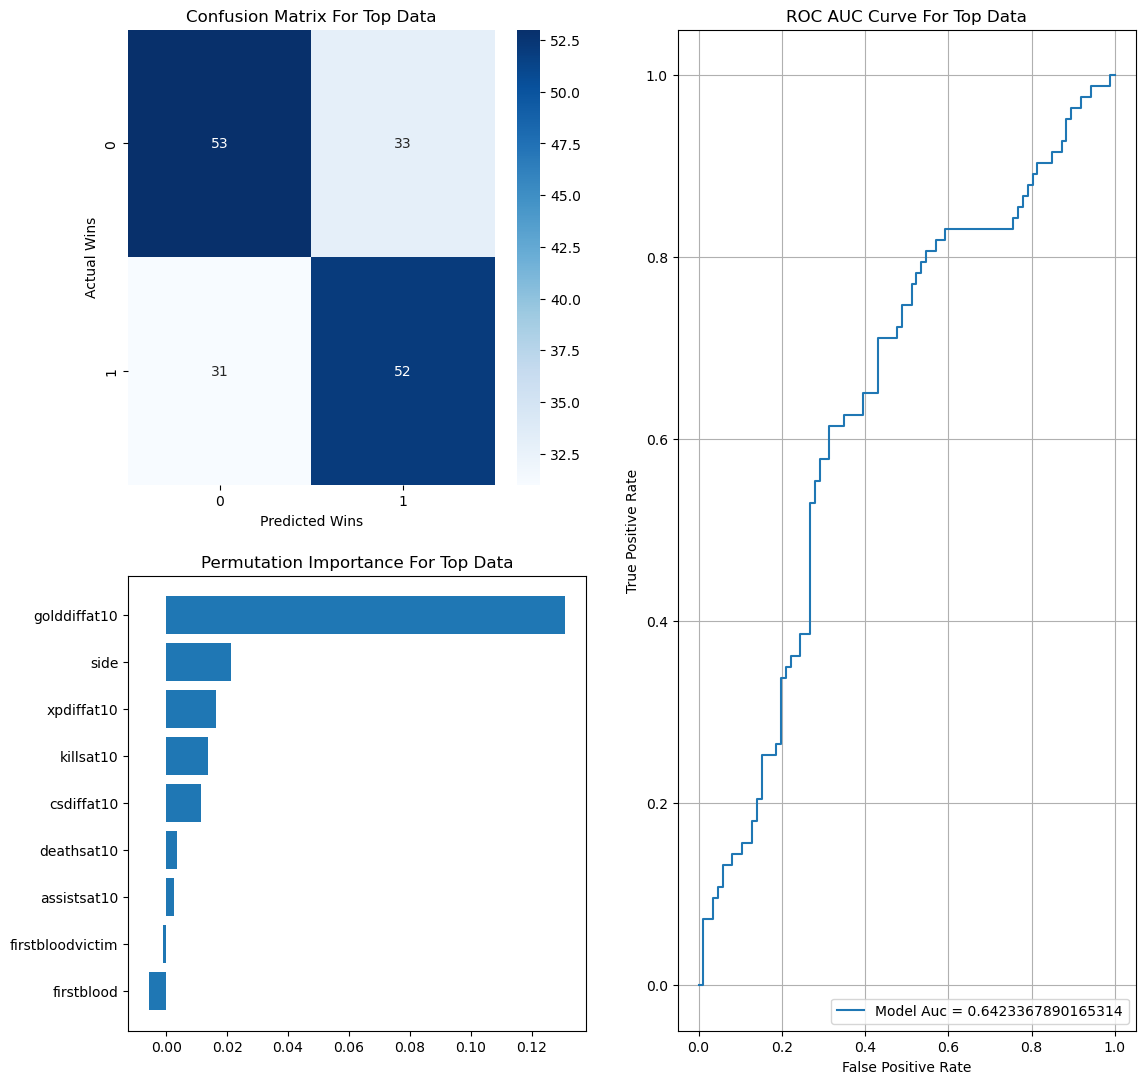

LogisticRegression(random_state=213)

In [66]:
fit_eval(LogisticRegression(random_state = 213), xtop_train, ytop_train, xtop_test, ytop_test, title = "Top Data", folderpath = "./LR./")

CLASSIFICATION REPORT FOR TRAINING DATA
              precision    recall  f1-score   support

           0     0.6287    0.6418    0.6352       335
           1     0.6375    0.6243    0.6308       338

    accuracy                         0.6330       673
   macro avg     0.6331    0.6330    0.6330       673
weighted avg     0.6331    0.6330    0.6330       673

CLASSIFICATION REPORT FOR TEST DATA
              precision    recall  f1-score   support

           0     0.6753    0.6047    0.6380        86
           1     0.6304    0.6988    0.6629        83

    accuracy                         0.6509       169
   macro avg     0.6529    0.6517    0.6504       169
weighted avg     0.6533    0.6509    0.6502       169



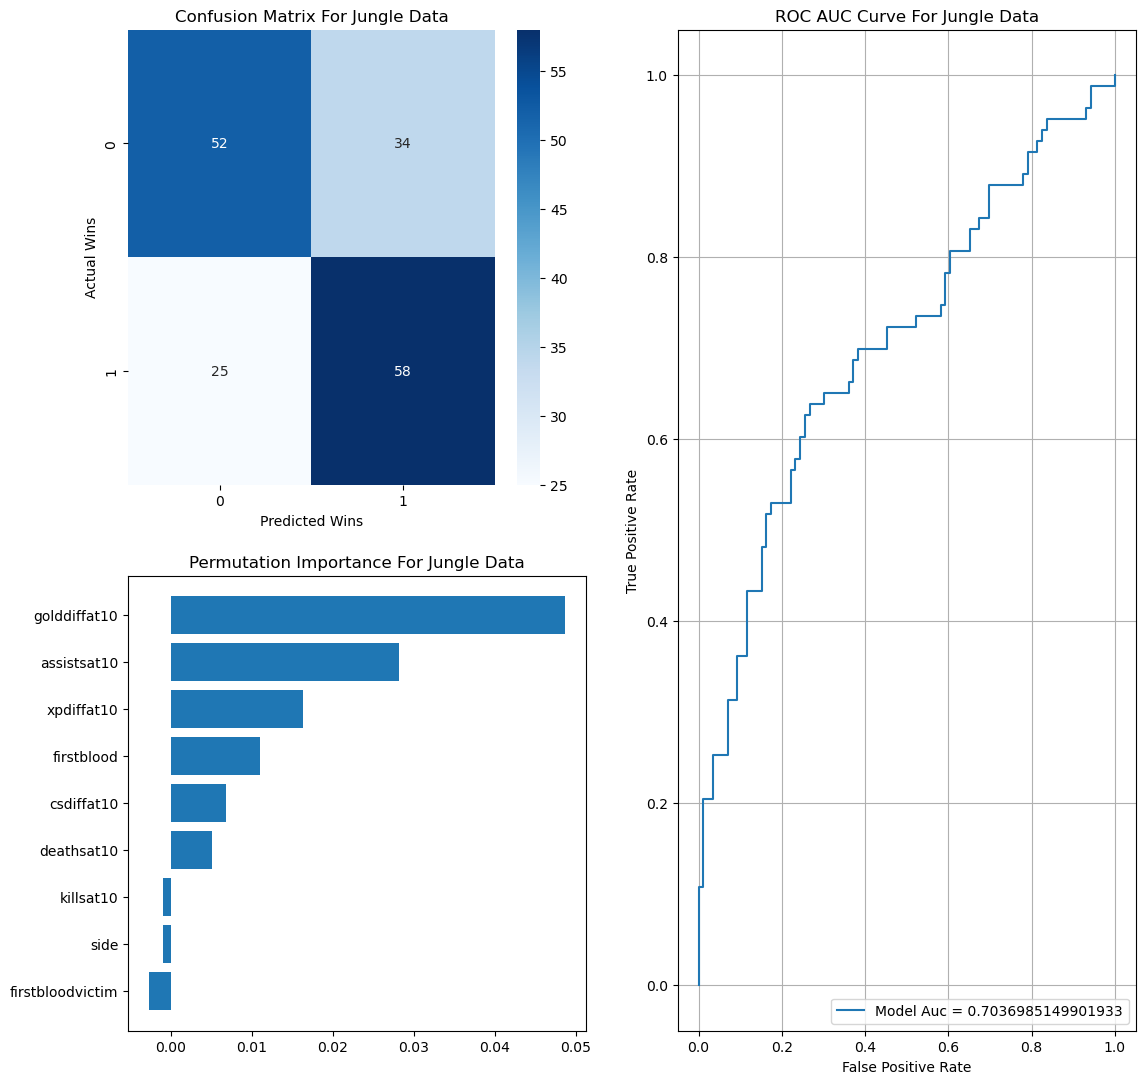

LogisticRegression(random_state=213)

In [67]:
fit_eval(LogisticRegression(random_state = 213), xjng_train, yjng_train, xjng_test, yjng_test, title = "Jungle Data", folderpath = "./LR./")

CLASSIFICATION REPORT FOR TRAINING DATA
              precision    recall  f1-score   support

           0     0.5934    0.5881    0.5907       335
           1     0.5953    0.6006    0.5979       338

    accuracy                         0.5944       673
   macro avg     0.5943    0.5943    0.5943       673
weighted avg     0.5943    0.5944    0.5943       673

CLASSIFICATION REPORT FOR TEST DATA
              precision    recall  f1-score   support

           0     0.5301    0.5116    0.5207        86
           1     0.5116    0.5301    0.5207        83

    accuracy                         0.5207       169
   macro avg     0.5209    0.5209    0.5207       169
weighted avg     0.5210    0.5207    0.5207       169



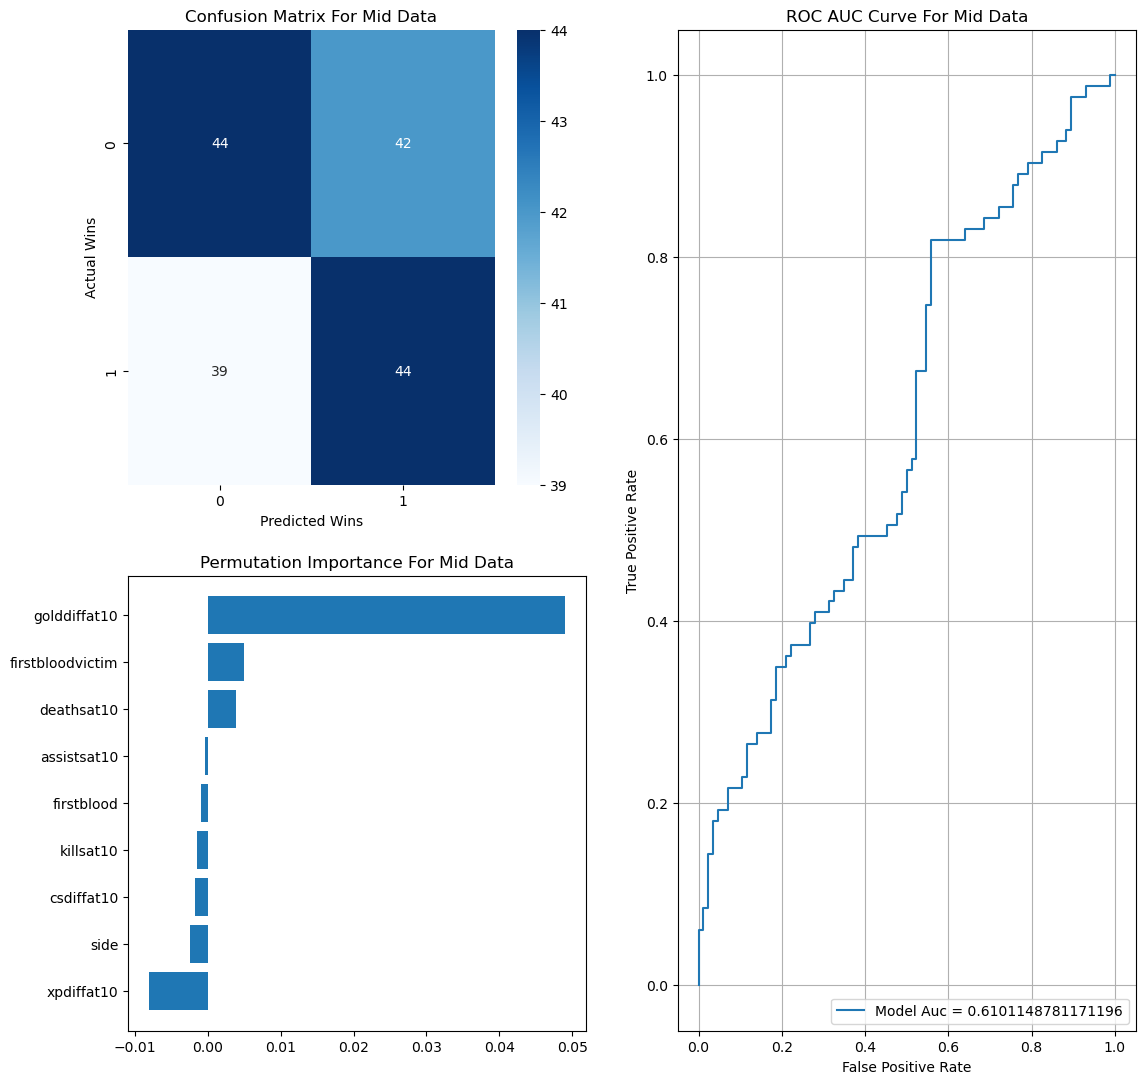

LogisticRegression(random_state=213)

In [68]:
fit_eval(LogisticRegression(random_state = 213), xmid_train, ymid_train, xmid_test, ymid_test, title = "Mid Data", folderpath = "./LR./")


CLASSIFICATION REPORT FOR TRAINING DATA
              precision    recall  f1-score   support

           0     0.6195    0.6269    0.6231       335
           1     0.6257    0.6183    0.6220       338

    accuracy                         0.6226       673
   macro avg     0.6226    0.6226    0.6226       673
weighted avg     0.6226    0.6226    0.6226       673

CLASSIFICATION REPORT FOR TEST DATA
              precision    recall  f1-score   support

           0     0.6707    0.6395    0.6548        86
           1     0.6437    0.6747    0.6588        83

    accuracy                         0.6568       169
   macro avg     0.6572    0.6571    0.6568       169
weighted avg     0.6574    0.6568    0.6568       169



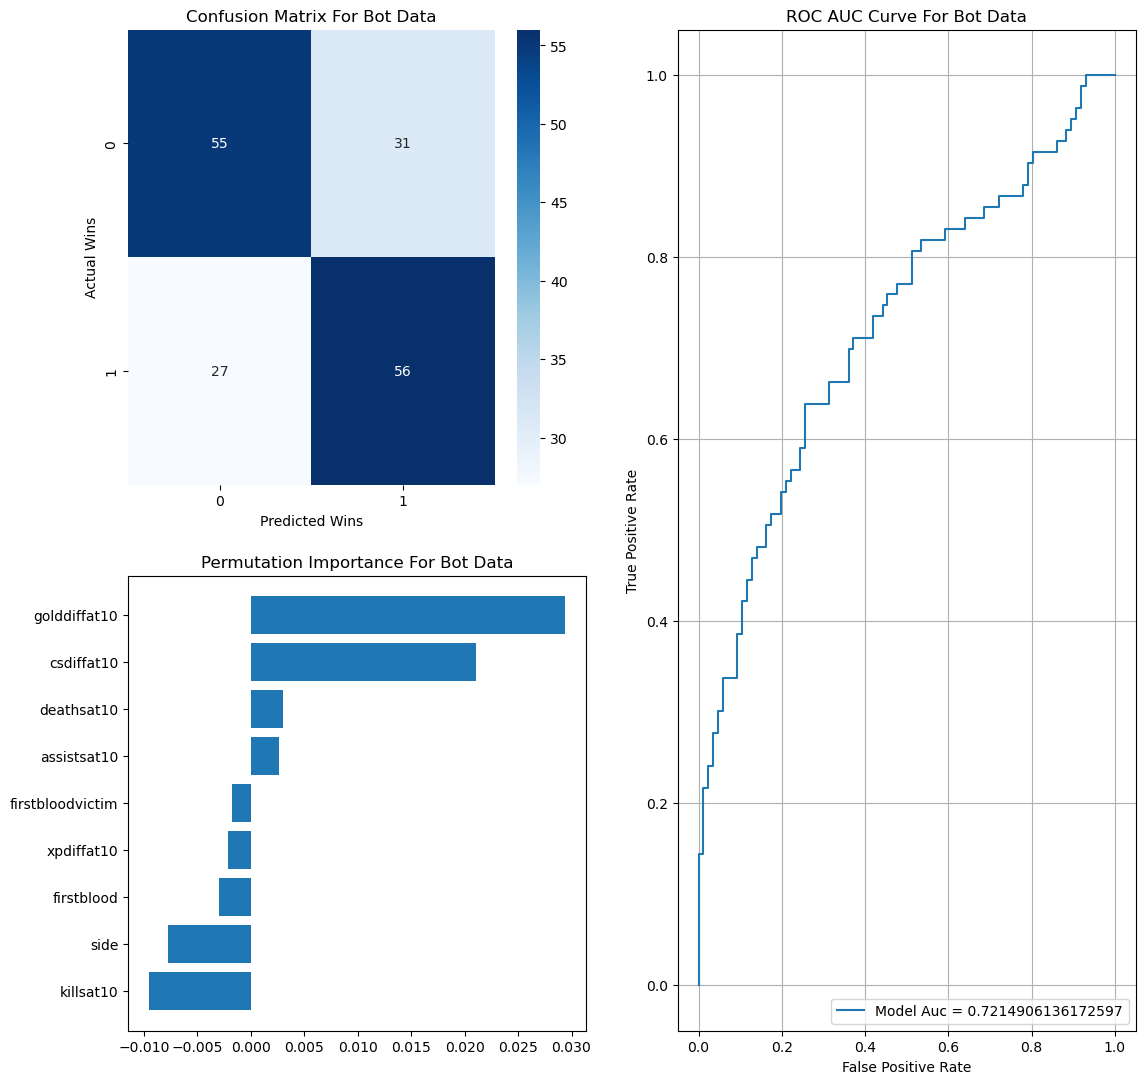

LogisticRegression(random_state=213)

In [69]:
fit_eval(LogisticRegression(random_state = 213), xbot_train, ybot_train, xbot_test, ybot_test, title = "Bot Data", folderpath = "./LR./")


CLASSIFICATION REPORT FOR TRAINING DATA
              precision    recall  f1-score   support

           0     0.6272    0.6328    0.6300       335
           1     0.6328    0.6272    0.6300       338

    accuracy                         0.6300       673
   macro avg     0.6300    0.6300    0.6300       673
weighted avg     0.6300    0.6300    0.6300       673

CLASSIFICATION REPORT FOR TEST DATA
              precision    recall  f1-score   support

           0     0.6471    0.6395    0.6433        86
           1     0.6310    0.6386    0.6347        83

    accuracy                         0.6391       169
   macro avg     0.6390    0.6390    0.6390       169
weighted avg     0.6391    0.6391    0.6391       169



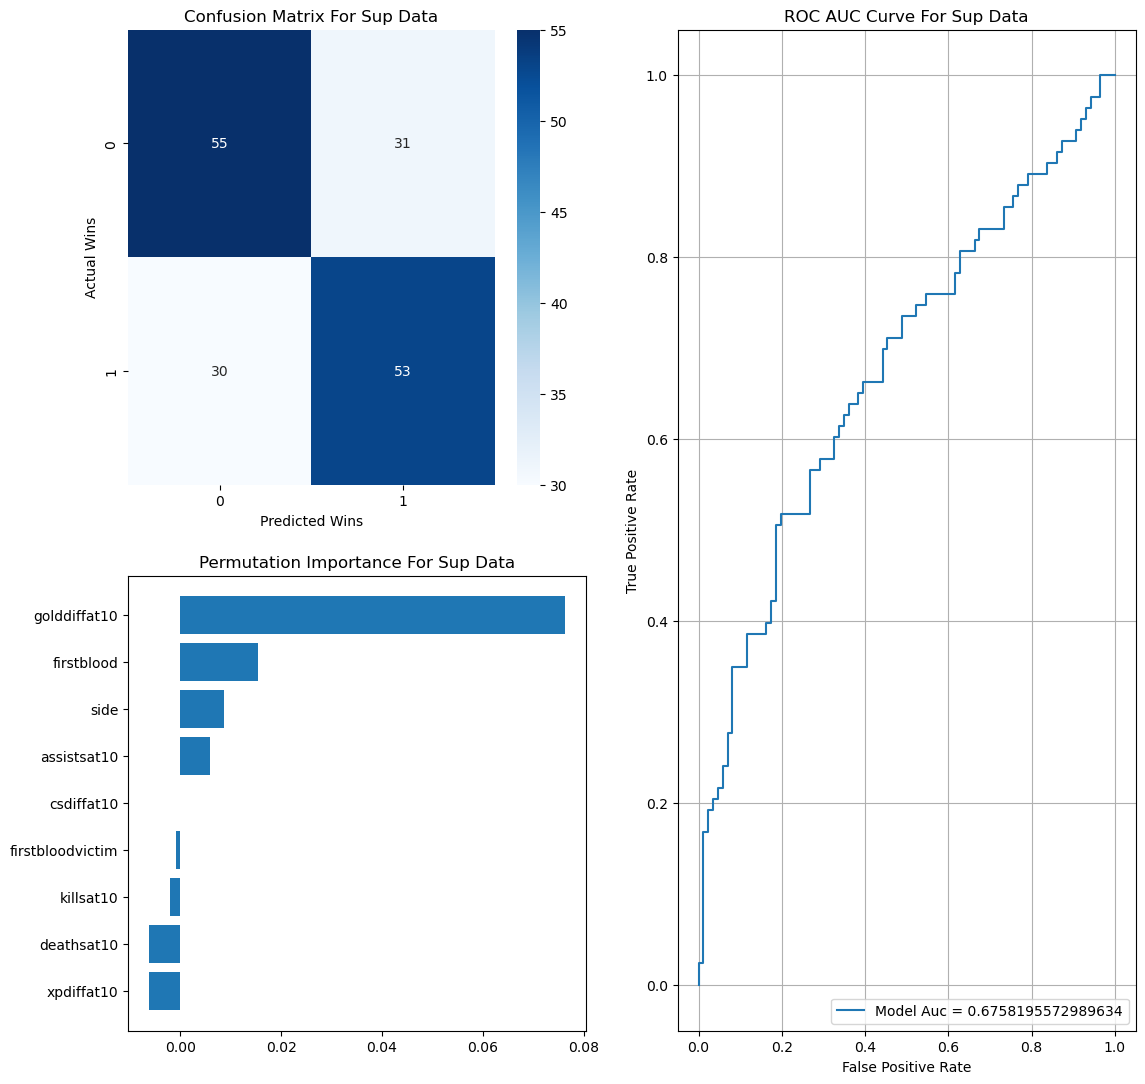

LogisticRegression(random_state=213)

In [70]:
fit_eval(LogisticRegression(random_state = 213), xsup_train, ysup_train, xsup_test, ysup_test, title = "Sup Data", folderpath = "./LR./")


CLASSIFICATION REPORT FOR TRAINING DATA
              precision    recall  f1-score   support

           0     0.7477    0.7343    0.7410       335
           1     0.7413    0.7544    0.7478       338

    accuracy                         0.7444       673
   macro avg     0.7445    0.7444    0.7444       673
weighted avg     0.7445    0.7444    0.7444       673

CLASSIFICATION REPORT FOR TEST DATA
              precision    recall  f1-score   support

           0     0.7204    0.7791    0.7486        86
           1     0.7500    0.6867    0.7170        83

    accuracy                         0.7337       169
   macro avg     0.7352    0.7329    0.7328       169
weighted avg     0.7350    0.7337    0.7331       169



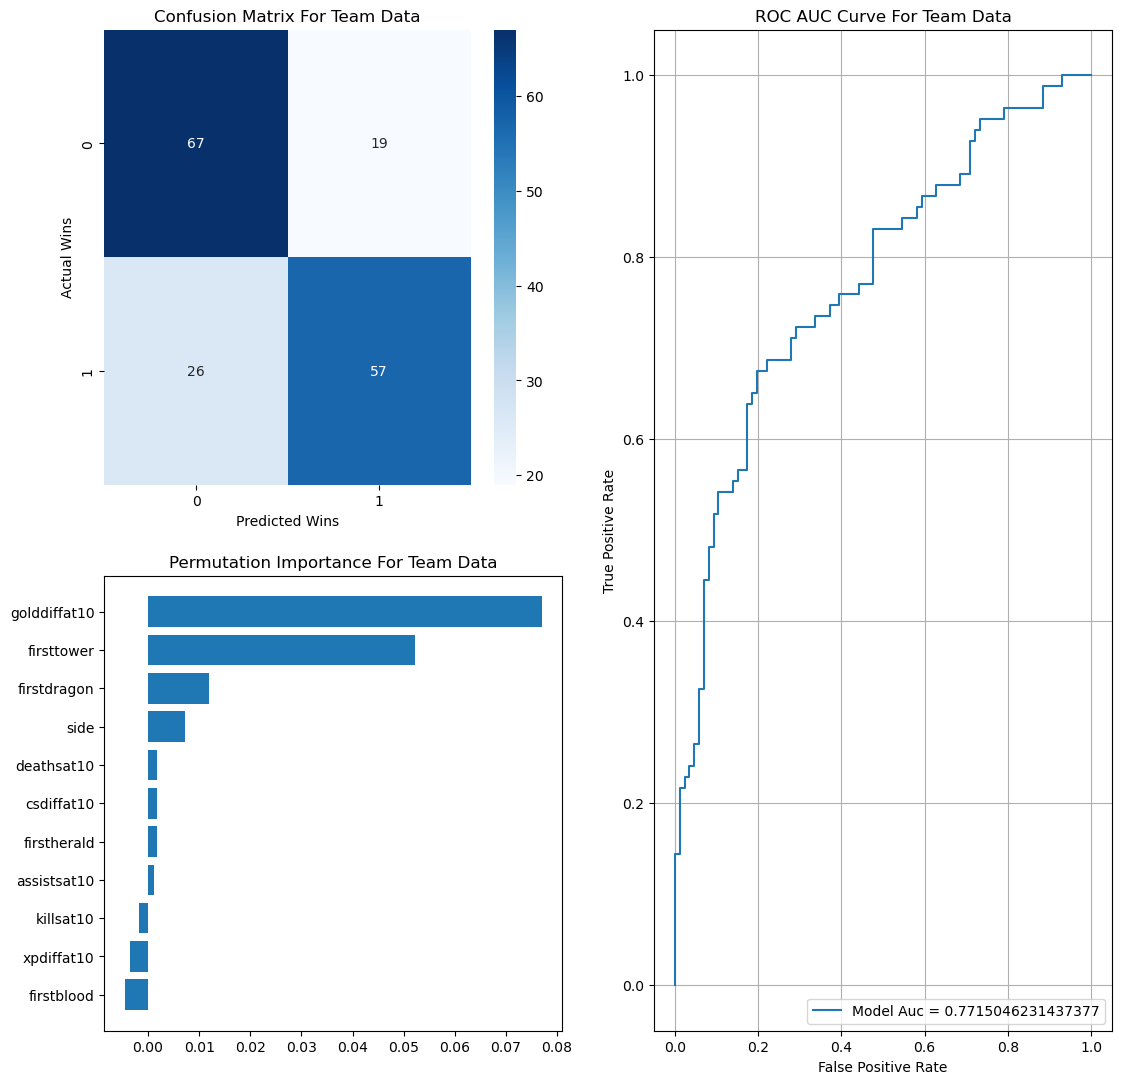

LogisticRegression(random_state=213)

In [71]:
fit_eval(LogisticRegression(random_state = 213), xteam_train, yteam_train, xteam_test, yteam_test, title = "Team Data", folderpath = "./LR./")


In [72]:
df_scores.loc[0] = ["Logistic Regression", "Top", 0.6173, 0.6168]
df_scores.loc[1] = ["Logistic Regression", "Jungle", 0.6618, 0.6674]
df_scores.loc[2] = ["Logistic Regression", "Middle", 0.6176, 0.6308]
df_scores.loc[3] = ["Logistic Regression", "Bottom", 0.6512, 0.7250]
df_scores.loc[4] = ["Logistic Regression", "Support", 0.6328, 0.6576]
df_scores.loc[5] = ["Logistic Regression", "Team", 0.7578, 0.8037]

#### Random Forest

CLASSIFICATION REPORT FOR TRAINING DATA
              precision    recall  f1-score   support

           0     1.0000    1.0000    1.0000       335
           1     1.0000    1.0000    1.0000       338

    accuracy                         1.0000       673
   macro avg     1.0000    1.0000    1.0000       673
weighted avg     1.0000    1.0000    1.0000       673

CLASSIFICATION REPORT FOR TEST DATA
              precision    recall  f1-score   support

           0     0.5366    0.5116    0.5238        86
           1     0.5172    0.5422    0.5294        83

    accuracy                         0.5266       169
   macro avg     0.5269    0.5269    0.5266       169
weighted avg     0.5271    0.5266    0.5266       169



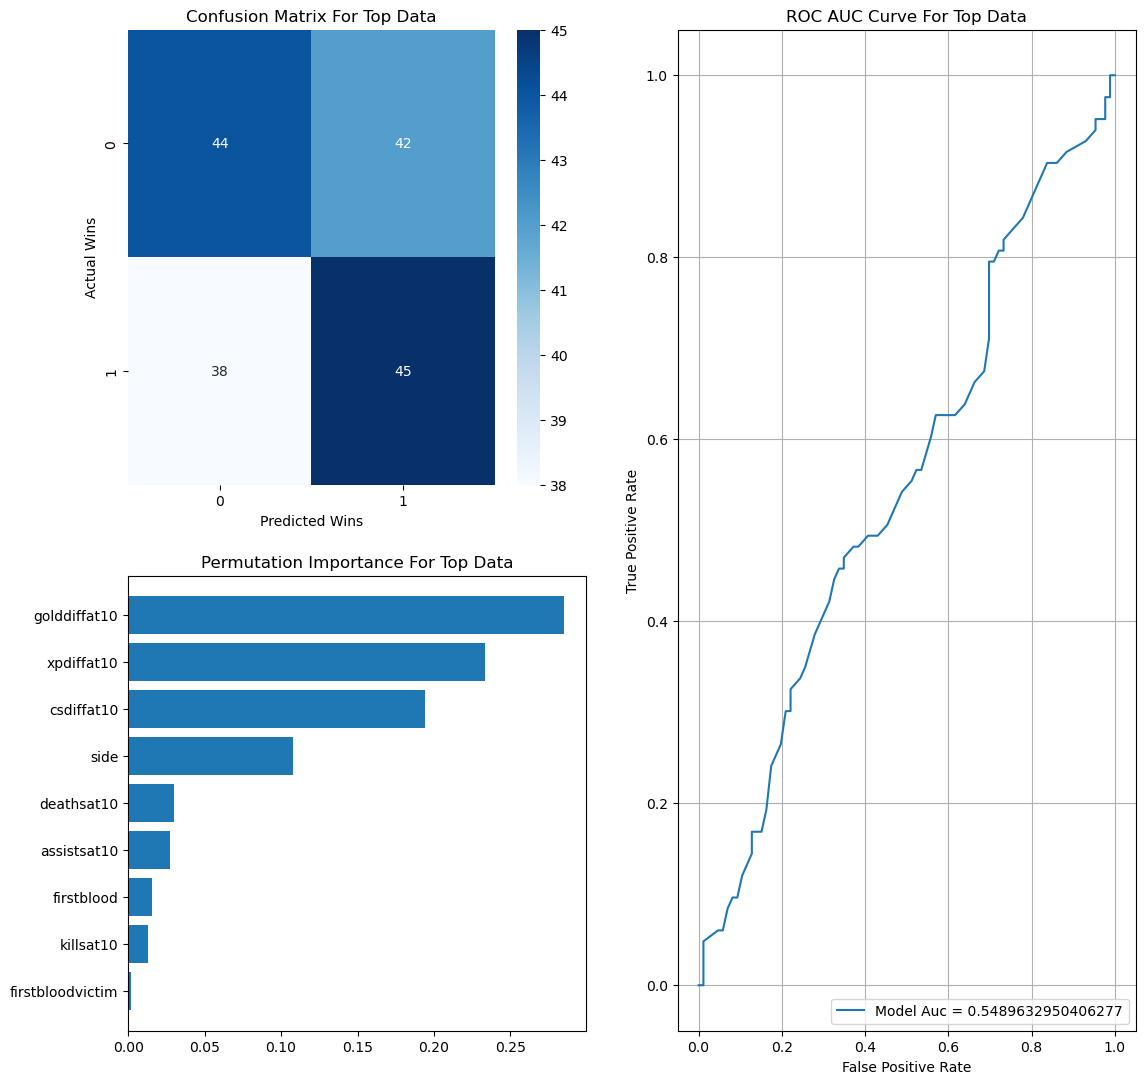

RandomForestClassifier(random_state=213)

In [73]:
fit_eval(RandomForestClassifier(random_state = 213), xtop_train, ytop_train, xtop_test, ytop_test, title = "Top Data", folderpath = "./RF./")

CLASSIFICATION REPORT FOR TRAINING DATA
              precision    recall  f1-score   support

           0     1.0000    1.0000    1.0000       335
           1     1.0000    1.0000    1.0000       338

    accuracy                         1.0000       673
   macro avg     1.0000    1.0000    1.0000       673
weighted avg     1.0000    1.0000    1.0000       673

CLASSIFICATION REPORT FOR TEST DATA
              precision    recall  f1-score   support

           0     0.6296    0.5930    0.6108        86
           1     0.6023    0.6386    0.6199        83

    accuracy                         0.6154       169
   macro avg     0.6160    0.6158    0.6153       169
weighted avg     0.6162    0.6154    0.6152       169



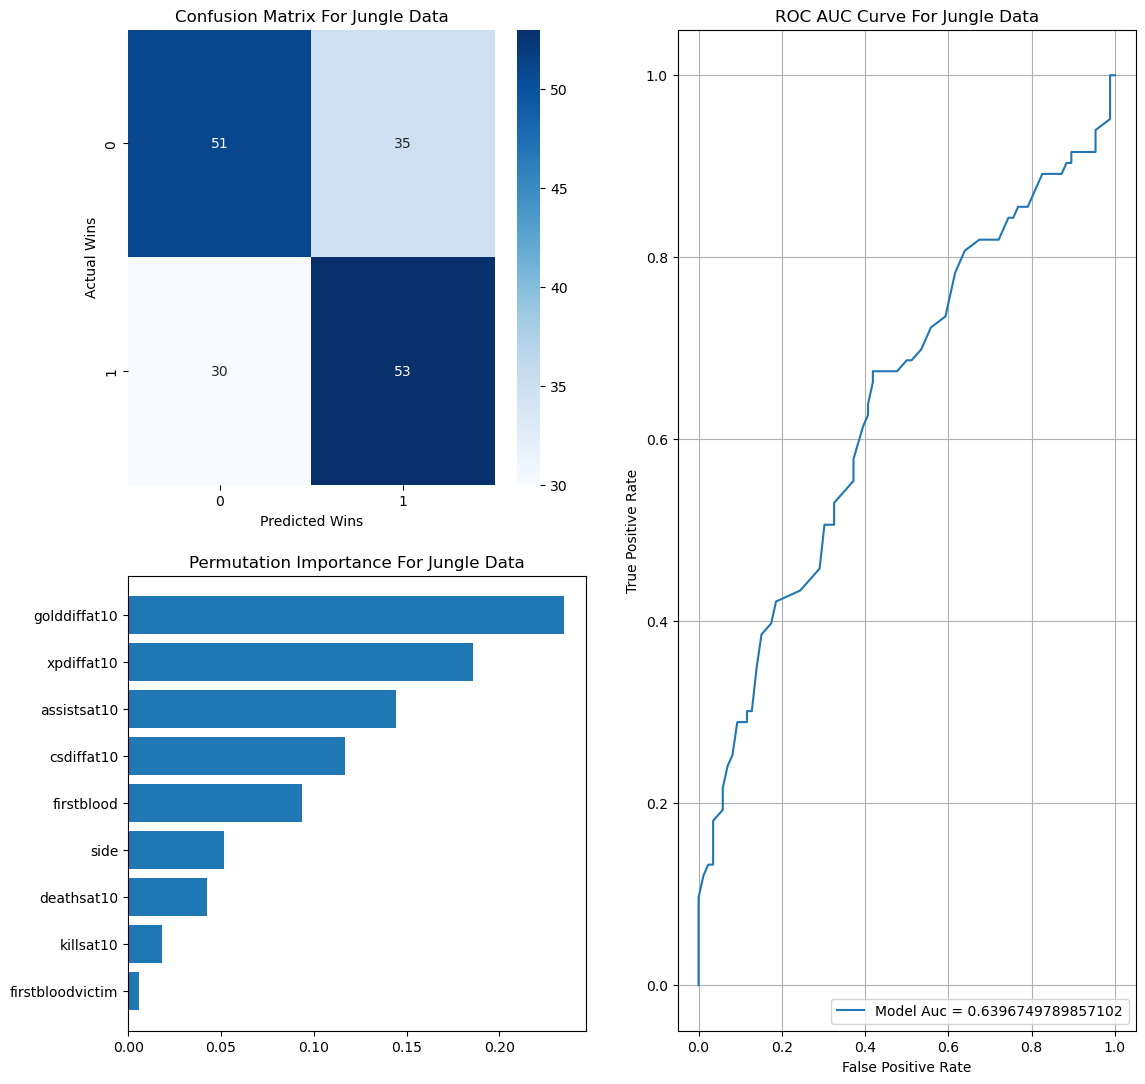

RandomForestClassifier(random_state=213)

In [74]:
fit_eval(RandomForestClassifier(random_state = 213), xjng_train, yjng_train, xjng_test, yjng_test, title = "Jungle Data", folderpath = "./RF./")

CLASSIFICATION REPORT FOR TRAINING DATA
              precision    recall  f1-score   support

           0     1.0000    1.0000    1.0000       335
           1     1.0000    1.0000    1.0000       338

    accuracy                         1.0000       673
   macro avg     1.0000    1.0000    1.0000       673
weighted avg     1.0000    1.0000    1.0000       673

CLASSIFICATION REPORT FOR TEST DATA
              precision    recall  f1-score   support

           0     0.5765    0.5698    0.5731        86
           1     0.5595    0.5663    0.5629        83

    accuracy                         0.5680       169
   macro avg     0.5680    0.5680    0.5680       169
weighted avg     0.5681    0.5680    0.5681       169



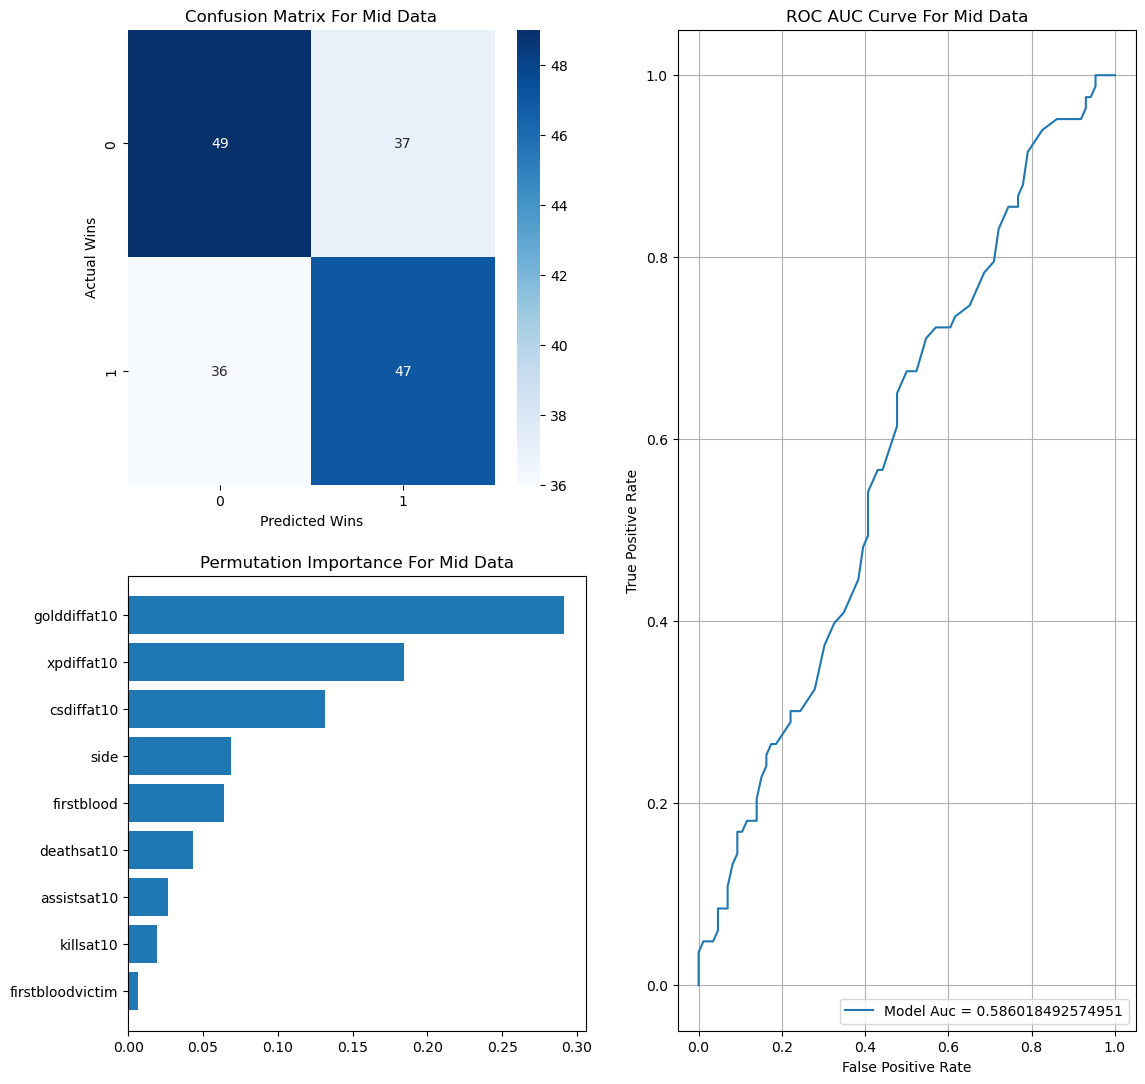

RandomForestClassifier(random_state=213)

In [75]:
fit_eval(RandomForestClassifier(random_state = 213), xmid_train, ymid_train, xmid_test, ymid_test, title = "Mid Data", folderpath = "./RF./")

CLASSIFICATION REPORT FOR TRAINING DATA
              precision    recall  f1-score   support

           0     1.0000    1.0000    1.0000       335
           1     1.0000    1.0000    1.0000       338

    accuracy                         1.0000       673
   macro avg     1.0000    1.0000    1.0000       673
weighted avg     1.0000    1.0000    1.0000       673

CLASSIFICATION REPORT FOR TEST DATA
              precision    recall  f1-score   support

           0     0.5422    0.5233    0.5325        86
           1     0.5233    0.5422    0.5325        83

    accuracy                         0.5325       169
   macro avg     0.5327    0.5327    0.5325       169
weighted avg     0.5329    0.5325    0.5325       169



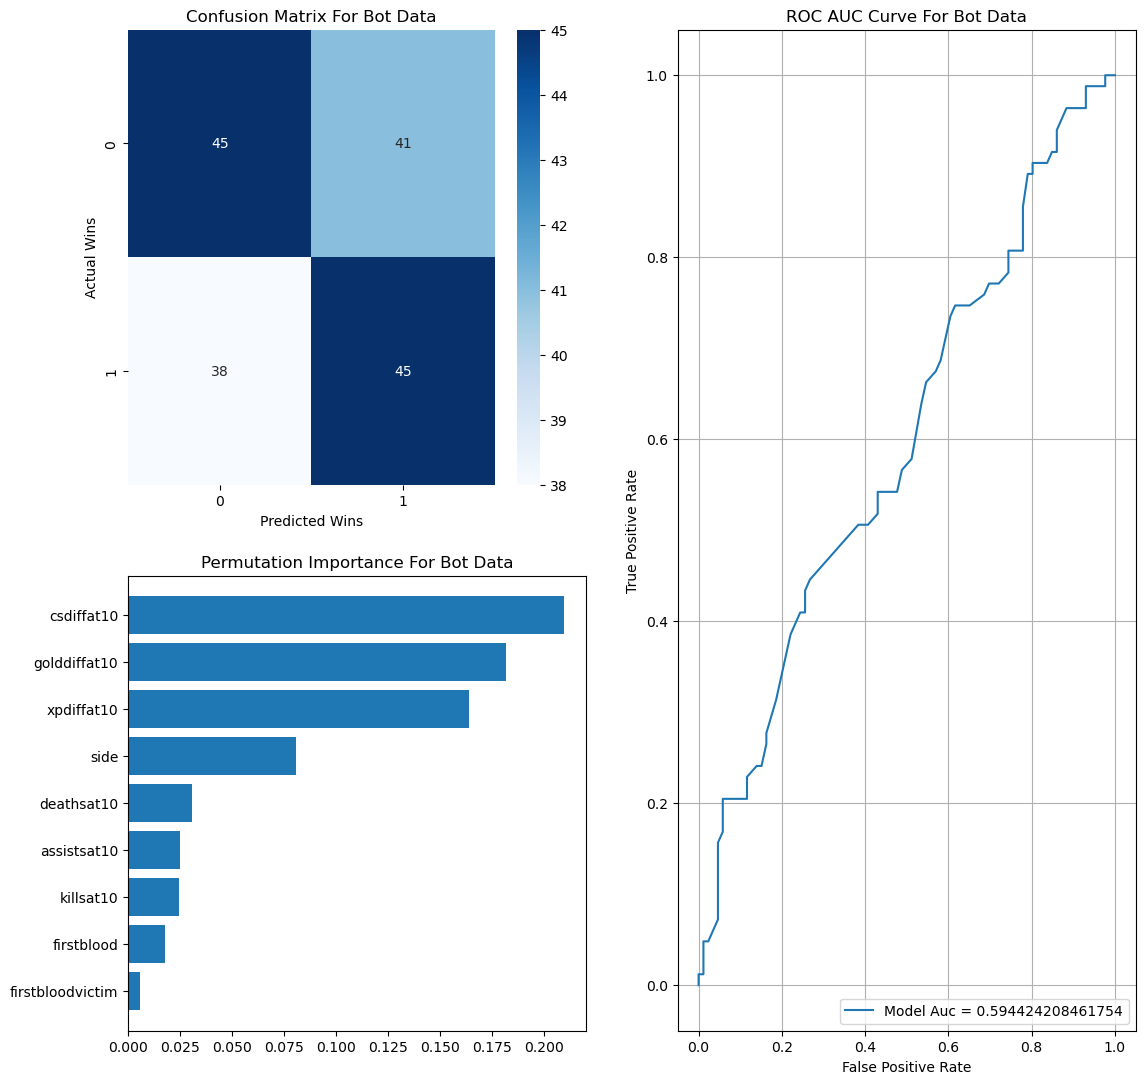

RandomForestClassifier(random_state=213)

In [76]:
fit_eval(RandomForestClassifier(random_state = 213), xbot_train, ybot_train, xbot_test, ybot_test, title = "Bot Data", folderpath = "./RF./")

CLASSIFICATION REPORT FOR TRAINING DATA
              precision    recall  f1-score   support

           0     1.0000    1.0000    1.0000       335
           1     1.0000    1.0000    1.0000       338

    accuracy                         1.0000       673
   macro avg     1.0000    1.0000    1.0000       673
weighted avg     1.0000    1.0000    1.0000       673

CLASSIFICATION REPORT FOR TEST DATA
              precision    recall  f1-score   support

           0     0.6180    0.6395    0.6286        86
           1     0.6125    0.5904    0.6012        83

    accuracy                         0.6154       169
   macro avg     0.6152    0.6149    0.6149       169
weighted avg     0.6153    0.6154    0.6151       169



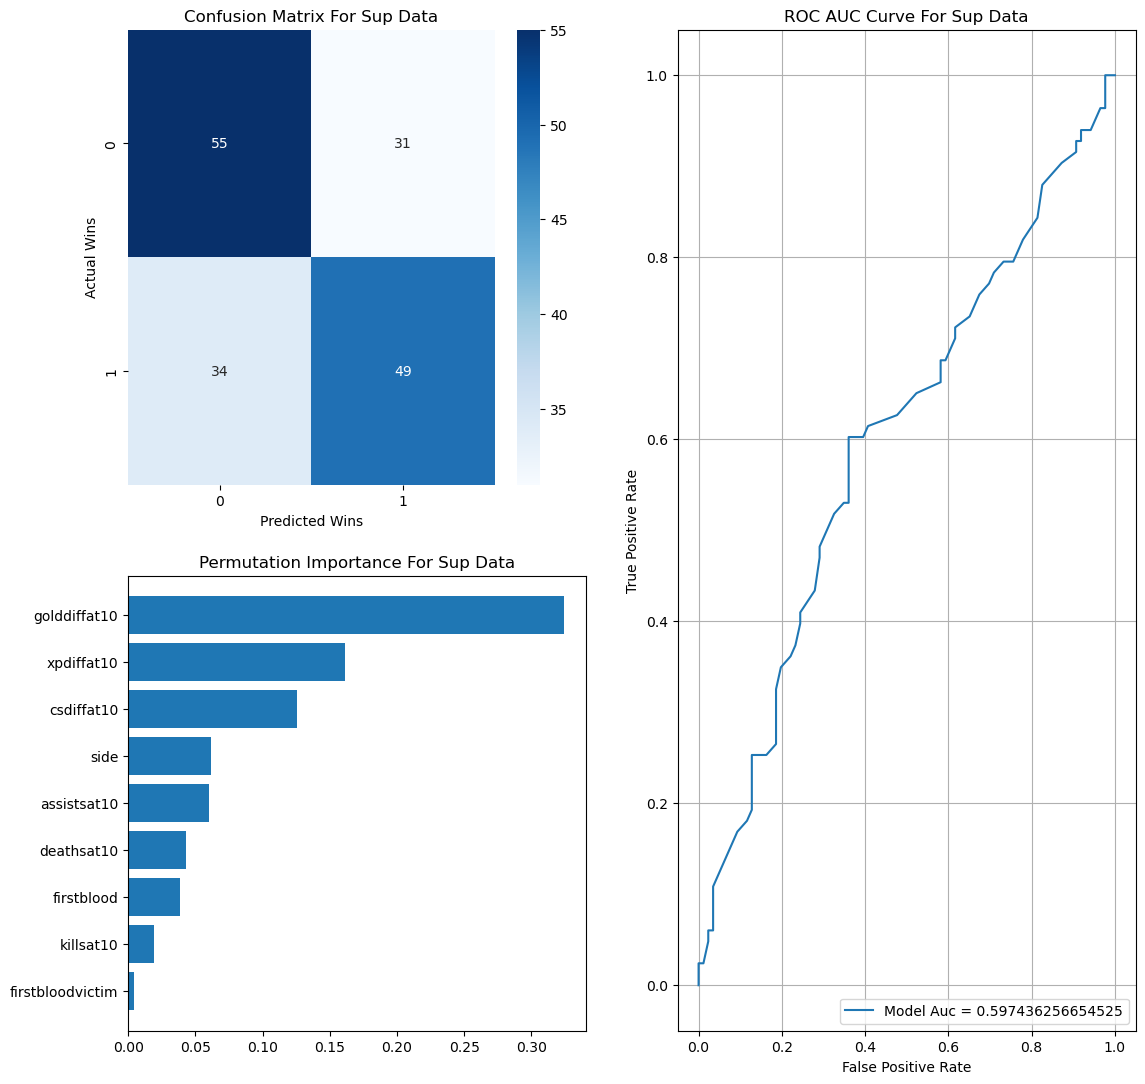

RandomForestClassifier(random_state=213)

In [77]:
fit_eval(RandomForestClassifier(random_state = 213), xsup_train, ysup_train, xsup_test, ysup_test, title = "Sup Data", folderpath = "./RF./")

CLASSIFICATION REPORT FOR TRAINING DATA
              precision    recall  f1-score   support

           0     1.0000    1.0000    1.0000       335
           1     1.0000    1.0000    1.0000       338

    accuracy                         1.0000       673
   macro avg     1.0000    1.0000    1.0000       673
weighted avg     1.0000    1.0000    1.0000       673

CLASSIFICATION REPORT FOR TEST DATA
              precision    recall  f1-score   support

           0     0.6897    0.6977    0.6936        86
           1     0.6829    0.6747    0.6788        83

    accuracy                         0.6864       169
   macro avg     0.6863    0.6862    0.6862       169
weighted avg     0.6864    0.6864    0.6863       169



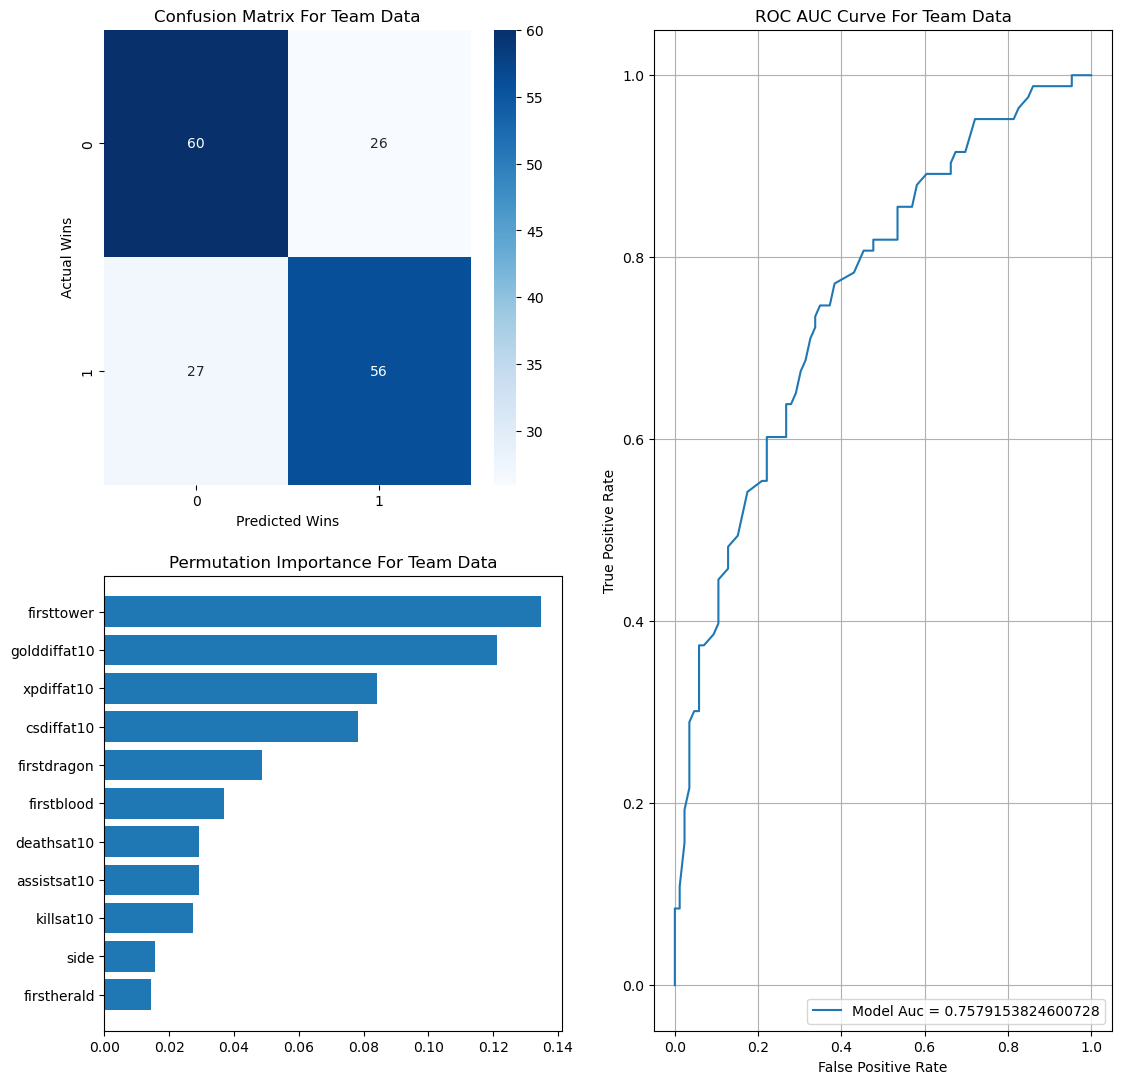

RandomForestClassifier(random_state=213)

In [78]:
fit_eval(RandomForestClassifier(random_state = 213), xteam_train, yteam_train, xteam_test, yteam_test, title = "Team Data", folderpath = "./RF./")

In [79]:
df_scores.loc[6] = ["Random Forest", "Top", 0.5625, 0.5768]
df_scores.loc[7] = ["Random Forest", "Jungle", 0.5859, 0.5972]
df_scores.loc[8] = ["Random Forest", "Middle", 0.5469, 0.6393]
df_scores.loc[9] = ["Random Forest", "Bottom", 0.6512, 0.7250]
df_scores.loc[10] = ["Random Forest", "Support", 0.6016, 0.6434]
df_scores.loc[11] = ["Random Forest", "Team", 0.6094, 0.6452]

#### Linear Discriminant Analysis (LDA)

CLASSIFICATION REPORT FOR TRAINING DATA
              precision    recall  f1-score   support

           0     0.6319    0.6149    0.6233       335
           1     0.6282    0.6450    0.6365       338

    accuracy                         0.6300       673
   macro avg     0.6301    0.6299    0.6299       673
weighted avg     0.6301    0.6300    0.6299       673

CLASSIFICATION REPORT FOR TEST DATA
              precision    recall  f1-score   support

           0     0.6386    0.6163    0.6272        86
           1     0.6163    0.6386    0.6272        83

    accuracy                         0.6272       169
   macro avg     0.6274    0.6274    0.6272       169
weighted avg     0.6276    0.6272    0.6272       169



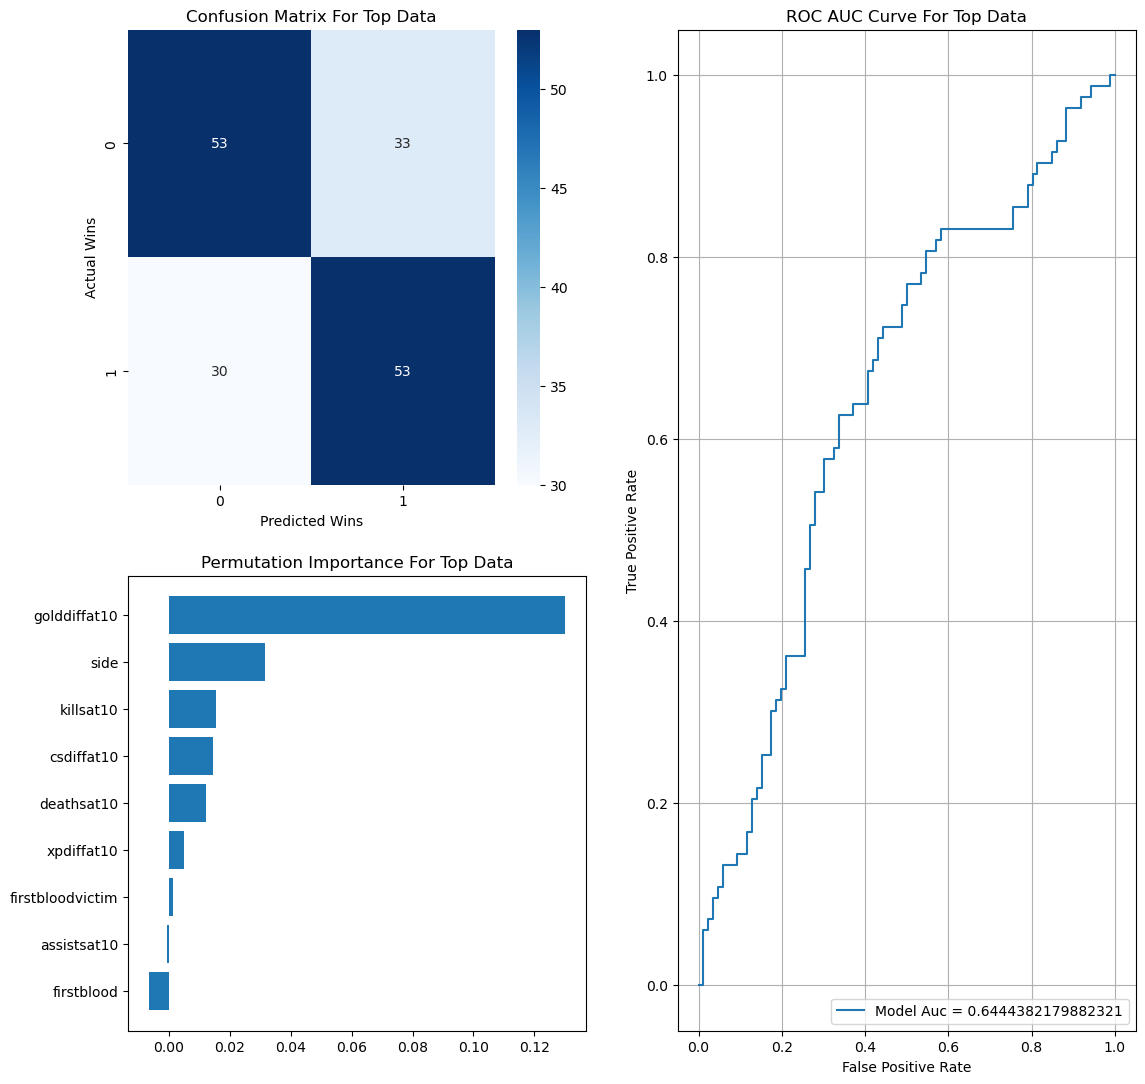

LinearDiscriminantAnalysis()

In [80]:
fit_eval(LinearDiscriminantAnalysis(), xtop_train, ytop_train, xtop_test, ytop_test, title = "Top Data", folderpath = "./LDA./")

CLASSIFICATION REPORT FOR TRAINING DATA
              precision    recall  f1-score   support

           0     0.6250    0.6418    0.6333       335
           1     0.6353    0.6183    0.6267       338

    accuracy                         0.6300       673
   macro avg     0.6301    0.6301    0.6300       673
weighted avg     0.6302    0.6300    0.6300       673

CLASSIFICATION REPORT FOR TEST DATA
              precision    recall  f1-score   support

           0     0.6543    0.6163    0.6347        86
           1     0.6250    0.6627    0.6433        83

    accuracy                         0.6391       169
   macro avg     0.6397    0.6395    0.6390       169
weighted avg     0.6399    0.6391    0.6389       169



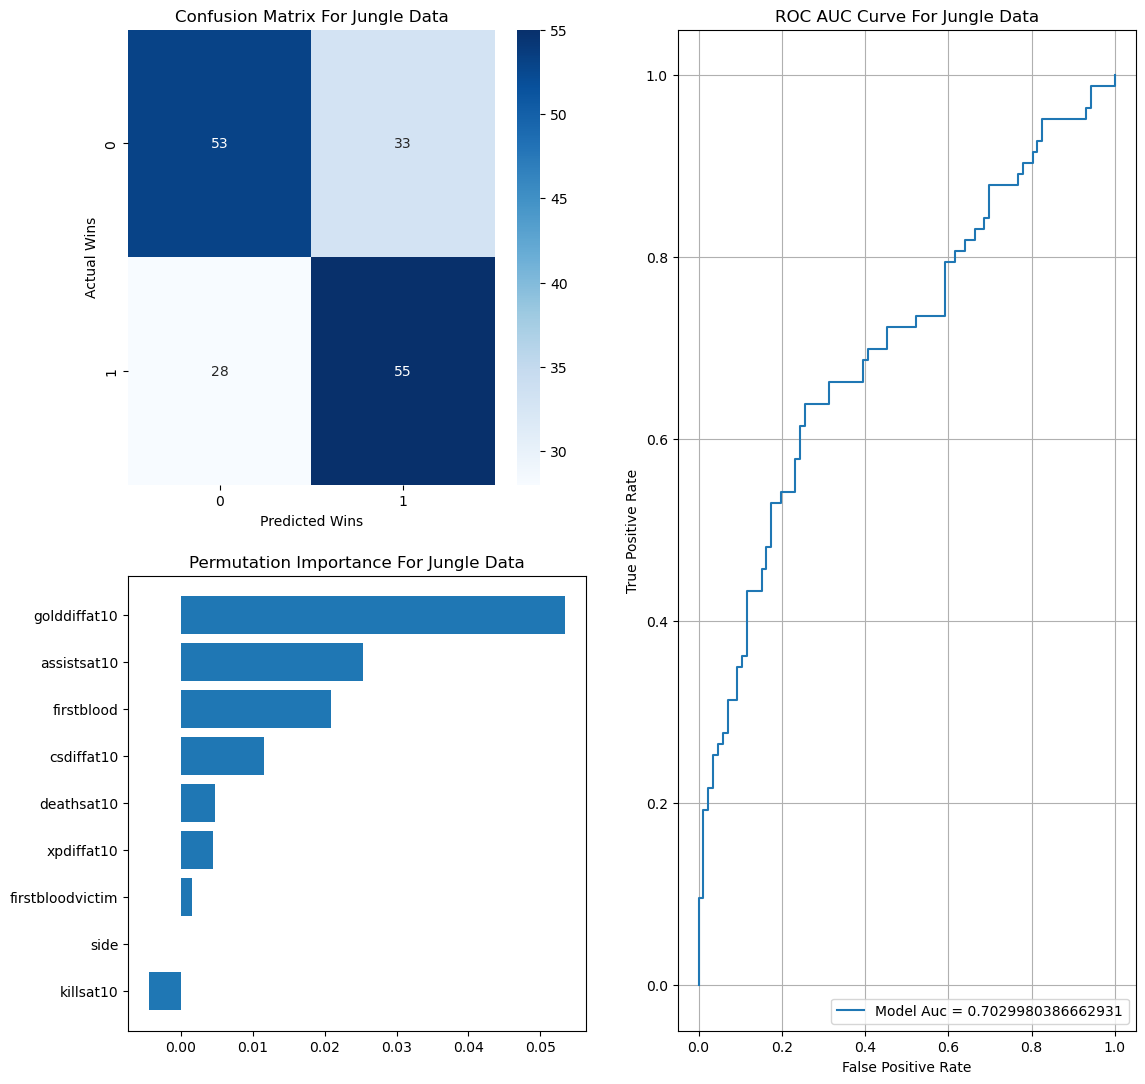

LinearDiscriminantAnalysis()

In [81]:
fit_eval(LinearDiscriminantAnalysis(), xjng_train, yjng_train, xjng_test, yjng_test, title = "Jungle Data", folderpath = "./LDA./")

CLASSIFICATION REPORT FOR TRAINING DATA
              precision    recall  f1-score   support

           0     0.5928    0.5910    0.5919       335
           1     0.5959    0.5976    0.5968       338

    accuracy                         0.5944       673
   macro avg     0.5943    0.5943    0.5943       673
weighted avg     0.5943    0.5944    0.5944       673

CLASSIFICATION REPORT FOR TEST DATA
              precision    recall  f1-score   support

           0     0.5366    0.5116    0.5238        86
           1     0.5172    0.5422    0.5294        83

    accuracy                         0.5266       169
   macro avg     0.5269    0.5269    0.5266       169
weighted avg     0.5271    0.5266    0.5266       169



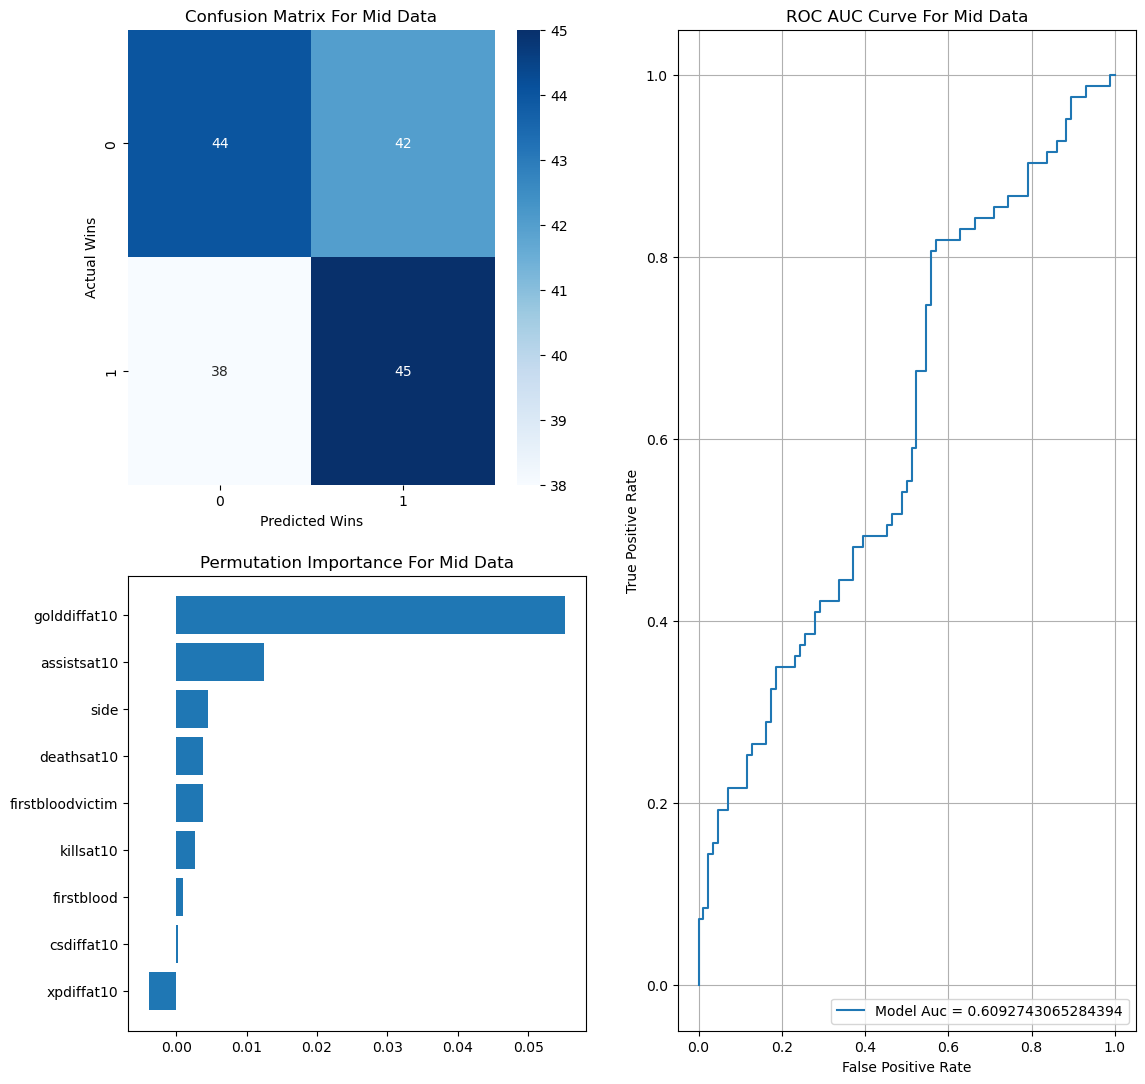

LinearDiscriminantAnalysis()

In [82]:
fit_eval(LinearDiscriminantAnalysis(), xmid_train, ymid_train, xmid_test, ymid_test, title = "Mid Data", folderpath = "./LDA./")

CLASSIFICATION REPORT FOR TRAINING DATA
              precision    recall  f1-score   support

           0     0.6250    0.6269    0.6259       335
           1     0.6291    0.6272    0.6281       338

    accuracy                         0.6270       673
   macro avg     0.6270    0.6270    0.6270       673
weighted avg     0.6270    0.6270    0.6270       673

CLASSIFICATION REPORT FOR TEST DATA
              precision    recall  f1-score   support

           0     0.6875    0.6395    0.6627        86
           1     0.6517    0.6988    0.6744        83

    accuracy                         0.6686       169
   macro avg     0.6696    0.6692    0.6685       169
weighted avg     0.6699    0.6686    0.6684       169



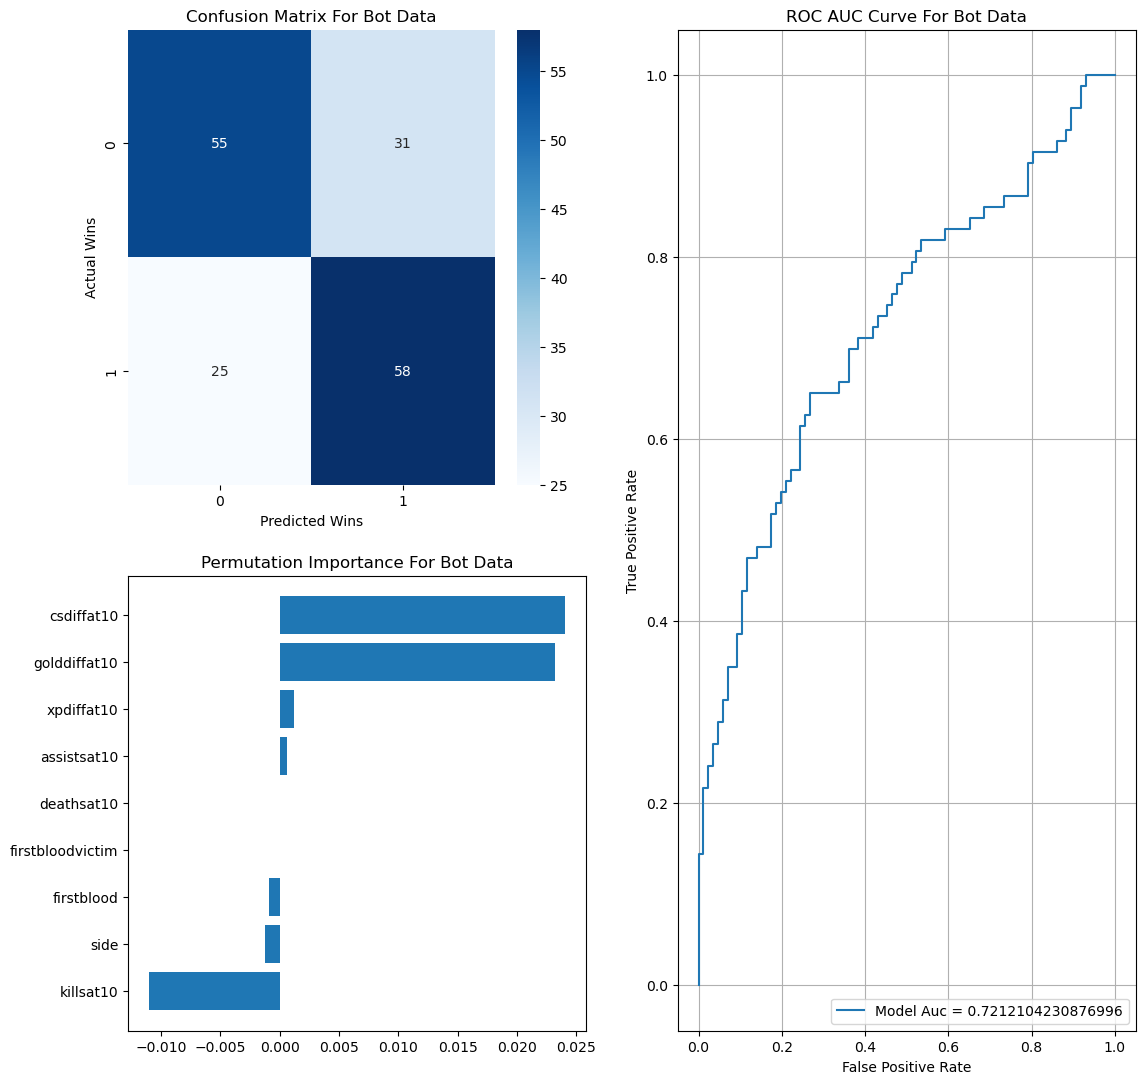

LinearDiscriminantAnalysis()

In [83]:
fit_eval(LinearDiscriminantAnalysis(), xbot_train, ybot_train, xbot_test, ybot_test, title = "Bot Data", folderpath = "./LDA./")

CLASSIFICATION REPORT FOR TRAINING DATA
              precision    recall  f1-score   support

           0     0.6257    0.6388    0.6322       335
           1     0.6344    0.6213    0.6278       338

    accuracy                         0.6300       673
   macro avg     0.6301    0.6301    0.6300       673
weighted avg     0.6301    0.6300    0.6300       673

CLASSIFICATION REPORT FOR TEST DATA
              precision    recall  f1-score   support

           0     0.6353    0.6279    0.6316        86
           1     0.6190    0.6265    0.6228        83

    accuracy                         0.6272       169
   macro avg     0.6272    0.6272    0.6272       169
weighted avg     0.6273    0.6272    0.6272       169



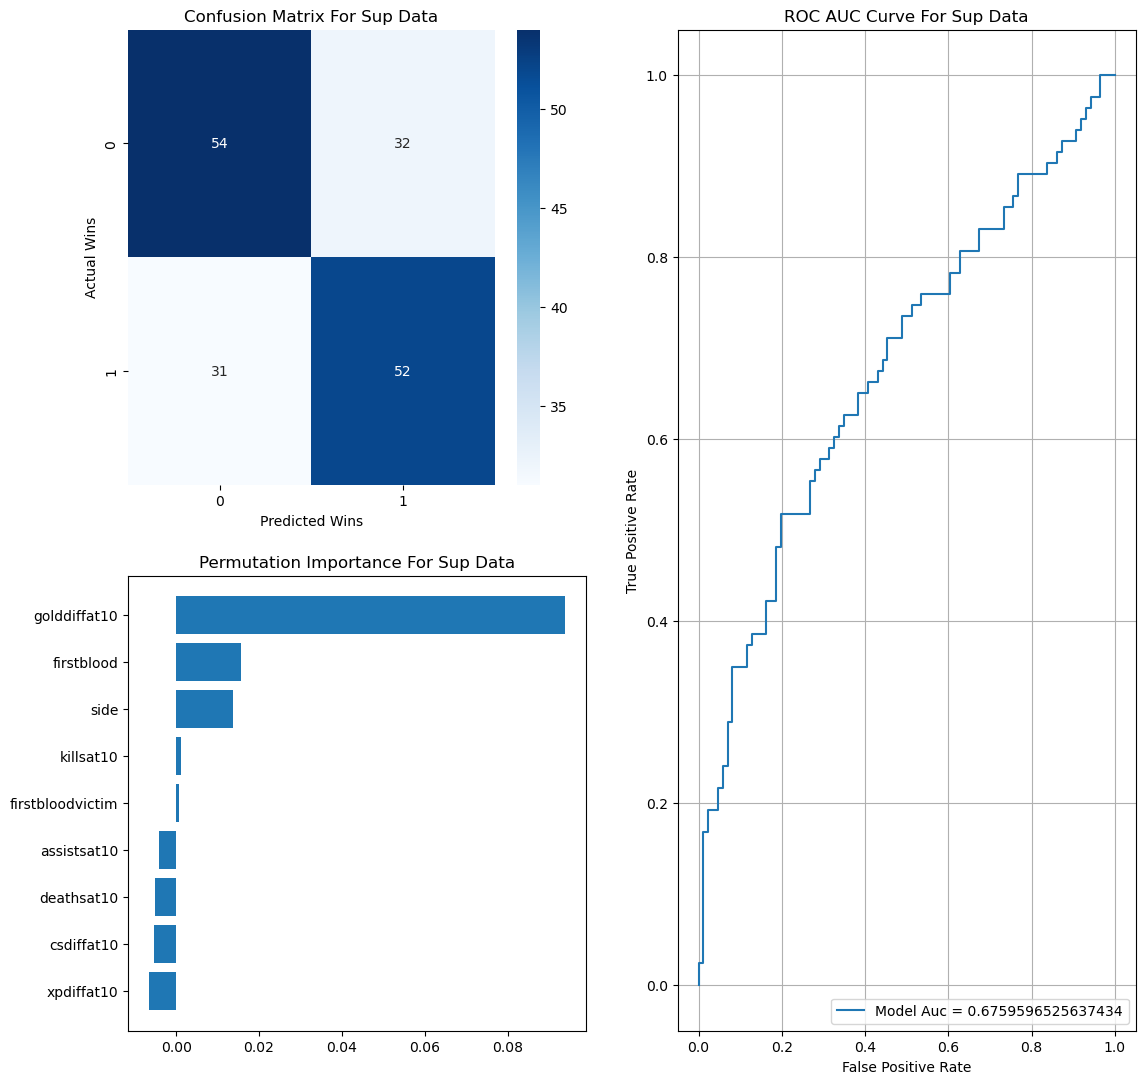

LinearDiscriminantAnalysis()

In [84]:
fit_eval(LinearDiscriminantAnalysis(), xsup_train, ysup_train, xsup_test, ysup_test, title = "Sup Data", folderpath = "./LDA./")

CLASSIFICATION REPORT FOR TRAINING DATA
              precision    recall  f1-score   support

           0     0.7439    0.7284    0.7360       335
           1     0.7362    0.7515    0.7438       338

    accuracy                         0.7400       673
   macro avg     0.7401    0.7399    0.7399       673
weighted avg     0.7401    0.7400    0.7399       673

CLASSIFICATION REPORT FOR TEST DATA
              precision    recall  f1-score   support

           0     0.7010    0.7907    0.7432        86
           1     0.7500    0.6506    0.6968        83

    accuracy                         0.7219       169
   macro avg     0.7255    0.7207    0.7200       169
weighted avg     0.7251    0.7219    0.7204       169



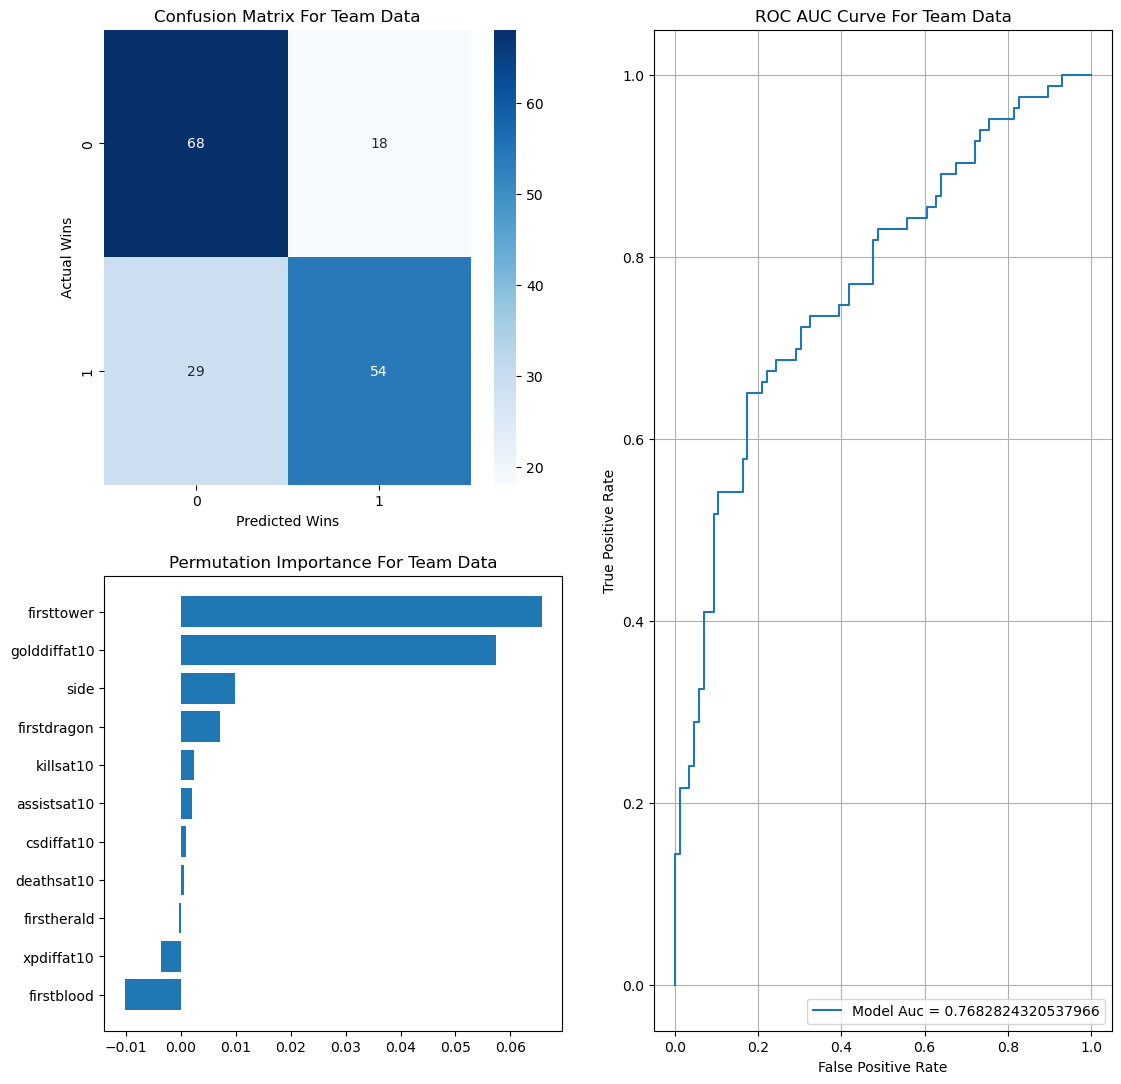

LinearDiscriminantAnalysis()

In [85]:
fit_eval(LinearDiscriminantAnalysis(), xteam_train, yteam_train, xteam_test, yteam_test, title = "Team Data", folderpath = "./LDA./")

In [86]:
df_scores.loc[12] = ["Linear Discriminant Analysis", "Top", 0.6094, 0.6163]
df_scores.loc[13] = ["Linear Discriminant Analysis", "Jungle", 0.6406, 0.6674]
df_scores.loc[14] = ["Linear Discriminant Analysis", "Middle", 0.5938, 0.6337]
df_scores.loc[15] = ["Linear Discriminant Analysis", "Bottom", 0.6406, 0.7201]
df_scores.loc[16] = ["Linear Discriminant Analysis", "Support", 0.6172, 0.6559]
df_scores.loc[17] = ["Linear Discriminant Analysis", "Team", 0.7500, 0.8049]

#### Quadratic Discriminant Analysis

CLASSIFICATION REPORT FOR TRAINING DATA
              precision    recall  f1-score   support

           0     0.6422    0.6000    0.6204       335
           1     0.6278    0.6686    0.6476       338

    accuracy                         0.6345       673
   macro avg     0.6350    0.6343    0.6340       673
weighted avg     0.6349    0.6345    0.6340       673

CLASSIFICATION REPORT FOR TEST DATA
              precision    recall  f1-score   support

           0     0.6234    0.5581    0.5890        86
           1     0.5870    0.6506    0.6171        83

    accuracy                         0.6036       169
   macro avg     0.6052    0.6044    0.6030       169
weighted avg     0.6055    0.6036    0.6028       169



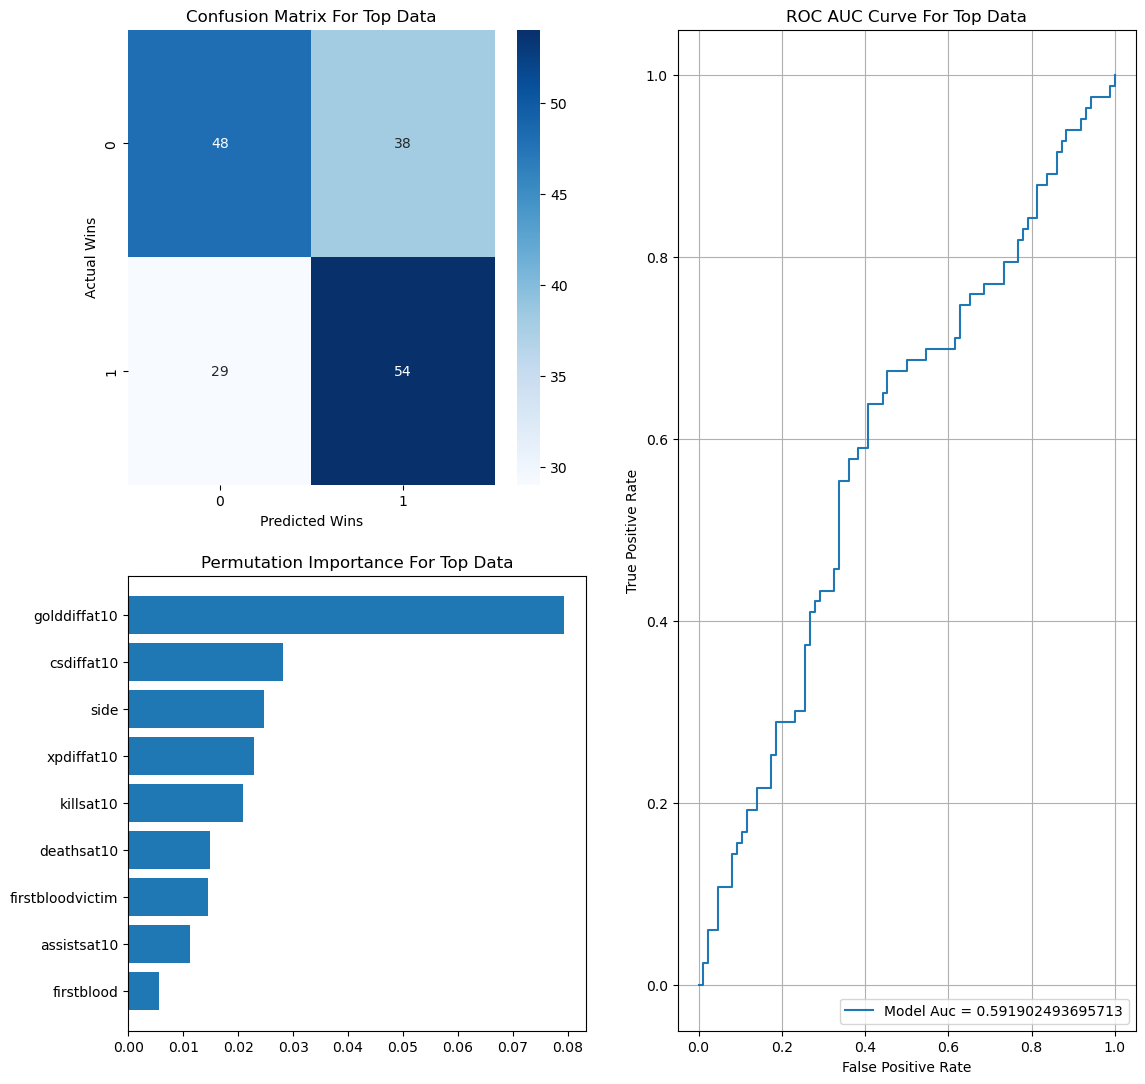

QuadraticDiscriminantAnalysis()

In [87]:
fit_eval(QuadraticDiscriminantAnalysis(), xtop_train, ytop_train, xtop_test, ytop_test, title = "Top Data", folderpath = "./QDA./")

CLASSIFICATION REPORT FOR TRAINING DATA
              precision    recall  f1-score   support

           0     0.6341    0.6000    0.6166       335
           1     0.6236    0.6568    0.6398       338

    accuracy                         0.6285       673
   macro avg     0.6288    0.6284    0.6282       673
weighted avg     0.6288    0.6285    0.6282       673

CLASSIFICATION REPORT FOR TEST DATA
              precision    recall  f1-score   support

           0     0.6486    0.5581    0.6000        86
           1     0.6000    0.6867    0.6404        83

    accuracy                         0.6213       169
   macro avg     0.6243    0.6224    0.6202       169
weighted avg     0.6248    0.6213    0.6199       169



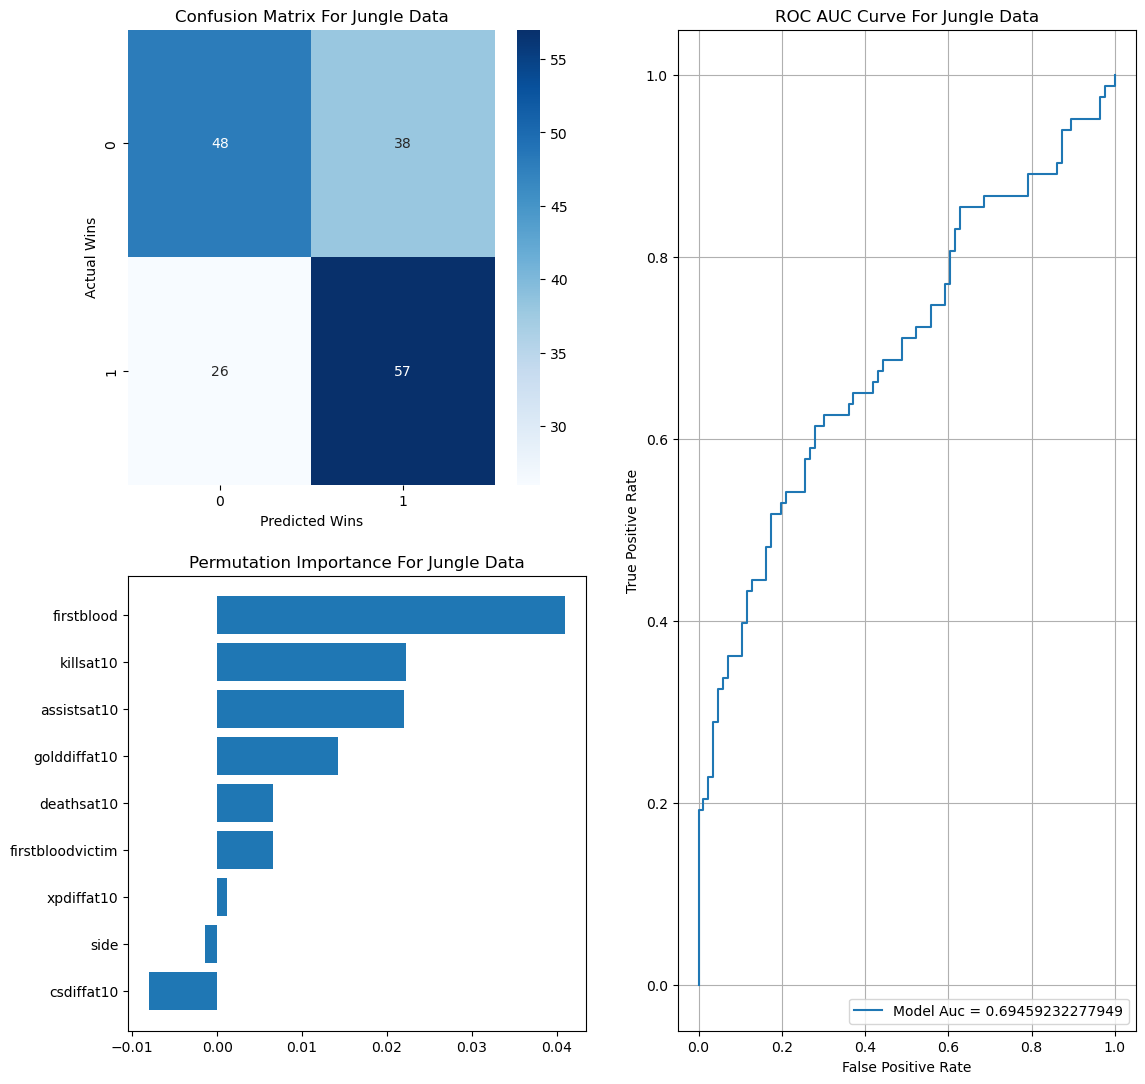

QuadraticDiscriminantAnalysis()

In [88]:
fit_eval(QuadraticDiscriminantAnalysis(), xjng_train, yjng_train, xjng_test, yjng_test, title = "Jungle Data", folderpath = "./QDA./")

CLASSIFICATION REPORT FOR TRAINING DATA
              precision    recall  f1-score   support

           0     0.6012    0.6119    0.6065       335
           1     0.6084    0.5976    0.6030       338

    accuracy                         0.6048       673
   macro avg     0.6048    0.6048    0.6047       673
weighted avg     0.6048    0.6048    0.6047       673

CLASSIFICATION REPORT FOR TEST DATA
              precision    recall  f1-score   support

           0     0.6250    0.6395    0.6322        86
           1     0.6173    0.6024    0.6098        83

    accuracy                         0.6213       169
   macro avg     0.6211    0.6210    0.6210       169
weighted avg     0.6212    0.6213    0.6212       169



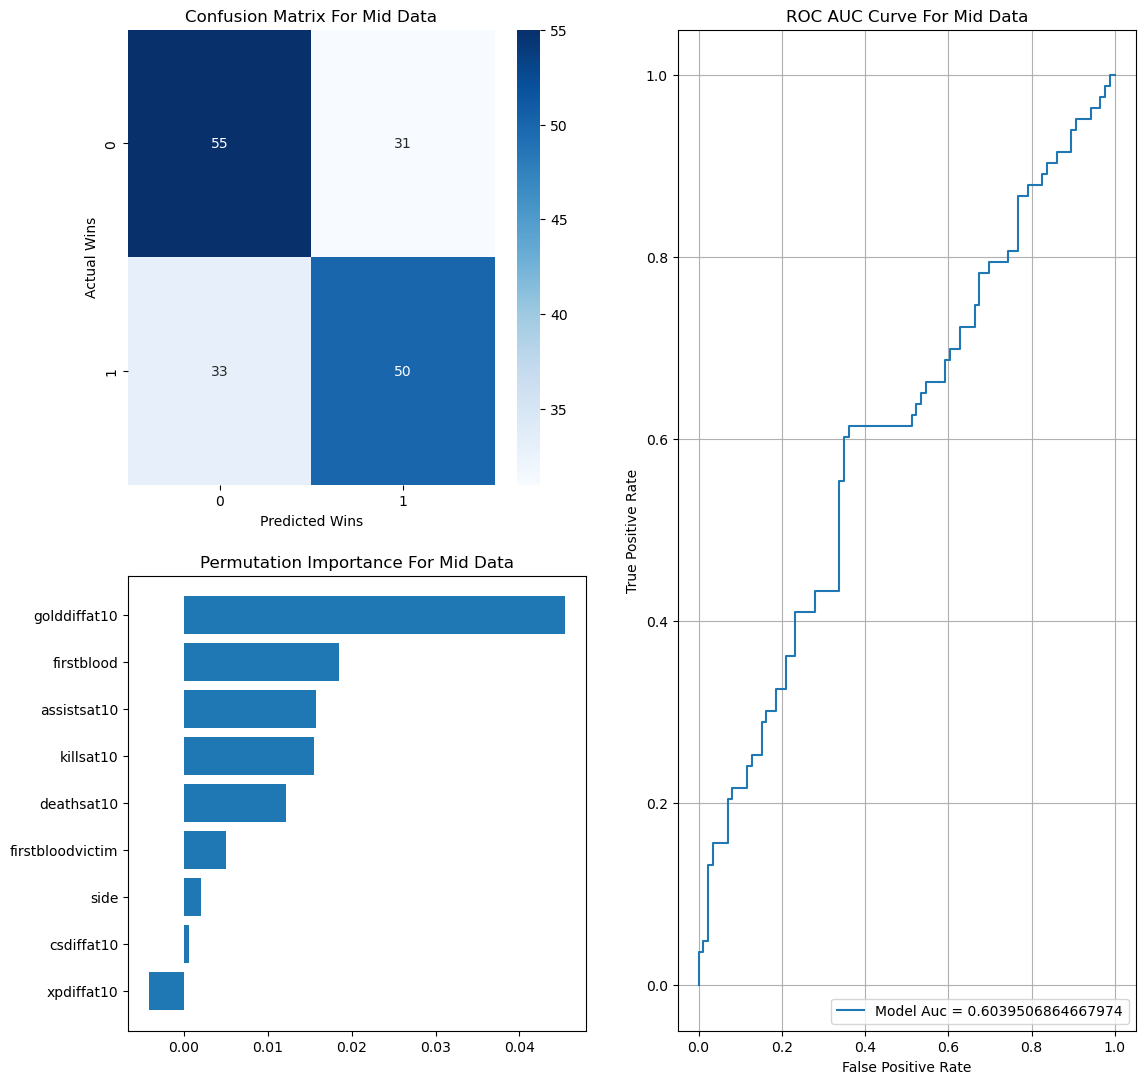

QuadraticDiscriminantAnalysis()

In [89]:
fit_eval(QuadraticDiscriminantAnalysis(), xmid_train, ymid_train, xmid_test, ymid_test, title = "Mid Data", folderpath = "./QDA./")

CLASSIFICATION REPORT FOR TRAINING DATA
              precision    recall  f1-score   support

           0     0.6214    0.5731    0.5963       335
           1     0.6071    0.6538    0.6296       338

    accuracy                         0.6137       673
   macro avg     0.6143    0.6135    0.6130       673
weighted avg     0.6142    0.6137    0.6130       673

CLASSIFICATION REPORT FOR TEST DATA
              precision    recall  f1-score   support

           0     0.6571    0.5349    0.5897        86
           1     0.5960    0.7108    0.6484        83

    accuracy                         0.6213       169
   macro avg     0.6266    0.6229    0.6190       169
weighted avg     0.6271    0.6213    0.6185       169



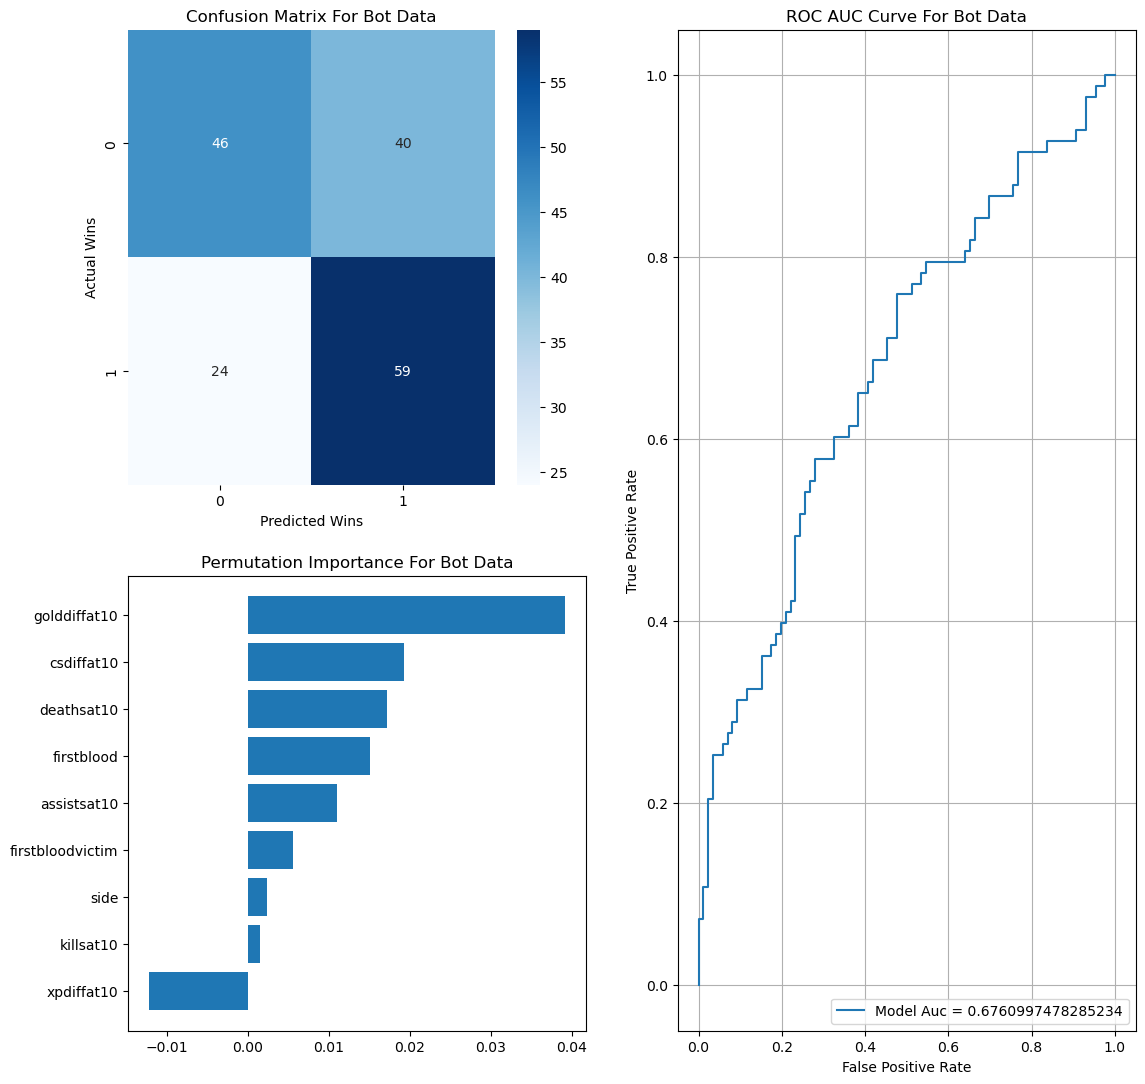

QuadraticDiscriminantAnalysis()

In [90]:
fit_eval(QuadraticDiscriminantAnalysis(), xbot_train, ybot_train, xbot_test, ybot_test, title = "Bot Data", folderpath = "./QDA./")

CLASSIFICATION REPORT FOR TRAINING DATA
              precision    recall  f1-score   support

           0     0.5860    0.6507    0.6167       335
           1     0.6113    0.5444    0.5759       338

    accuracy                         0.5973       673
   macro avg     0.5987    0.5976    0.5963       673
weighted avg     0.5987    0.5973    0.5962       673

CLASSIFICATION REPORT FOR TEST DATA
              precision    recall  f1-score   support

           0     0.6136    0.6279    0.6207        86
           1     0.6049    0.5904    0.5976        83

    accuracy                         0.6095       169
   macro avg     0.6093    0.6091    0.6091       169
weighted avg     0.6094    0.6095    0.6093       169



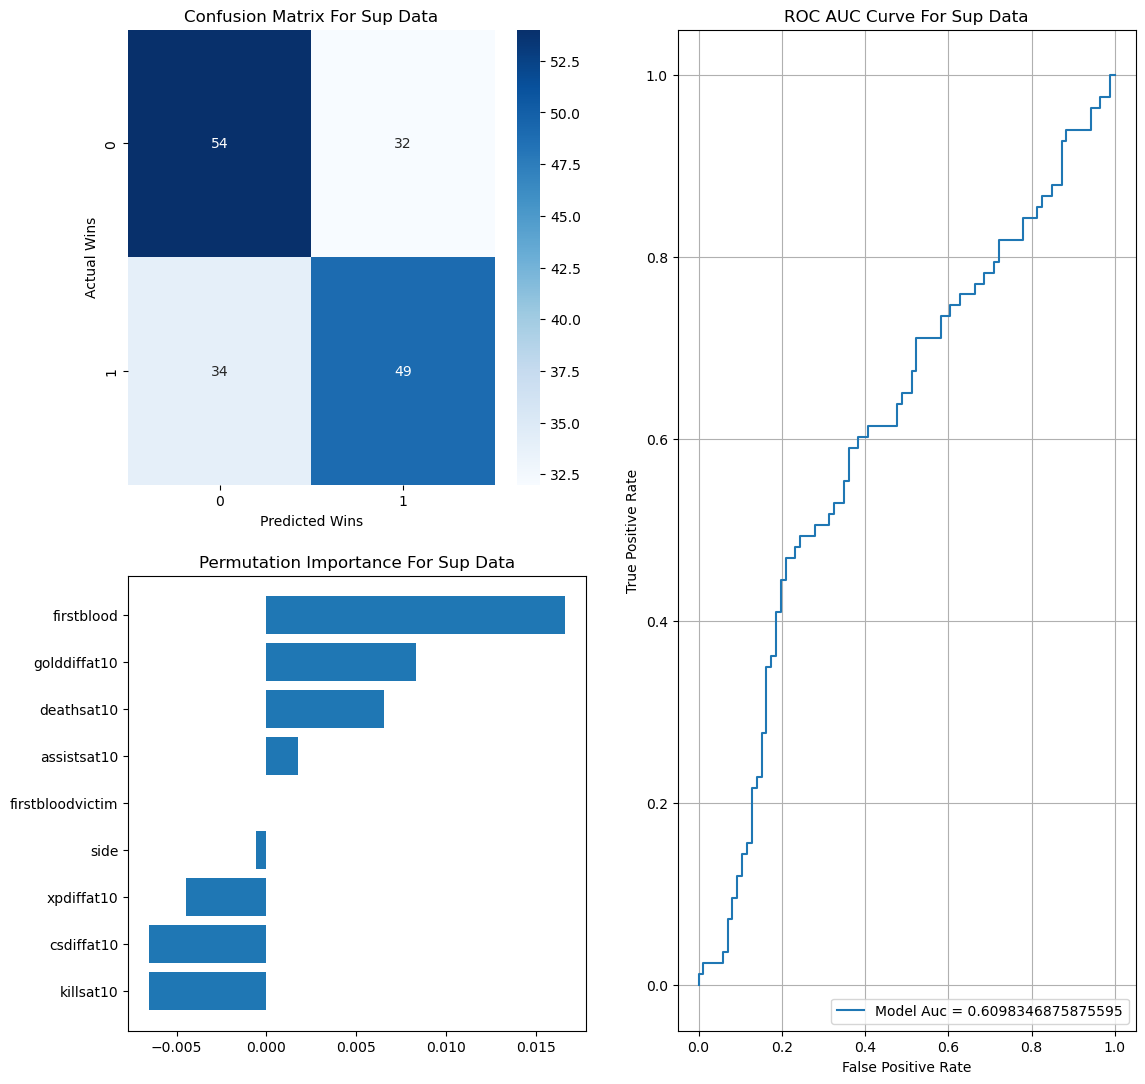

QuadraticDiscriminantAnalysis()

In [91]:
fit_eval(QuadraticDiscriminantAnalysis(), xsup_train, ysup_train, xsup_test, ysup_test, title = "Sup Data", folderpath = "./QDA./")

CLASSIFICATION REPORT FOR TRAINING DATA
              precision    recall  f1-score   support

           0     0.7500    0.7433    0.7466       335
           1     0.7478    0.7544    0.7511       338

    accuracy                         0.7489       673
   macro avg     0.7489    0.7489    0.7489       673
weighted avg     0.7489    0.7489    0.7489       673

CLASSIFICATION REPORT FOR TEST DATA
              precision    recall  f1-score   support

           0     0.7241    0.7326    0.7283        86
           1     0.7195    0.7108    0.7152        83

    accuracy                         0.7219       169
   macro avg     0.7218    0.7217    0.7217       169
weighted avg     0.7219    0.7219    0.7219       169



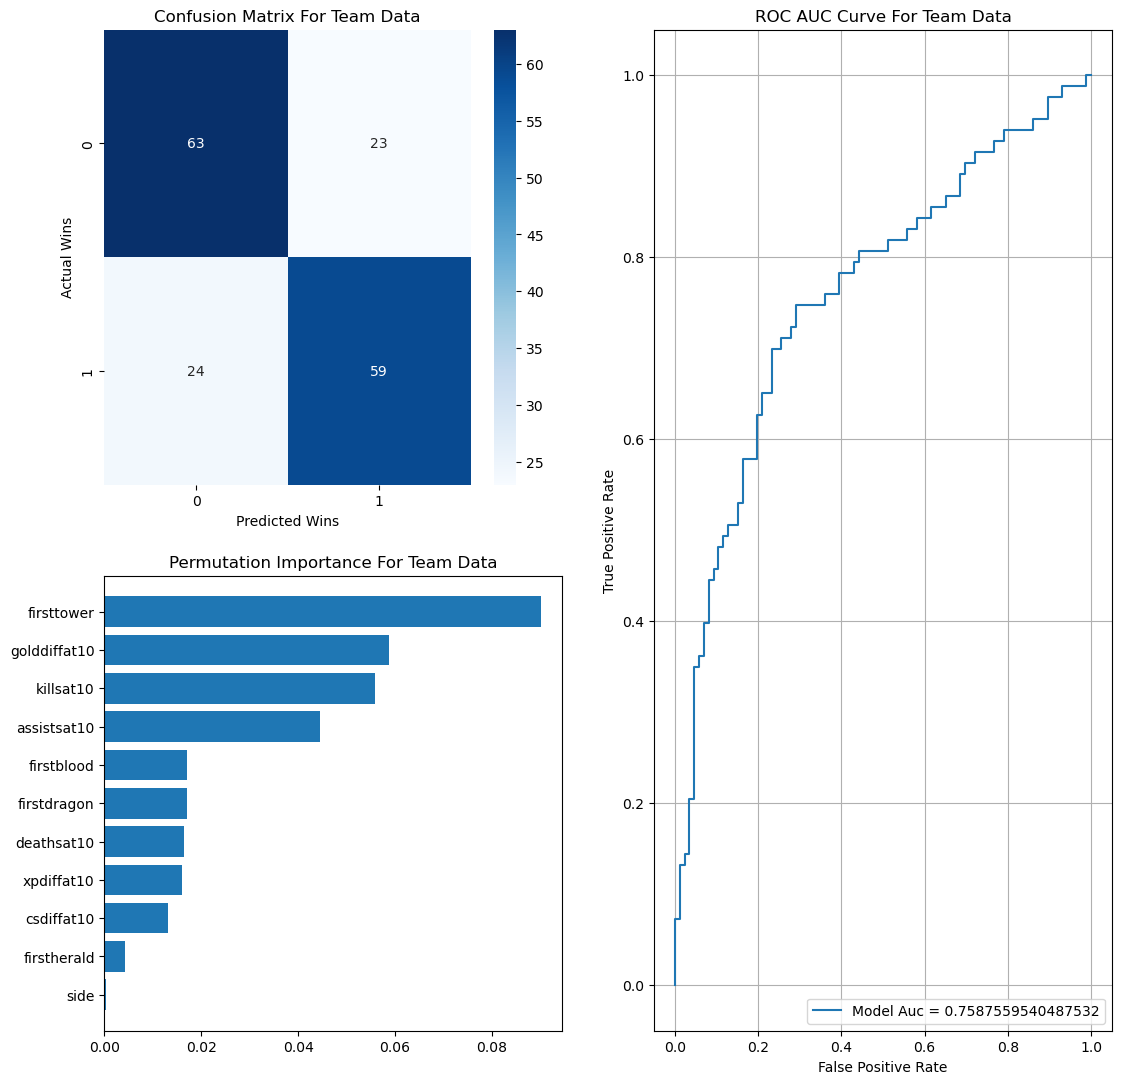

QuadraticDiscriminantAnalysis()

In [92]:
fit_eval(QuadraticDiscriminantAnalysis(), xteam_train, yteam_train, xteam_test, yteam_test, title = "Team Data", folderpath = "./QDA./")

In [93]:
df_scores.loc[18] = ["Quadratic Discriminant Analysis", "Top", 0.5391, 0.5573]
df_scores.loc[19] = ["Quadratic Discriminant Analysis", "Jungle", 0.6016, 0.6413]
df_scores.loc[20] = ["Quadratic Discriminant Analysis", "Middle", 0.5938, 0.6278]
df_scores.loc[21] = ["Quadratic Discriminant Analysis", "Bottom", 0.6328, 0.6464]
df_scores.loc[22] = ["Quadratic Discriminant Analysis", "Support", 0.6406, 0.6476]
df_scores.loc[23] = ["Quadratic Discriminant Analysis", "Team", 0.7109, 0.7438]

#### XGBoost with Random Forest

CLASSIFICATION REPORT FOR TRAINING DATA
              precision    recall  f1-score   support

           0     0.7794    0.8119    0.7953       335
           1     0.8056    0.7722    0.7885       338

    accuracy                         0.7920       673
   macro avg     0.7925    0.7921    0.7919       673
weighted avg     0.7925    0.7920    0.7919       673

CLASSIFICATION REPORT FOR TEST DATA
              precision    recall  f1-score   support

           0     0.6071    0.5930    0.6000        86
           1     0.5882    0.6024    0.5952        83

    accuracy                         0.5976       169
   macro avg     0.5977    0.5977    0.5976       169
weighted avg     0.5979    0.5976    0.5977       169



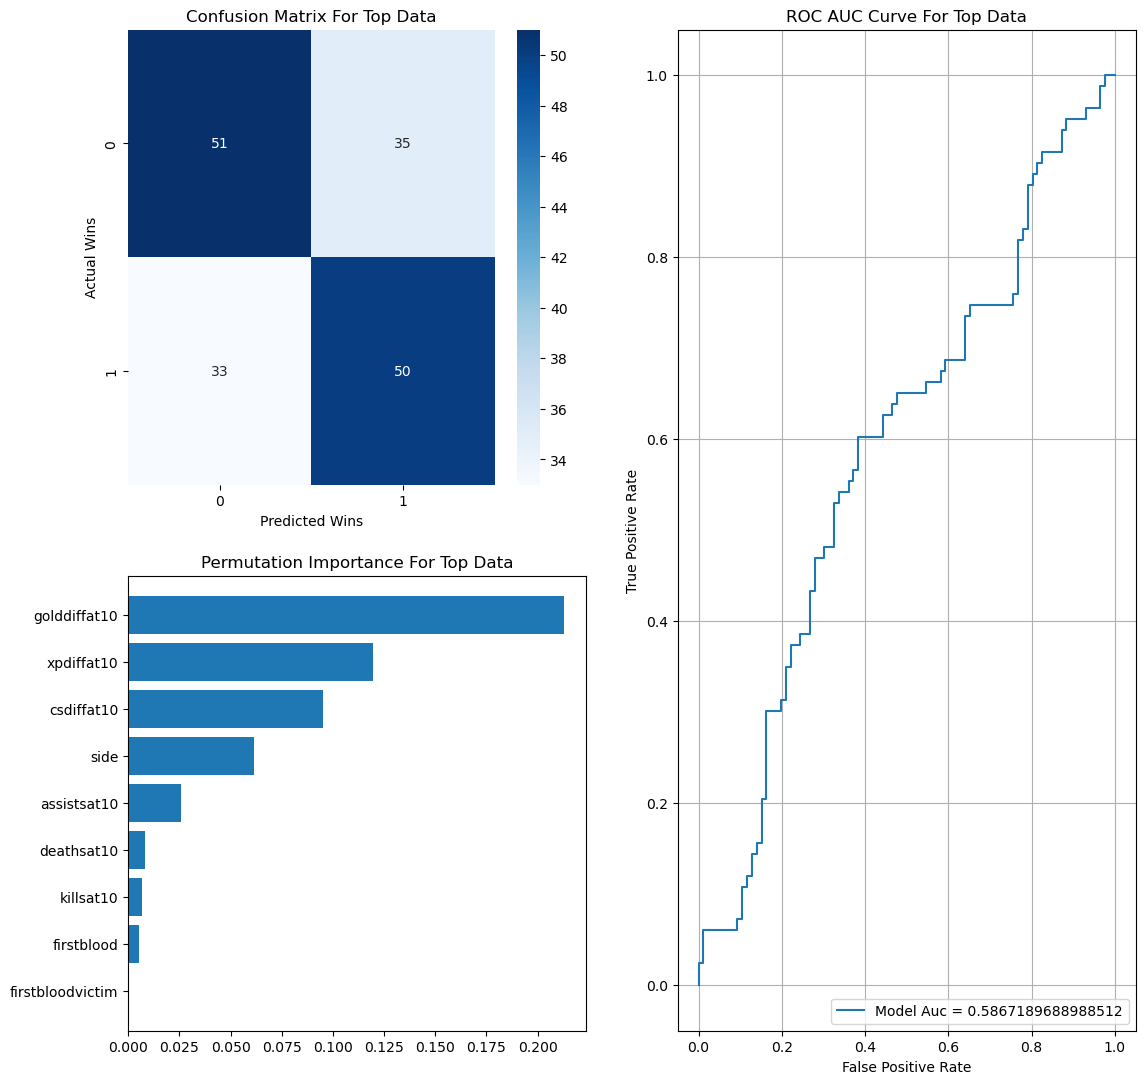

XGBRFClassifier(base_score=None, booster=None, callbacks=None,
                colsample_bylevel=None, colsample_bytree=None,
                early_stopping_rounds=None, enable_categorical=False,
                eval_metric=None, feature_types=None, gamma=None, gpu_id=None,
                grow_policy=None, importance_type=None,
                interaction_constraints=None, max_bin=None,
                max_cat_threshold=None, max_cat_to_onehot=None,
                max_delta_step=None, max_depth=None, max_leaves=None,
                min_child_weight=None, missing=nan, monotone_constraints=None,
                n_estimators=100, n_jobs=None, num_parallel_tree=None,
                objective='binary:logistic', predictor=None, random_state=213,
                reg_alpha=None, ...)

In [94]:
fit_eval(XGBRFClassifier(random_state = 213), xtop_train, ytop_train, xtop_test, ytop_test, title = "Top Data", folderpath = "./XGBRF./")

CLASSIFICATION REPORT FOR TRAINING DATA
              precision    recall  f1-score   support

           0     0.7607    0.7403    0.7504       335
           1     0.7493    0.7692    0.7591       338

    accuracy                         0.7548       673
   macro avg     0.7550    0.7548    0.7548       673
weighted avg     0.7550    0.7548    0.7548       673

CLASSIFICATION REPORT FOR TEST DATA
              precision    recall  f1-score   support

           0     0.6203    0.5698    0.5939        86
           1     0.5889    0.6386    0.6127        83

    accuracy                         0.6036       169
   macro avg     0.6046    0.6042    0.6033       169
weighted avg     0.6048    0.6036    0.6032       169



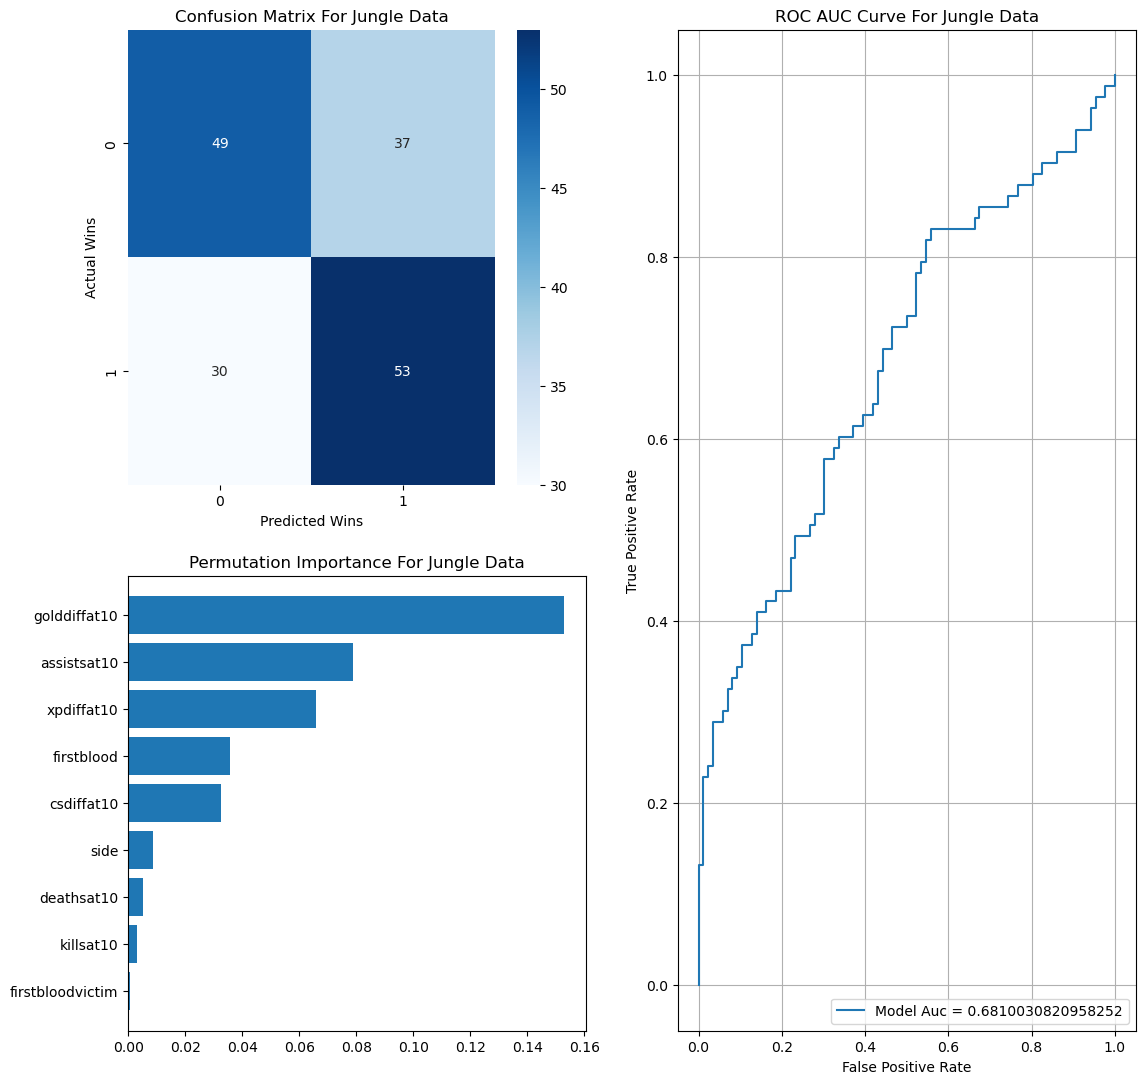

XGBRFClassifier(base_score=None, booster=None, callbacks=None,
                colsample_bylevel=None, colsample_bytree=None,
                early_stopping_rounds=None, enable_categorical=False,
                eval_metric=None, feature_types=None, gamma=None, gpu_id=None,
                grow_policy=None, importance_type=None,
                interaction_constraints=None, max_bin=None,
                max_cat_threshold=None, max_cat_to_onehot=None,
                max_delta_step=None, max_depth=None, max_leaves=None,
                min_child_weight=None, missing=nan, monotone_constraints=None,
                n_estimators=100, n_jobs=None, num_parallel_tree=None,
                objective='binary:logistic', predictor=None, random_state=213,
                reg_alpha=None, ...)

In [95]:
fit_eval(XGBRFClassifier(random_state = 213), xjng_train, yjng_train, xjng_test, yjng_test, title = "Jungle Data", folderpath = "./XGBRF./")

CLASSIFICATION REPORT FOR TRAINING DATA
              precision    recall  f1-score   support

           0     0.7243    0.8000    0.7603       335
           1     0.7789    0.6982    0.7363       338

    accuracy                         0.7489       673
   macro avg     0.7516    0.7491    0.7483       673
weighted avg     0.7517    0.7489    0.7483       673

CLASSIFICATION REPORT FOR TEST DATA
              precision    recall  f1-score   support

           0     0.5783    0.5581    0.5680        86
           1     0.5581    0.5783    0.5680        83

    accuracy                         0.5680       169
   macro avg     0.5682    0.5682    0.5680       169
weighted avg     0.5684    0.5680    0.5680       169



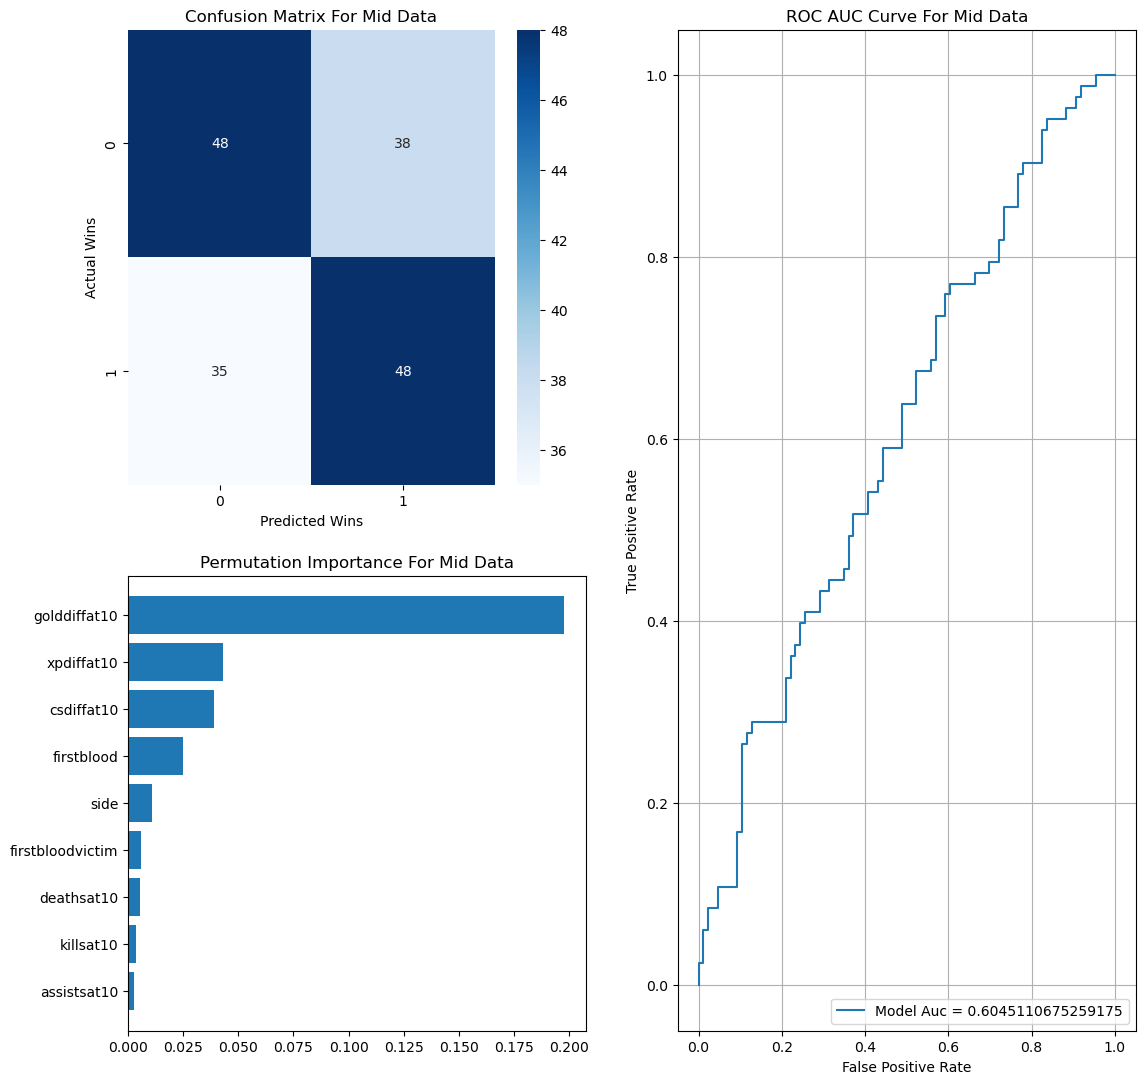

XGBRFClassifier(base_score=None, booster=None, callbacks=None,
                colsample_bylevel=None, colsample_bytree=None,
                early_stopping_rounds=None, enable_categorical=False,
                eval_metric=None, feature_types=None, gamma=None, gpu_id=None,
                grow_policy=None, importance_type=None,
                interaction_constraints=None, max_bin=None,
                max_cat_threshold=None, max_cat_to_onehot=None,
                max_delta_step=None, max_depth=None, max_leaves=None,
                min_child_weight=None, missing=nan, monotone_constraints=None,
                n_estimators=100, n_jobs=None, num_parallel_tree=None,
                objective='binary:logistic', predictor=None, random_state=213,
                reg_alpha=None, ...)

In [96]:
fit_eval(XGBRFClassifier(random_state = 213), xmid_train, ymid_train, xmid_test, ymid_test, title = "Mid Data", folderpath = "./XGBRF./")

CLASSIFICATION REPORT FOR TRAINING DATA
              precision    recall  f1-score   support

           0     0.8197    0.7463    0.7813       335
           1     0.7690    0.8373    0.8017       338

    accuracy                         0.7920       673
   macro avg     0.7943    0.7918    0.7915       673
weighted avg     0.7942    0.7920    0.7915       673

CLASSIFICATION REPORT FOR TEST DATA
              precision    recall  f1-score   support

           0     0.6364    0.5698    0.6012        86
           1     0.5978    0.6627    0.6286        83

    accuracy                         0.6154       169
   macro avg     0.6171    0.6162    0.6149       169
weighted avg     0.6174    0.6154    0.6147       169



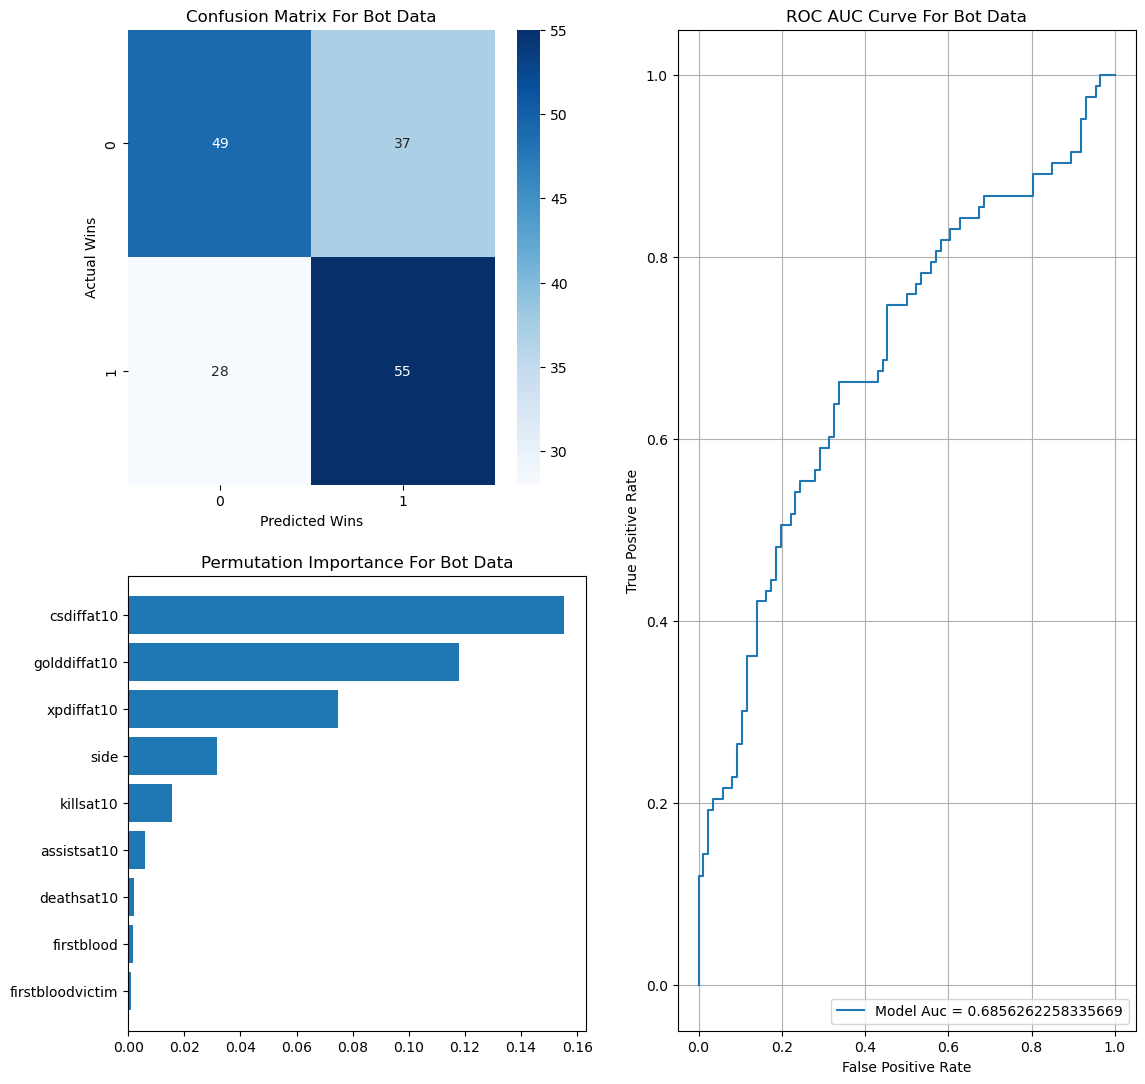

XGBRFClassifier(base_score=None, booster=None, callbacks=None,
                colsample_bylevel=None, colsample_bytree=None,
                early_stopping_rounds=None, enable_categorical=False,
                eval_metric=None, feature_types=None, gamma=None, gpu_id=None,
                grow_policy=None, importance_type=None,
                interaction_constraints=None, max_bin=None,
                max_cat_threshold=None, max_cat_to_onehot=None,
                max_delta_step=None, max_depth=None, max_leaves=None,
                min_child_weight=None, missing=nan, monotone_constraints=None,
                n_estimators=100, n_jobs=None, num_parallel_tree=None,
                objective='binary:logistic', predictor=None, random_state=213,
                reg_alpha=None, ...)

In [97]:
fit_eval(XGBRFClassifier(random_state = 213), xbot_train, ybot_train, xbot_test, ybot_test, title = "Bot Data", folderpath = "./XGBRF./")

CLASSIFICATION REPORT FOR TRAINING DATA
              precision    recall  f1-score   support

           0     0.7657    0.8000    0.7825       335
           1     0.7926    0.7574    0.7746       338

    accuracy                         0.7786       673
   macro avg     0.7791    0.7787    0.7785       673
weighted avg     0.7792    0.7786    0.7785       673

CLASSIFICATION REPORT FOR TEST DATA
              precision    recall  f1-score   support

           0     0.6129    0.6628    0.6369        86
           1     0.6184    0.5663    0.5912        83

    accuracy                         0.6154       169
   macro avg     0.6157    0.6145    0.6140       169
weighted avg     0.6156    0.6154    0.6144       169



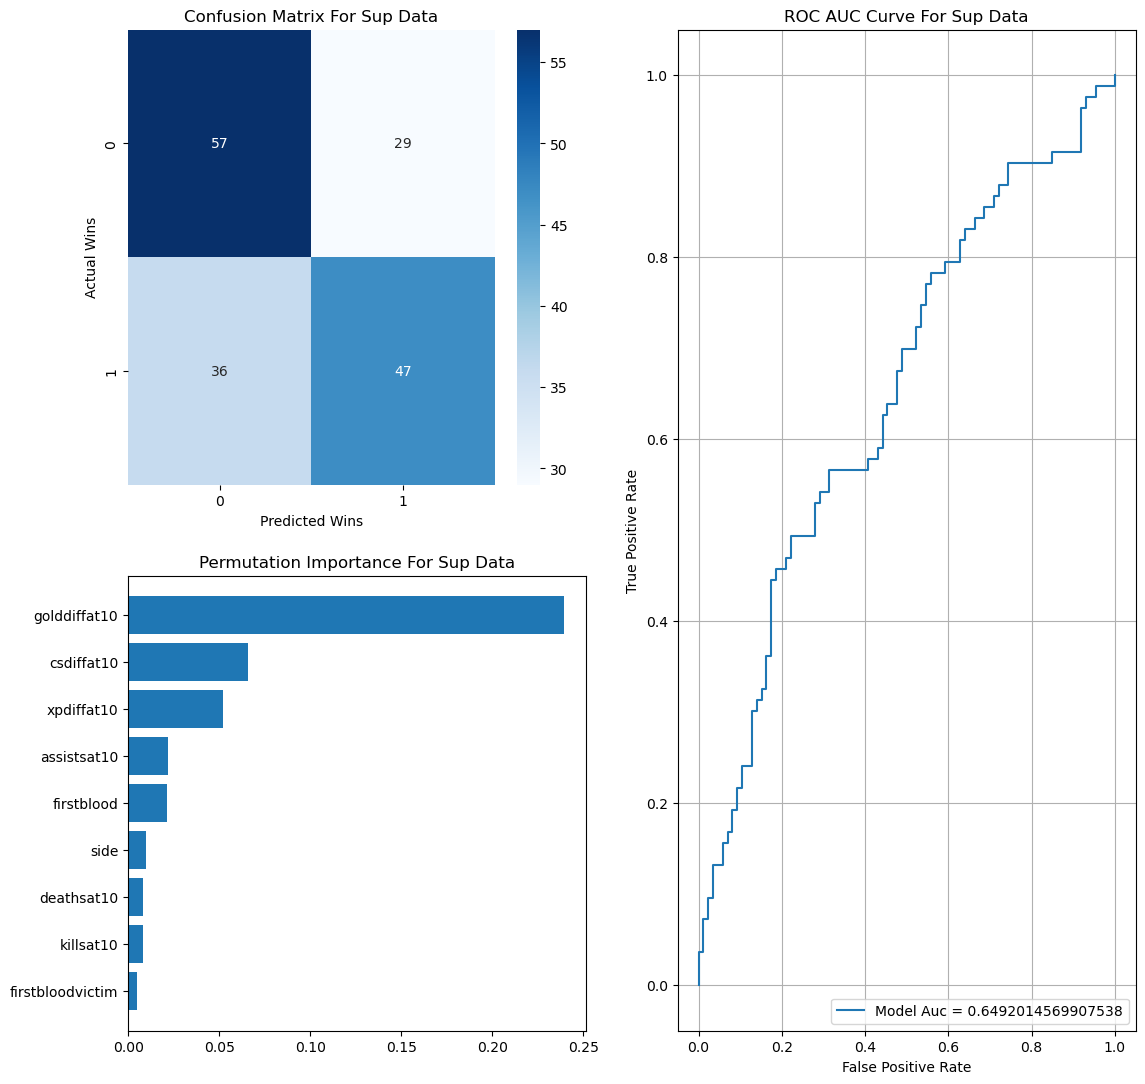

XGBRFClassifier(base_score=None, booster=None, callbacks=None,
                colsample_bylevel=None, colsample_bytree=None,
                early_stopping_rounds=None, enable_categorical=False,
                eval_metric=None, feature_types=None, gamma=None, gpu_id=None,
                grow_policy=None, importance_type=None,
                interaction_constraints=None, max_bin=None,
                max_cat_threshold=None, max_cat_to_onehot=None,
                max_delta_step=None, max_depth=None, max_leaves=None,
                min_child_weight=None, missing=nan, monotone_constraints=None,
                n_estimators=100, n_jobs=None, num_parallel_tree=None,
                objective='binary:logistic', predictor=None, random_state=213,
                reg_alpha=None, ...)

In [98]:
fit_eval(XGBRFClassifier(random_state = 213), xsup_train, ysup_train, xsup_test, ysup_test, title = "Sup Data", folderpath = "./XGBRF./")

CLASSIFICATION REPORT FOR TRAINING DATA
              precision    recall  f1-score   support

           0     0.8708    0.8448    0.8576       335
           1     0.8506    0.8757    0.8630       338

    accuracy                         0.8603       673
   macro avg     0.8607    0.8603    0.8603       673
weighted avg     0.8606    0.8603    0.8603       673

CLASSIFICATION REPORT FOR TEST DATA
              precision    recall  f1-score   support

           0     0.6778    0.7093    0.6932        86
           1     0.6835    0.6506    0.6667        83

    accuracy                         0.6805       169
   macro avg     0.6807    0.6800    0.6799       169
weighted avg     0.6806    0.6805    0.6802       169



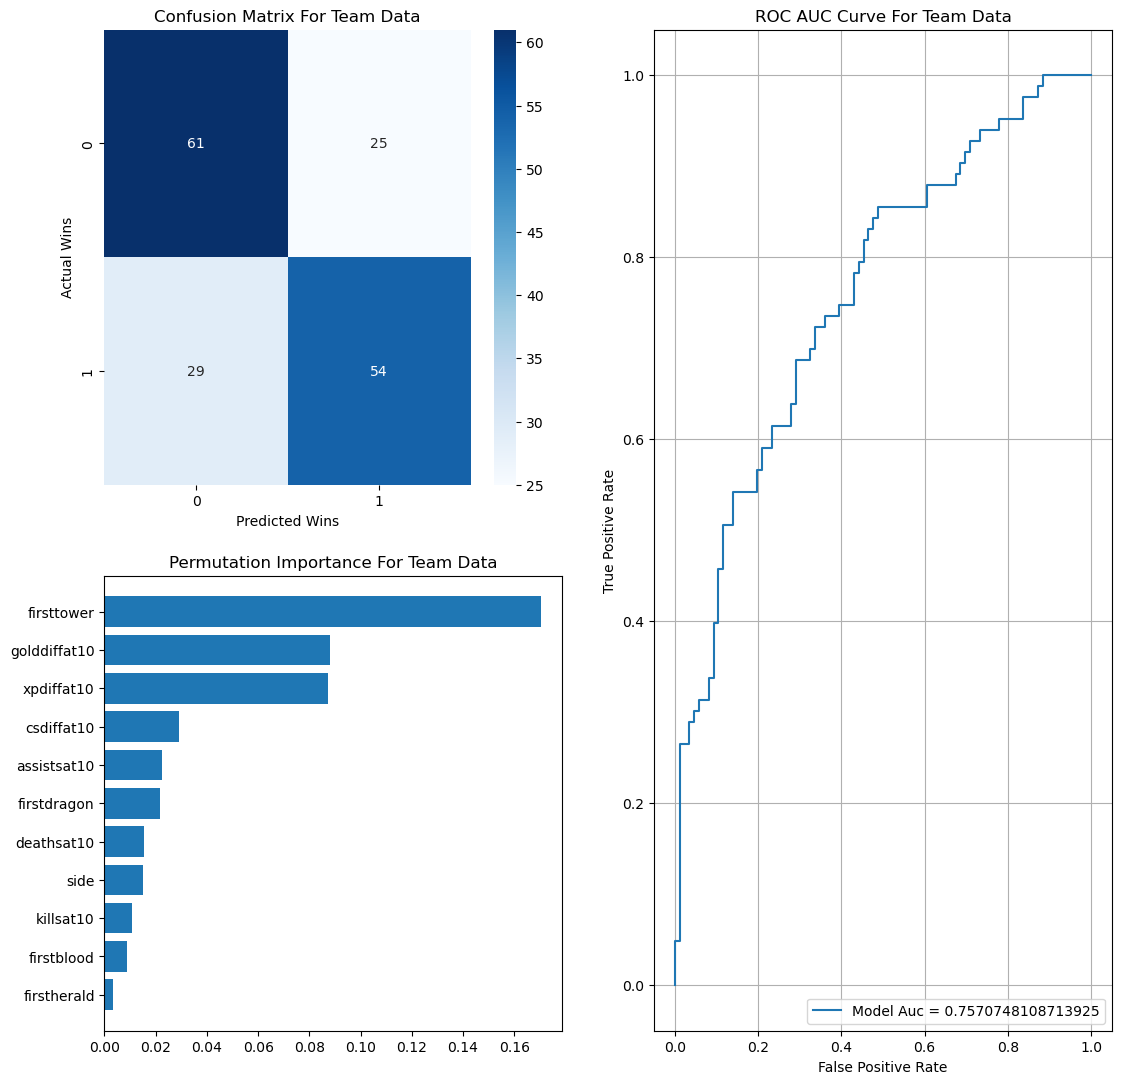

XGBRFClassifier(base_score=None, booster=None, callbacks=None,
                colsample_bylevel=None, colsample_bytree=None,
                early_stopping_rounds=None, enable_categorical=False,
                eval_metric=None, feature_types=None, gamma=None, gpu_id=None,
                grow_policy=None, importance_type=None,
                interaction_constraints=None, max_bin=None,
                max_cat_threshold=None, max_cat_to_onehot=None,
                max_delta_step=None, max_depth=None, max_leaves=None,
                min_child_weight=None, missing=nan, monotone_constraints=None,
                n_estimators=100, n_jobs=None, num_parallel_tree=None,
                objective='binary:logistic', predictor=None, random_state=213,
                reg_alpha=None, ...)

In [99]:
fit_eval(XGBRFClassifier(random_state = 213), xteam_train, yteam_train, xteam_test, yteam_test, title = "Team Data", folderpath = "./XGBRF./")

In [100]:
df_scores.loc[24] = ["XGBoost Random Forest", "Top", 0.5703, 0.5978]
df_scores.loc[25] = ["XGBoost Random Forest", "Jungle", 0.5938, 0.6220]
df_scores.loc[26] = ["XGBoost Random Forest", "Middle", 0.5703, 0.6400]
df_scores.loc[27] = ["XGBoost Random Forest", "Bottom", 0.6406, 0.6459]
df_scores.loc[28] = ["XGBoost Random Forest", "Support", 0.6406, 0.6444]
df_scores.loc[29] = ["XGBoost Random Forest", "Team", 0.7188, 0.7805]

Now that we have put everything into one data frame, let's look at difference aspects.

In [101]:
df_scores

Model     Lane  Accuracy  AUCROC
0               Logistic Regression      Top    0.6173  0.6168
1               Logistic Regression   Jungle    0.6618  0.6674
2               Logistic Regression   Middle    0.6176  0.6308
3               Logistic Regression   Bottom    0.6512  0.7250
4               Logistic Regression  Support    0.6328  0.6576
5               Logistic Regression     Team    0.7578  0.8037
6                     Random Forest      Top    0.5625  0.5768
7                     Random Forest   Jungle    0.5859  0.5972
8                     Random Forest   Middle    0.5469  0.6393
9                     Random Forest   Bottom    0.6512  0.7250
10                    Random Forest  Support    0.6016  0.6434
11                    Random Forest     Team    0.6094  0.6452
12     Linear Discriminant Analysis      Top    0.6094  0.6163
13     Linear Discriminant Analysis   Jungle    0.6406  0.6674
14     Linear Discriminant Analysis   Middle    0.5938  0.6337
15     Linear Discriminant Analysis   Bottom    0.6406  0.7201
16     Linear Discriminant Analysis  Support    0.6172  0.6559
17     Linear Discriminant Analysis     Team    0.7500  0.8049
18  Quadratic Discriminant Analysis      Top    0.5391  0.5573
19  Quadratic Discriminant Analysis   Jungle    0.6016  0.6413
20  Quadratic Discriminant Analysis   Middle    0.5938  0.6278
21  Quadratic Discriminant Analysis   Bottom    0.6328  0.6464
22  Quadratic Discriminant Analysis  Support    0.6406  0.6476
23  Quadratic Discriminant Analysis     Team    0.7109  0.7438
24            XGBoost Random Forest      Top    0.5703  0.5978
25            XGBoost Random Forest   Jungle    0.5938  0.6220
26            XGBoost Random Forest   Middle    0.5703  0.6400
27            XGBoost Random Forest   Bottom    0.6406  0.6459
28            XGBoost Random Forest  Support    0.6406  0.6444
29            XGBoost Random Forest     Team    0.7188  0.7805

Can we sort by accuracy?

In [102]:
df_scores.sort_values("Accuracy", ascending = False)

Model     Lane  Accuracy  AUCROC
5               Logistic Regression     Team    0.7578  0.8037
17     Linear Discriminant Analysis     Team    0.7500  0.8049
29            XGBoost Random Forest     Team    0.7188  0.7805
23  Quadratic Discriminant Analysis     Team    0.7109  0.7438
1               Logistic Regression   Jungle    0.6618  0.6674
3               Logistic Regression   Bottom    0.6512  0.7250
9                     Random Forest   Bottom    0.6512  0.7250
13     Linear Discriminant Analysis   Jungle    0.6406  0.6674
28            XGBoost Random Forest  Support    0.6406  0.6444
27            XGBoost Random Forest   Bottom    0.6406  0.6459
22  Quadratic Discriminant Analysis  Support    0.6406  0.6476
15     Linear Discriminant Analysis   Bottom    0.6406  0.7201
21  Quadratic Discriminant Analysis   Bottom    0.6328  0.6464
4               Logistic Regression  Support    0.6328  0.6576
2               Logistic Regression   Middle    0.6176  0.6308
0               Logistic Regression      Top    0.6173  0.6168
16     Linear Discriminant Analysis  Support    0.6172  0.6559
11                    Random Forest     Team    0.6094  0.6452
12     Linear Discriminant Analysis      Top    0.6094  0.6163
19  Quadratic Discriminant Analysis   Jungle    0.6016  0.6413
10                    Random Forest  Support    0.6016  0.6434
20  Quadratic Discriminant Analysis   Middle    0.5938  0.6278
25            XGBoost Random Forest   Jungle    0.5938  0.6220
14     Linear Discriminant Analysis   Middle    0.5938  0.6337
7                     Random Forest   Jungle    0.5859  0.5972
24            XGBoost Random Forest      Top    0.5703  0.5978
26            XGBoost Random Forest   Middle    0.5703  0.6400
6                     Random Forest      Top    0.5625  0.5768
8                     Random Forest   Middle    0.5469  0.6393
18  Quadratic Discriminant Analysis      Top    0.5391  0.5573

What are the most accurate models by lane?

In [103]:
df_scores.groupby("Lane").idxmax()

C:\Users\Florence.000\AppData\Local\Temp\ipykernel_5148\326216003.py:1: FutureWarning: The default value of numeric_only in DataFrameGroupBy.idxmax is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  df_scores.groupby("Lane").idxmax()


Accuracy  AUCROC
Lane                     
Bottom          3       3
Jungle          1       1
Middle          2      26
Support        22       4
Team            5      17
Top             0       0

In [104]:
df_scores.loc[[3, 1, 2, 22, 5, 0]]

Model     Lane  Accuracy  AUCROC
3               Logistic Regression   Bottom    0.6512  0.7250
1               Logistic Regression   Jungle    0.6618  0.6674
2               Logistic Regression   Middle    0.6176  0.6308
22  Quadratic Discriminant Analysis  Support    0.6406  0.6476
5               Logistic Regression     Team    0.7578  0.8037
0               Logistic Regression      Top    0.6173  0.6168

What are the most accurate models?

In [105]:
df_scores.groupby("Model").mean().sort_values("Accuracy", ascending = False)

C:\Users\Florence.000\AppData\Local\Temp\ipykernel_5148\3478231908.py:1: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  df_scores.groupby("Model").mean().sort_values("Accuracy", ascending = False)


Accuracy    AUCROC
Model                                              
Logistic Regression              0.656417  0.683550
Linear Discriminant Analysis     0.641933  0.683050
XGBoost Random Forest            0.622400  0.655100
Quadratic Discriminant Analysis  0.619800  0.644033
Random Forest                    0.592917  0.637817

Which lane was the most accurate?

In [106]:
df_scores.groupby("Lane").mean().sort_values("Accuracy", ascending = False)

C:\Users\Florence.000\AppData\Local\Temp\ipykernel_5148\72767136.py:1: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  df_scores.groupby("Lane").mean().sort_values("Accuracy", ascending = False)


Accuracy   AUCROC
Lane                      
Team      0.70938  0.75562
Bottom    0.64328  0.69248
Support   0.62656  0.64978
Jungle    0.61674  0.63906
Middle    0.58448  0.63432
Top       0.57972  0.59300